# Face Detection Benchmark

In [1]:
import cv2
import numpy as np
from deepface import DeepFace
import os
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
from PIL import Image, ImageDraw

from skeleton.inference import CenterFace

2023-11-26 14:55:05.594529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:55:08.554053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 14:55:08.568667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 14:55:16.636061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


define metrics and helping functions

In [2]:
def calculate_iou(box1, box2):
    """
    Intersection over Union (IoU) Calculation
    box1 and box2 are expected as points (x, y, w, h)
    """
    x1, y1, x2, y2 = (box1[0], box1[1], box1[0]+box1[2], box1[1]+box1[3])
    x3,y3,x4, y4= (box2[0], box2[1], box2[0]+box2[2], box2[1]+box2[3])
    
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    return iou

# Precision, Recall, and F1 Score Calculation
def calculate_precision_recall_f1(box1, box2):
    iou = calculate_iou(box1, box2)
    precision = iou / box2[2] / box2[3]
    recall = iou / box1[2] / box1[3]
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1_score

def plot_histogram(data, title):
    # Plot the histogram
    plt.hist(data, bins=50, align='left', rwidth=0.8)
    
    # Calculate statistics
    mean_value = np.mean(data)
    median_value = np.median(data)
    std_deviation = np.std(data)
    
    print("mean:", mean_value)
    print("median:", median_value)
    print("std_deviation:", std_deviation)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)

    # Show the plot
    plt.show()


Define the Benchmark itself

In [3]:
def face_detection_benchmark_on_BUAA(detector, shape, ignore_poorly_illuminated=True, BUAA_pth = "data/BUAA/BUAAVISNIR"):
    assert detector in ["retinaface", "mtcnn", "opencv", "ssv", "dlib", "centerface"], "Invalid detector"
    if detector == "centerface" and shape != (224, 224):
        print("Centerface requires output shape (224, 224) - changing to this shape")
        
    vl_fps = []
    ni_fps = []
    vl_faces = []
    ni_faces = []
    ious = []
    precisions = []
    recalls = []
    f1s = []
    i = 0
    skipped = 0

    for root, dirs, files in os.walk(str(BUAA_pth)):
        files = sorted([f for f in files if f[:-4].isdigit()], key=lambda x: int(x.split('.')[0]))
        print(files)

        # Iterate over pairs of even and odd positions
        for j in range(0, len(files), 2):
            # Ensure there is an odd-indexed element following the even-indexed element
            if j + 1 < len(files):
                even_position_item = files[j]
                odd_position_item = files[j + 1]

                vl_img_pth = str(Path(root) / even_position_item)
                ni_img_pth = str(Path(root) / odd_position_item)
                
                print("-"*10, '#', i, "-"*10)
                print(vl_img_pth)
                print(ni_img_pth)

                if odd_position_item[-3:] != 'bmp' or even_position_item[-3:] != 'bmp': 
                    print("== skipping ==")
                    skipped += 1
                    continue
                if ignore_poorly_illuminated and j >= 26:
                    print("== ignoring poorly illuminated ==")
                    continue
                
                # preprocess images
                vl_img = cv2.imread(vl_img_pth)    
                vl_img = cv2.cvtColor(cv2.cvtColor(vl_img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB) # convert to grayscale (as RGB)
                ni_img = cv2.imread(ni_img_pth)    
                ni_img = cv2.cvtColor(cv2.cvtColor(ni_img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB) # convert to grayscale (as RGB)
                
                if detector == "centerface":
                    centerface = CenterFace()
                    vl_dets, _ = centerface(vl_img, threshold=0.35)
                    ni_dets, _ = centerface(ni_img, threshold=0.35)
                    
#                     vl_face_objs = (vl_dets, vl_lms)
#                     ni_face_objs = (ni_dets, ni_lms)
                    
                    # adjust face objects
                    vl_face_objs = []
                    for det in vl_dets:
                        vl_face_objs.append({
                            'face': vl_img[int(det[1]):int(det[3]), int(det[0]):int(det[2]), :],
                            'facial_area': {'x': det[0], 'y': det[1], 'w': det[2] - det[0], 'h': det[3] - det[1]},
                            'confidence': det[4]
                        })
                    ni_face_objs = []
                    for det in ni_dets:
                        ni_face_objs.append({
                            'face': ni_img[int(det[1]):int(det[3]), int(det[0]):int(det[2]), :],
                            'facial_area': {'x': det[0], 'y': det[1], 'w': det[2] - det[0], 'h': det[3] - det[1]},
                            'confidence': det[4]
                        })
                    
                    # bounding box points - x, y, w, h
                    vl_box = [vl_dets[0][0], vl_dets[0][1], vl_dets[0][2] - vl_dets[0][0], vl_dets[0][3] - vl_dets[0][1]]
                    ni_box = [ni_dets[0][0], ni_dets[0][1], ni_dets[0][2] - ni_dets[0][0], ni_dets[0][3] - ni_dets[0][1]]
                else:


                    vl_face_objs = DeepFace.extract_faces(
                                    img_path=vl_img,
                                    target_size=shape,
                                    detector_backend=detector,
                                    enforce_detection=False,
                                    align=False
                                )

                    ni_face_objs = DeepFace.extract_faces(
                                    img_path=ni_img,
                                    target_size=shape,
                                    detector_backend=detector,
                                    enforce_detection=False,
                                    aling=False
                                )
                    
                    # bounding box points - x, y, w, h
                    vl_box = list(vl_face_objs[0]['facial_area'].values())
                    ni_box = list(ni_face_objs[0]['facial_area'].values())

                iou = calculate_iou(vl_box, ni_box)
                precision, recall, f1_score = calculate_precision_recall_f1(vl_box, ni_box)

                print("iou", iou)
                print("f1", f1_score)
                print("prec", precision)
                print("rec", recall)

                vl_faces.append(vl_face_objs)
                ni_faces.append(ni_face_objs)
                ious.append(iou)
                f1s.append(f1_score)
                precisions.append(precision)
                recalls.append(recall)
                vl_fps.append(vl_img_pth)
                ni_fps.append(ni_img_pth)

                i+=1

    print("="*25)
    print("skipped:", skipped)

    plot_histogram(ious, "IOU")
    plot_histogram(precisions, "precision")
    plot_histogram(recalls, "recall")
    plot_histogram(f1s, "f1")
    
    return vl_fps, ni_fps, vl_faces, ni_faces, ious, precisions, recalls, f1s

## Benchmark on RetinaFace

[]
['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', '40.bmp', '41.bmp', '42.bmp', '43.bmp', '44.bmp']
---------- # 0 ----------
data/BUAA/BUAAVISNIR/19/1.bmp
data/BUAA/BUAAVISNIR/19/2.bmp
iou 0.9854917691185664
f1 1.2928381926595122e-05
prec 1.2943154309411169e-05
rec 1.2913643225601676e-05
---------- # 1 ----------
data/BUAA/BUAAVISNIR/19/3.bmp
data/BUAA/BUAAVISNIR/19/4.bmp
iou 0.9169054441260746
f1 1.1008523710700193e-05
prec 1.1507347441341297e-05
rec 1.055114951641609e-05
---------- # 2 ----------
data/BUAA/BUAAVISNIR/19/5.bmp
data/BUAA/BUAAVISNIR/19/6.bmp
iou 0.932396740657488
f1 1.0845921315118945e-05
prec 1.0767327682400693e-05
rec 1.0925670736553644e-05
---------- # 3 ----------
data/BUAA/B

iou 0.957473619618457
f1 1.0719528211535504e-05
prec 1.0957583195450412e-05
rec 1.0491596844418284e-05
---------- # 29 ----------
data/BUAA/BUAAVISNIR/90/7.bmp
data/BUAA/BUAAVISNIR/90/8.bmp
iou 0.9847328244274809
f1 1.0978069391610712e-05
prec 1.102045575991809e-05
rec 1.0936007823060479e-05
---------- # 30 ----------
data/BUAA/BUAAVISNIR/90/9.bmp
data/BUAA/BUAAVISNIR/90/10.bmp
iou 0.9681770663549196
f1 1.1059130010736355e-05
prec 1.1197976710096225e-05
rec 1.0923684335671713e-05
---------- # 31 ----------
data/BUAA/BUAAVISNIR/90/11.bmp
data/BUAA/BUAAVISNIR/90/12.bmp
iou 0.8974908346426701
f1 1.1260015991803255e-05
prec 1.1376195744089009e-05
rec 1.1146185229044588e-05
---------- # 32 ----------
data/BUAA/BUAAVISNIR/90/13.bmp
data/BUAA/BUAAVISNIR/90/14.bmp
iou 0.926469560355071
f1 1.1204672621182194e-05
prec 1.0792730369225681e-05
rec 1.1649309195964679e-05
---------- # 33 ----------
data/BUAA/BUAAVISNIR/90/15.bmp
data/BUAA/BUAAVISNIR/90/16.bmp
iou 0.9767634854771784
f1 1.2426067799877

iou 0.9287416191056685
f1 1.3340921901655776e-05
prec 1.3282917893387707e-05
rec 1.3399434717013916e-05
---------- # 59 ----------
data/BUAA/BUAAVISNIR/94/15.bmp
data/BUAA/BUAAVISNIR/94/16.bmp
iou 0.9259448416751788
f1 1.3641310022027442e-05
prec 1.3935717922990468e-05
rec 1.3359084165442907e-05
---------- # 60 ----------
data/BUAA/BUAAVISNIR/94/17.bmp
data/BUAA/BUAAVISNIR/94/18.bmp
iou 0.9718513752613801
f1 1.585531242778987e-05
prec 1.5945059479267927e-05
rec 1.5766570007485075e-05
---------- # 61 ----------
data/BUAA/BUAAVISNIR/94/21.bmp
data/BUAA/BUAAVISNIR/94/22.bmp
iou 0.9535383641495002
f1 1.2874431936346025e-05
prec 1.2881301778446473e-05
rec 1.2867569417973392e-05
---------- # 62 ----------
data/BUAA/BUAAVISNIR/94/23.bmp
data/BUAA/BUAAVISNIR/94/24.bmp
iou 0.9717
f1 1.232058629608967e-05
prec 1.25e-05
rec 1.214625e-05
---------- # 63 ----------
data/BUAA/BUAAVISNIR/94/25.bmp
data/BUAA/BUAAVISNIR/94/26.bmp
iou 0.974887856456264
f1 1.3180661494605635e-05
prec 1.329525484079677e-0

iou 0.9615626969124134
f1 1.54443092983041e-05
prec 1.5282306053916297e-05
rec 1.560978404078593e-05
---------- # 89 ----------
data/BUAA/BUAAVISNIR/122/25.bmp
data/BUAA/BUAAVISNIR/122/26.bmp
iou 0.959411886518948
f1 1.4485187162468643e-05
prec 1.4312744458153541e-05
rec 1.4661835786401187e-05
---------- # 90 ----------
data/BUAA/BUAAVISNIR/122/27.bmp
data/BUAA/BUAAVISNIR/122/28.bmp
iou 0.9680898675259577
f1 1.4676367140814217e-05
prec 1.4442204730963685e-05
rec 1.4918248000954769e-05
---------- # 91 ----------
data/BUAA/BUAAVISNIR/122/31.bmp
data/BUAA/BUAAVISNIR/122/32.bmp
== ignoring poorly illuminated ==
---------- # 91 ----------
data/BUAA/BUAAVISNIR/122/33.bmp
data/BUAA/BUAAVISNIR/122/34.bmp
== ignoring poorly illuminated ==
---------- # 91 ----------
data/BUAA/BUAAVISNIR/122/35.bmp
data/BUAA/BUAAVISNIR/122/36.bmp
== ignoring poorly illuminated ==
---------- # 91 ----------
data/BUAA/BUAAVISNIR/122/37.bmp
data/BUAA/BUAAVISNIR/122/38.bmp
== ignoring poorly illuminated ==
----------

iou 0.9670683122357728
f1 1.1979416087897838e-05
prec 1.1961265457461632e-05
rec 1.1997621887423521e-05
---------- # 118 ----------
data/BUAA/BUAAVISNIR/144/3.bmp
data/BUAA/BUAAVISNIR/144/4.bmp
iou 0.9700997972867612
f1 1.2797221801673509e-05
prec 1.2994438380373199e-05
rec 1.2605902038655351e-05
---------- # 119 ----------
data/BUAA/BUAAVISNIR/144/5.bmp
data/BUAA/BUAAVISNIR/144/6.bmp
iou 0.9571289212917801
f1 1.2554486231167924e-05
prec 1.2568004113816115e-05
rec 1.2540997396380768e-05
---------- # 120 ----------
data/BUAA/BUAAVISNIR/144/7.bmp
data/BUAA/BUAAVISNIR/144/8.bmp
iou 0.9754604356920565
f1 1.2596012960564765e-05
prec 1.2701307756406987e-05
rec 1.249244961441597e-05
---------- # 121 ----------
data/BUAA/BUAAVISNIR/144/9.bmp
data/BUAA/BUAAVISNIR/144/10.bmp
iou 0.9459004724001812
f1 1.2582646789493596e-05
prec 1.2355021844307487e-05
rec 1.2818816538828854e-05
---------- # 122 ----------
data/BUAA/BUAAVISNIR/144/11.bmp
data/BUAA/BUAAVISNIR/144/12.bmp
iou 0.9746031746031746
f1 1.

iou 0.9644834515851208
f1 1.0067676947652619e-05
prec 1.014818446533166e-05
rec 9.988436739696777e-06
---------- # 148 ----------
data/BUAA/BUAAVISNIR/18/11.bmp
data/BUAA/BUAAVISNIR/18/12.bmp
iou 0.9598510356086114
f1 9.9940238499478e-06
prec 1.020304050607081e-05
rec 9.793398996108677e-06
---------- # 149 ----------
data/BUAA/BUAAVISNIR/18/13.bmp
data/BUAA/BUAAVISNIR/18/14.bmp
iou 0.9916434540389972
f1 1.0467274881002742e-05
prec 1.0481934929855687e-05
rec 1.0452655782006927e-05
---------- # 150 ----------
data/BUAA/BUAAVISNIR/18/15.bmp
data/BUAA/BUAAVISNIR/18/16.bmp
iou 0.9337423035132199
f1 1.093055081666046e-05
prec 1.0963277016710342e-05
rec 1.0898019415420399e-05
---------- # 151 ----------
data/BUAA/BUAAVISNIR/18/17.bmp
data/BUAA/BUAAVISNIR/18/18.bmp
iou 0.9707093544349792
f1 9.943245628015152e-06
prec 9.943245628015152e-06
rec 9.943245628015152e-06
---------- # 152 ----------
data/BUAA/BUAAVISNIR/18/21.bmp
data/BUAA/BUAAVISNIR/18/22.bmp
iou 0.9448511469009273
f1 9.8792466217160

iou 0.9670325061167424
f1 1.3746801610848411e-05
prec 1.3809226396823304e-05
rec 1.3684938669148965e-05
---------- # 178 ----------
data/BUAA/BUAAVISNIR/78/21.bmp
data/BUAA/BUAAVISNIR/78/22.bmp
iou 0.8951522383827404
f1 1.1161499231704992e-05
prec 1.1765933732685861e-05
rec 1.061613185937785e-05
---------- # 179 ----------
data/BUAA/BUAAVISNIR/78/23.bmp
data/BUAA/BUAAVISNIR/78/24.bmp
iou 0.9736424074836736
f1 1.160963939049274e-05
prec 1.1593741456104712e-05
rec 1.1625580984879685e-05
---------- # 180 ----------
data/BUAA/BUAAVISNIR/78/25.bmp
data/BUAA/BUAAVISNIR/78/26.bmp
iou 0.9527111580542577
f1 1.120263345293006e-05
prec 1.1308278532139938e-05
rec 1.109894403474286e-05
---------- # 181 ----------
data/BUAA/BUAAVISNIR/78/27.bmp
data/BUAA/BUAAVISNIR/78/28.bmp
iou 0.9572704491421963
f1 8.97888587413598e-06
prec 8.935096038140273e-06
rec 9.023107041522808e-06
---------- # 182 ----------
data/BUAA/BUAAVISNIR/78/31.bmp
data/BUAA/BUAAVISNIR/78/32.bmp
== ignoring poorly illuminated ==
----

iou 0.8812749003984064
f1 1.1311012288044438e-05
prec 1.2072920439454304e-05
rec 1.0639561757797976e-05
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/31.bmp
data/BUAA/BUAAVISNIR/121/32.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/33.bmp
data/BUAA/BUAAVISNIR/121/34.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/35.bmp
data/BUAA/BUAAVISNIR/121/36.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/37.bmp
data/BUAA/BUAAVISNIR/121/38.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/39.bmp
data/BUAA/BUAAVISNIR/121/40.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/41.bmp
data/BUAA/BUAAVISNIR/121/42.bmp
== ignoring poorly illuminated ==
---------- # 208 ----------
data/BUAA/BUAAVISNIR/121/43.bmp
data/BUAA/BUAAVISNIR/121/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.b

iou 0.9411980804996212
f1 1.1132510266717381e-05
prec 1.1261583235613347e-05
rec 1.1006362472807038e-05
---------- # 235 ----------
data/BUAA/BUAAVISNIR/34/3.bmp
data/BUAA/BUAAVISNIR/34/4.bmp
iou 0.926702772168166
f1 1.103769470649808e-05
prec 1.114280802453125e-05
rec 1.0934545984285144e-05
---------- # 236 ----------
data/BUAA/BUAAVISNIR/34/5.bmp
data/BUAA/BUAAVISNIR/34/6.bmp
iou 0.9555847811541035
f1 1.1274405431458209e-05
prec 1.1152950293581973e-05
rec 1.1398534975715145e-05
---------- # 237 ----------
data/BUAA/BUAAVISNIR/34/7.bmp
data/BUAA/BUAAVISNIR/34/8.bmp
iou 0.9641072187690293
f1 1.1279405893758752e-05
prec 1.1443409124854946e-05
rec 1.112003712536366e-05
---------- # 238 ----------
data/BUAA/BUAAVISNIR/34/9.bmp
data/BUAA/BUAAVISNIR/34/10.bmp
iou 0.9748072389326105
f1 1.1243840489666432e-05
prec 1.1355830932790597e-05
rec 1.1134037359884531e-05
---------- # 239 ----------
data/BUAA/BUAAVISNIR/34/11.bmp
data/BUAA/BUAAVISNIR/34/12.bmp
iou 0.966331914893617
f1 1.11532223575724

iou 0.9757084003215434
f1 1.2405858946986529e-05
prec 1.2443990413242824e-05
rec 1.2367960455337094e-05
---------- # 265 ----------
data/BUAA/BUAAVISNIR/40/11.bmp
data/BUAA/BUAAVISNIR/40/12.bmp
iou 0.9623091114071949
f1 1.2565242689915714e-05
prec 1.2402808571005761e-05
rec 1.2731987925791789e-05
---------- # 266 ----------
data/BUAA/BUAAVISNIR/40/13.bmp
data/BUAA/BUAAVISNIR/40/14.bmp
iou 0.992654579265458
f1 1.3233894548823906e-05
prec 1.3185290287115068e-05
rec 1.3282858471142991e-05
---------- # 267 ----------
data/BUAA/BUAAVISNIR/40/15.bmp
data/BUAA/BUAAVISNIR/40/16.bmp
iou 0.9666491914344477
f1 1.321452609940394e-05
prec 1.328563052590673e-05
rec 1.3144178720111606e-05
---------- # 268 ----------
data/BUAA/BUAAVISNIR/40/17.bmp
data/BUAA/BUAAVISNIR/40/18.bmp
iou 0.9704658562454108
f1 1.3393864638475913e-05
prec 1.3597672078540153e-05
rec 1.3196076476644786e-05
---------- # 269 ----------
data/BUAA/BUAAVISNIR/40/21.bmp
data/BUAA/BUAAVISNIR/40/22.bmp
iou 0.9549751486209921
f1 1.19014

iou 0.9785427423981641
f1 1.891671484850208e-05
prec 1.9124115509657678e-05
rec 1.871376443675969e-05
---------- # 295 ----------
data/BUAA/BUAAVISNIR/46/21.bmp
data/BUAA/BUAAVISNIR/46/22.bmp
iou 0.9722645534897897
f1 1.5024950602531133e-05
prec 1.4967126747071884e-05
rec 1.5083222983087027e-05
---------- # 296 ----------
data/BUAA/BUAAVISNIR/46/23.bmp
data/BUAA/BUAAVISNIR/46/24.bmp
iou 0.9122069428629821
f1 1.3927886752622068e-05
prec 1.4396296680496531e-05
rec 1.3488997469360634e-05
---------- # 297 ----------
data/BUAA/BUAAVISNIR/46/25.bmp
data/BUAA/BUAAVISNIR/46/26.bmp
iou 0.9804411806726291
f1 1.4145841200306295e-05
prec 1.4068808286424388e-05
rec 1.4223722336756552e-05
---------- # 298 ----------
data/BUAA/BUAAVISNIR/46/27.bmp
data/BUAA/BUAAVISNIR/46/28.bmp
iou 0.9830057105205359
f1 1.360957109361248e-05
prec 1.3727212826707664e-05
rec 1.3493928598184382e-05
---------- # 299 ----------
data/BUAA/BUAAVISNIR/46/31.bmp
data/BUAA/BUAAVISNIR/46/32.bmp
== ignoring poorly illuminated ==

iou 0.9510481982830539
f1 1.3118087122347257e-05
prec 1.3396931938062457e-05
rec 1.2850613423995431e-05
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/31.bmp
data/BUAA/BUAAVISNIR/80/32.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/33.bmp
data/BUAA/BUAAVISNIR/80/34.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/35.bmp
data/BUAA/BUAAVISNIR/80/36.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/37.bmp
data/BUAA/BUAAVISNIR/80/38.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/39.bmp
data/BUAA/BUAAVISNIR/80/40.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/41.bmp
data/BUAA/BUAAVISNIR/80/42.bmp
== ignoring poorly illuminated ==
---------- # 325 ----------
data/BUAA/BUAAVISNIR/80/43.bmp
data/BUAA/BUAAVISNIR/80/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp', 

iou 0.9660871263918734
f1 1.2798737813704721e-05
prec 1.2633213808869566e-05
rec 1.2968656890378733e-05
---------- # 352 ----------
data/BUAA/BUAAVISNIR/88/3.bmp
data/BUAA/BUAAVISNIR/88/4.bmp
iou 0.9656257020894181
f1 1.2984686681360802e-05
prec 1.2813504539403106e-05
rec 1.3160504573745358e-05
---------- # 353 ----------
data/BUAA/BUAAVISNIR/88/5.bmp
data/BUAA/BUAAVISNIR/88/6.bmp
iou 0.970021612017873
f1 1.3057142057434975e-05
prec 1.3076415955809076e-05
rec 1.3037924892713346e-05
---------- # 354 ----------
data/BUAA/BUAAVISNIR/88/7.bmp
data/BUAA/BUAAVISNIR/88/8.bmp
iou 0.9405624744793794
f1 1.2369474539109921e-05
prec 1.256093048182932e-05
rec 1.2183767383602934e-05
---------- # 355 ----------
data/BUAA/BUAAVISNIR/88/9.bmp
data/BUAA/BUAAVISNIR/88/10.bmp
iou 0.99581589958159
f1 1.3556262076037872e-05
prec 1.3527901695125658e-05
rec 1.3584741618214423e-05
---------- # 356 ----------
data/BUAA/BUAAVISNIR/88/11.bmp
data/BUAA/BUAAVISNIR/88/12.bmp
iou 0.9323317323772191
f1 1.2909963338464

iou 0.964100878994496
f1 1.1521075494517857e-05
prec 1.173557404560444e-05
rec 1.1314277252872235e-05
---------- # 382 ----------
data/BUAA/BUAAVISNIR/25/11.bmp
data/BUAA/BUAAVISNIR/25/12.bmp
iou 0.9649367559523809
f1 1.1418288871495964e-05
prec 1.1625744047619047e-05
rec 1.1218107746842227e-05
---------- # 383 ----------
data/BUAA/BUAAVISNIR/25/13.bmp
data/BUAA/BUAAVISNIR/25/14.bmp
iou 0.957124842370744
f1 1.1012574125215667e-05
prec 1.1127288439019997e-05
rec 1.0900200919856323e-05
---------- # 384 ----------
data/BUAA/BUAAVISNIR/25/15.bmp
data/BUAA/BUAAVISNIR/25/16.bmp
iou 0.9453473373871384
f1 1.1939143316689568e-05
prec 1.1704333808604024e-05
rec 1.2183567086647314e-05
---------- # 385 ----------
data/BUAA/BUAAVISNIR/25/17.bmp
data/BUAA/BUAAVISNIR/25/18.bmp
iou 0.9592476489028213
f1 1.1368861024033439e-05
prec 1.1610356437942645e-05
rec 1.1137207116020217e-05
---------- # 386 ----------
data/BUAA/BUAAVISNIR/25/21.bmp
data/BUAA/BUAAVISNIR/25/22.bmp
iou 0.9629130141604855
f1 1.10261

iou 0.960393389977922
f1 8.193923537454114e-06
prec 8.334143756967632e-06
rec 8.058343597733864e-06
---------- # 412 ----------
data/BUAA/BUAAVISNIR/9/31.bmp
data/BUAA/BUAAVISNIR/9/32.bmp
iou 0.968403364517743
f1 9.288750852643199e-06
prec 9.1739613917937e-06
rec 9.406449325579578e-06
---------- # 413 ----------
data/BUAA/BUAAVISNIR/9/33.bmp
data/BUAA/BUAAVISNIR/9/34.bmp
iou 0.9429421468127724
f1 9.530588666826083e-06
prec 9.818938769097836e-06
rec 9.258691202356275e-06
---------- # 414 ----------
data/BUAA/BUAAVISNIR/9/35.bmp
data/BUAA/BUAAVISNIR/9/36.bmp
iou 0.8247594500053294
f1 8.7592670869367e-06
prec 8.668903195347166e-06
rec 8.851534713559455e-06
---------- # 415 ----------
data/BUAA/BUAAVISNIR/9/37.bmp
data/BUAA/BUAAVISNIR/9/38.bmp
iou 0.8781426681101888
f1 8.652973292573631e-06
prec 8.84511148378514e-06
rec 8.469005083569026e-06
---------- # 416 ----------
data/BUAA/BUAAVISNIR/9/39.bmp
data/BUAA/BUAAVISNIR/9/40.bmp
== ignoring poorly illuminated ==
---------- # 416 ----------


iou 0.8969066212451463
f1 1.3650300143748615e-05
prec 1.364905376864418e-05
rec 1.3651546746501467e-05
---------- # 443 ----------
data/BUAA/BUAAVISNIR/106/3.bmp
data/BUAA/BUAAVISNIR/106/4.bmp
iou 0.9766556941382538
f1 1.4921480973190747e-05
prec 1.4929920724872414e-05
rec 1.4913050757951655e-05
---------- # 444 ----------
data/BUAA/BUAAVISNIR/106/5.bmp
data/BUAA/BUAAVISNIR/106/6.bmp
iou 0.9692631766328937
f1 1.4602835052849622e-05
prec 1.4668026280764131e-05
rec 1.4538220738456483e-05
---------- # 445 ----------
data/BUAA/BUAAVISNIR/106/7.bmp
data/BUAA/BUAAVISNIR/106/8.bmp
iou 0.9561740435108778
f1 1.4667608180932172e-05
prec 1.4668845782874292e-05
rec 1.4666370787803938e-05
---------- # 446 ----------
data/BUAA/BUAAVISNIR/106/9.bmp
data/BUAA/BUAAVISNIR/106/10.bmp
iou 0.9652173913043478
f1 1.4576359770822855e-05
prec 1.451214673218487e-05
rec 1.4641143592026511e-05
---------- # 447 ----------
data/BUAA/BUAAVISNIR/106/11.bmp
data/BUAA/BUAAVISNIR/106/12.bmp
iou 0.8826399298583024
f1 1.3

iou 0.9778898017706366
f1 1.1252205551605883e-05
prec 1.1290856628879637e-05
rec 1.1213818193782814e-05
---------- # 473 ----------
data/BUAA/BUAAVISNIR/33/11.bmp
data/BUAA/BUAAVISNIR/33/12.bmp
iou 0.9402994798736061
f1 1.0524483791565256e-05
prec 1.064650679204717e-05
rec 1.0405226184861965e-05
---------- # 474 ----------
data/BUAA/BUAAVISNIR/33/13.bmp
data/BUAA/BUAAVISNIR/33/14.bmp
iou 0.980956185910241
f1 1.0991105724484496e-05
prec 1.0928656260140832e-05
rec 1.105427299876314e-05
---------- # 475 ----------
data/BUAA/BUAAVISNIR/33/15.bmp
data/BUAA/BUAAVISNIR/33/16.bmp
iou 0.978284163154511
f1 1.1774923126002154e-05
prec 1.1857989856418315e-05
rec 1.1693012085897294e-05
---------- # 476 ----------
data/BUAA/BUAAVISNIR/33/17.bmp
data/BUAA/BUAAVISNIR/33/18.bmp
iou 0.9722123222312918
f1 1.133477888870316e-05
prec 1.1278826912820388e-05
rec 1.1391288765056673e-05
---------- # 477 ----------
data/BUAA/BUAAVISNIR/33/21.bmp
data/BUAA/BUAAVISNIR/33/22.bmp
iou 0.9295144327590065
f1 1.0779478

iou 0.9154698277149085
f1 1.4270546487426674e-05
prec 1.4301087695112139e-05
rec 1.4240135448527075e-05
---------- # 503 ----------
data/BUAA/BUAAVISNIR/59/21.bmp
data/BUAA/BUAAVISNIR/59/22.bmp
iou 0.966959891088072
f1 1.2870489699029306e-05
prec 1.2966100234499999e-05
rec 1.2776278884415093e-05
---------- # 504 ----------
data/BUAA/BUAAVISNIR/59/23.bmp
data/BUAA/BUAAVISNIR/59/24.bmp
iou 0.9640308622379263
f1 1.3549655116629088e-05
prec 1.3608566660614432e-05
rec 1.349125143078155e-05
---------- # 505 ----------
data/BUAA/BUAAVISNIR/59/25.bmp
data/BUAA/BUAAVISNIR/59/26.bmp
iou 0.9741815173283255
f1 1.296074606631267e-05
prec 1.2968337557618815e-05
rec 1.2953163457721592e-05
---------- # 506 ----------
data/BUAA/BUAAVISNIR/59/27.bmp
data/BUAA/BUAAVISNIR/59/28.bmp
iou 0.9758051534775448
f1 1.2230587003378429e-05
prec 1.2118792268722613e-05
rec 1.2344463534530218e-05
---------- # 507 ----------
data/BUAA/BUAAVISNIR/59/31.bmp
data/BUAA/BUAAVISNIR/59/32.bmp
== ignoring poorly illuminated ==

iou 0.929011901466925
f1 1.0663711721517983e-05
prec 1.068382383378673e-05
rec 1.0643675188374885e-05
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/31.bmp
data/BUAA/BUAAVISNIR/86/32.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/33.bmp
data/BUAA/BUAAVISNIR/86/34.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/35.bmp
data/BUAA/BUAAVISNIR/86/36.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/37.bmp
data/BUAA/BUAAVISNIR/86/38.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/39.bmp
data/BUAA/BUAAVISNIR/86/40.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/41.bmp
data/BUAA/BUAAVISNIR/86/42.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/43.bmp
data/BUAA/BUAAVISNIR/86/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp', '4

iou 0.9844443773220165
f1 1.49841607531624e-05
prec 1.496889543718664e-05
rec 1.4999457236135066e-05
---------- # 560 ----------
data/BUAA/BUAAVISNIR/115/3.bmp
data/BUAA/BUAAVISNIR/115/4.bmp
iou 0.9768832967453921
f1 1.4561114002331131e-05
prec 1.4733399142516167e-05
rec 1.439281152660693e-05
---------- # 561 ----------
data/BUAA/BUAAVISNIR/115/5.bmp
data/BUAA/BUAAVISNIR/115/6.bmp
iou 0.9855861721964069
f1 1.4691164788951762e-05
prec 1.4585286829200682e-05
rec 1.4798591174120222e-05
---------- # 562 ----------
data/BUAA/BUAAVISNIR/115/7.bmp
data/BUAA/BUAAVISNIR/115/8.bmp
iou 0.9485351108355293
f1 1.5092046314010013e-05
prec 1.528416227579003e-05
rec 1.4904700044555773e-05
---------- # 563 ----------
data/BUAA/BUAAVISNIR/115/9.bmp
data/BUAA/BUAAVISNIR/115/10.bmp
iou 0.9656637435742365
f1 1.4855336839360912e-05
prec 1.4983843213403827e-05
rec 1.4729015947869748e-05
---------- # 564 ----------
data/BUAA/BUAAVISNIR/115/11.bmp
data/BUAA/BUAAVISNIR/115/12.bmp
iou 0.9650262071524653
f1 1.5186

iou 0.9461125569290826
f1 1.5815065265808298e-05
prec 1.6265452179570593e-05
rec 1.5388948551221255e-05
---------- # 590 ----------
data/BUAA/BUAAVISNIR/45/11.bmp
data/BUAA/BUAAVISNIR/45/12.bmp
iou 0.9546777029234671
f1 1.5197881176497692e-05
prec 1.5337419920049276e-05
rec 1.506085856823795e-05
---------- # 591 ----------
data/BUAA/BUAAVISNIR/45/13.bmp
data/BUAA/BUAAVISNIR/45/14.bmp
iou 0.960029325065294
f1 1.4962001185473181e-05
prec 1.520308684601476e-05
rec 1.4728442285681537e-05
---------- # 592 ----------
data/BUAA/BUAAVISNIR/45/15.bmp
data/BUAA/BUAAVISNIR/45/16.bmp
iou 0.9119036372224847
f1 1.877503885572338e-05
prec 1.9062327798454885e-05
rec 1.849628082476339e-05
---------- # 593 ----------
data/BUAA/BUAAVISNIR/45/17.bmp
data/BUAA/BUAAVISNIR/45/18.bmp
iou 0.9482624389553401
f1 2.2965632262998512e-05
prec 2.3240017620158816e-05
rec 2.269765041302456e-05
---------- # 594 ----------
data/BUAA/BUAAVISNIR/45/21.bmp
data/BUAA/BUAAVISNIR/45/22.bmp
iou 0.9613459756184501
f1 1.39772166

iou 0.8846719483846482
f1 1.4845855436431115e-05
prec 1.5198982035952448e-05
rec 1.4508765041158644e-05
---------- # 620 ----------
data/BUAA/BUAAVISNIR/131/21.bmp
data/BUAA/BUAAVISNIR/131/22.bmp
iou 0.9706657877389585
f1 1.546150873675258e-05
prec 1.569513764635716e-05
rec 1.5234733147172654e-05
---------- # 621 ----------
data/BUAA/BUAAVISNIR/131/23.bmp
data/BUAA/BUAAVISNIR/131/24.bmp
iou 0.9176450995087018
f1 1.3282456895055534e-05
prec 1.285757460429735e-05
rec 1.373637955075597e-05
---------- # 622 ----------
data/BUAA/BUAAVISNIR/131/25.bmp
data/BUAA/BUAAVISNIR/131/26.bmp
iou 0.9476536791748472
f1 1.34546828784071e-05
prec 1.3467493948424624e-05
rec 1.3441896158508472e-05
---------- # 623 ----------
data/BUAA/BUAAVISNIR/131/27.bmp
data/BUAA/BUAAVISNIR/131/28.bmp
iou 0.9822124433369562
f1 1.3135572629046557e-05
prec 1.301874775782621e-05
rec 1.325451316173157e-05
---------- # 624 ----------
data/BUAA/BUAAVISNIR/131/31.bmp
data/BUAA/BUAAVISNIR/131/32.bmp
== ignoring poorly illuminat

iou 0.9788026388803256
f1 1.2199121821143081e-05
prec 1.2331216474505211e-05
rec 1.2069827225850244e-05
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/31.bmp
data/BUAA/BUAAVISNIR/123/32.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/33.bmp
data/BUAA/BUAAVISNIR/123/34.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/35.bmp
data/BUAA/BUAAVISNIR/123/36.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/37.bmp
data/BUAA/BUAAVISNIR/123/38.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/39.bmp
data/BUAA/BUAAVISNIR/123/40.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/41.bmp
data/BUAA/BUAAVISNIR/123/42.bmp
== ignoring poorly illuminated ==
---------- # 650 ----------
data/BUAA/BUAAVISNIR/123/43.bmp
data/BUAA/BUAAVISNIR/123/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.b

iou 0.9777337951509154
f1 1.3589828415074018e-05
prec 1.3699506727629472e-05
rec 1.3481892324410736e-05
---------- # 677 ----------
data/BUAA/BUAAVISNIR/93/3.bmp
data/BUAA/BUAAVISNIR/93/4.bmp
iou 0.9967532467532467
f1 1.361963854277853e-05
prec 1.3641820364509441e-05
rec 1.3597528739949346e-05
---------- # 678 ----------
data/BUAA/BUAAVISNIR/93/5.bmp
data/BUAA/BUAAVISNIR/93/6.bmp
iou 0.9497511913851663
f1 1.282520328391185e-05
prec 1.2885495154940051e-05
rec 1.2765473002488794e-05
---------- # 679 ----------
data/BUAA/BUAAVISNIR/93/7.bmp
data/BUAA/BUAAVISNIR/93/8.bmp
iou 0.9771807140228193
f1 1.2993042150074713e-05
prec 1.3034289902932095e-05
rec 1.295205463540571e-05
---------- # 680 ----------
data/BUAA/BUAAVISNIR/93/9.bmp
data/BUAA/BUAAVISNIR/93/10.bmp
iou 0.943796249435774
f1 1.328270903933986e-05
prec 1.3399725266714571e-05
rec 1.3167718862026843e-05
---------- # 681 ----------
data/BUAA/BUAAVISNIR/93/11.bmp
data/BUAA/BUAAVISNIR/93/12.bmp
iou 0.9319648093841643
f1 1.34727615778206

iou 0.9795705241172247
f1 1.6149073891609097e-05
prec 1.6101823330219354e-05
rec 1.6196602581303318e-05
---------- # 707 ----------
data/BUAA/BUAAVISNIR/84/11.bmp
data/BUAA/BUAAVISNIR/84/12.bmp
iou 0.9366841295364559
f1 1.6724710379896005e-05
prec 1.6362438066178527e-05
rec 1.7103387677326367e-05
---------- # 708 ----------
data/BUAA/BUAAVISNIR/84/13.bmp
data/BUAA/BUAAVISNIR/84/14.bmp
iou 0.9436298353290765
f1 1.7174549042727104e-05
prec 1.6948288078184467e-05
rec 1.7406932952021334e-05
---------- # 709 ----------
data/BUAA/BUAAVISNIR/84/15.bmp
data/BUAA/BUAAVISNIR/84/16.bmp
iou 0.9340318614348337
f1 1.7211783614993157e-05
prec 1.7264276023711394e-05
rec 1.715960944728898e-05
---------- # 710 ----------
data/BUAA/BUAAVISNIR/84/17.bmp
data/BUAA/BUAAVISNIR/84/18.bmp
iou 0.9317394134515579
f1 1.697126488500315e-05
prec 1.683815692512077e-05
rec 1.710649408727409e-05
---------- # 711 ----------
data/BUAA/BUAAVISNIR/84/21.bmp
data/BUAA/BUAAVISNIR/84/22.bmp
iou 0.9372422108001777
f1 1.535003

iou 0.9575404400683211
f1 1.9658590185867378e-05
prec 1.9653949919300517e-05
rec 1.966323264407091e-05
---------- # 737 ----------
data/BUAA/BUAAVISNIR/76/21.bmp
data/BUAA/BUAAVISNIR/76/22.bmp
iou 0.9881319280083094
f1 1.6925718827490507e-05
prec 1.7027362972296484e-05
rec 1.6825281002712617e-05
---------- # 738 ----------
data/BUAA/BUAAVISNIR/76/23.bmp
data/BUAA/BUAAVISNIR/76/24.bmp
iou 0.9651729664752238
f1 1.63997241682705e-05
prec 1.6303046628073777e-05
rec 1.649755514965171e-05
---------- # 739 ----------
data/BUAA/BUAAVISNIR/76/25.bmp
data/BUAA/BUAAVISNIR/76/26.bmp
iou 0.9651972157772621
f1 1.6279258151075428e-05
prec 1.6455217126589983e-05
rec 1.6107022491443532e-05
---------- # 740 ----------
data/BUAA/BUAAVISNIR/76/27.bmp
data/BUAA/BUAAVISNIR/76/28.bmp
iou 0.9751011708010257
f1 1.525120700076679e-05
prec 1.5199856135444344e-05
rec 1.530290600754905e-05
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/31.bmp
data/BUAA/BUAAVISNIR/76/32.bmp
== ignoring poorly illuminated ==
--

iou 0.9491772569555315
f1 1.0365988182965731e-05
prec 1.0331518383789746e-05
rec 1.0400688760319647e-05
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/31.bmp
data/BUAA/BUAAVISNIR/41/32.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/33.bmp
data/BUAA/BUAAVISNIR/41/34.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/35.bmp
data/BUAA/BUAAVISNIR/41/36.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/37.bmp
data/BUAA/BUAAVISNIR/41/38.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/39.bmp
data/BUAA/BUAAVISNIR/41/40.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/41.bmp
data/BUAA/BUAAVISNIR/41/42.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/43.bmp
data/BUAA/BUAAVISNIR/41/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp', 

iou 0.979686511562522
f1 1.39135311423756e-05
prec 1.383112874918853e-05
rec 1.39969212858789e-05
---------- # 794 ----------
data/BUAA/BUAAVISNIR/141/3.bmp
data/BUAA/BUAAVISNIR/141/4.bmp
iou 0.9693596763985581
f1 1.3544501790572084e-05
prec 1.3449878959908954e-05
rec 1.3640465438662605e-05
---------- # 795 ----------
data/BUAA/BUAAVISNIR/141/5.bmp
data/BUAA/BUAAVISNIR/141/6.bmp
iou 0.9476517440263664
f1 1.3363394308970956e-05
prec 1.3234620189184492e-05
rec 1.349469902065343e-05
---------- # 796 ----------
data/BUAA/BUAAVISNIR/141/7.bmp
data/BUAA/BUAAVISNIR/141/8.bmp
iou 0.9751321638042134
f1 1.2985054746948438e-05
prec 1.2932787318358267e-05
rec 1.3037746364020877e-05
---------- # 797 ----------
data/BUAA/BUAAVISNIR/141/9.bmp
data/BUAA/BUAAVISNIR/141/10.bmp
iou 0.9379021966385186
f1 1.3141222578337399e-05
prec 1.3042722801258775e-05
rec 1.3241221434359026e-05
---------- # 798 ----------
data/BUAA/BUAAVISNIR/141/11.bmp
data/BUAA/BUAAVISNIR/141/12.bmp
iou 0.9622350012874431
f1 1.402961

iou 0.9727333080424886
f1 1.558830008962106e-05
prec 1.5695069268317097e-05
rec 1.548297373766416e-05
---------- # 824 ----------
data/BUAA/BUAAVISNIR/23/11.bmp
data/BUAA/BUAAVISNIR/23/12.bmp
iou 0.8654747079404613
f1 1.3756253801803406e-05
prec 1.2830971771637037e-05
rec 1.4825357291110714e-05
---------- # 825 ----------
data/BUAA/BUAAVISNIR/23/13.bmp
data/BUAA/BUAAVISNIR/23/14.bmp
iou 0.9615556150209615
f1 1.4574986964681938e-05
prec 1.4294823759714588e-05
rec 1.4866351500014865e-05
---------- # 826 ----------
data/BUAA/BUAAVISNIR/23/15.bmp
data/BUAA/BUAAVISNIR/23/16.bmp
iou 0.9792787857303986
f1 1.5944232008505488e-05
prec 1.611291933872579e-05
rec 1.577904008459925e-05
---------- # 827 ----------
data/BUAA/BUAAVISNIR/23/17.bmp
data/BUAA/BUAAVISNIR/23/18.bmp
iou 0.9672724064925899
f1 1.7349399694948027e-05
prec 1.7642907551164433e-05
rec 1.7065497644541105e-05
---------- # 828 ----------
data/BUAA/BUAAVISNIR/23/21.bmp
data/BUAA/BUAAVISNIR/23/22.bmp
iou 0.9635552752500225
f1 1.473765

iou 0.9451298701298702
f1 1.3146523537109416e-05
prec 1.325865369690071e-05
rec 1.303627407075683e-05
---------- # 854 ----------
data/BUAA/BUAAVISNIR/102/21.bmp
data/BUAA/BUAAVISNIR/102/22.bmp
iou 0.9637609260571699
f1 1.1593976927281115e-05
prec 1.1705219175781796e-05
rec 1.1484829187010462e-05
---------- # 855 ----------
data/BUAA/BUAAVISNIR/102/23.bmp
data/BUAA/BUAAVISNIR/102/24.bmp
iou 0.9327708937516478
f1 1.1566955937446804e-05
prec 1.1654974182222708e-05
rec 1.1480257153866433e-05
---------- # 856 ----------
data/BUAA/BUAAVISNIR/102/25.bmp
data/BUAA/BUAAVISNIR/102/26.bmp
iou 0.9243745532523231
f1 1.1445095129786333e-05
prec 1.155006189089768e-05
rec 1.1342019058310713e-05
---------- # 857 ----------
data/BUAA/BUAAVISNIR/102/27.bmp
data/BUAA/BUAAVISNIR/102/28.bmp
iou 0.9850984123208658
f1 1.180345216270201e-05
prec 1.189272759707439e-05
rec 1.1715507074042527e-05
---------- # 858 ----------
data/BUAA/BUAAVISNIR/102/31.bmp
data/BUAA/BUAAVISNIR/102/32.bmp
== ignoring poorly illumi

iou 0.9728361200485258
f1 1.3004787317174102e-05
prec 1.2936650532560184e-05
rec 1.3073645649203433e-05
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/31.bmp
data/BUAA/BUAAVISNIR/44/32.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/33.bmp
data/BUAA/BUAAVISNIR/44/34.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/35.bmp
data/BUAA/BUAAVISNIR/44/36.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/37.bmp
data/BUAA/BUAAVISNIR/44/38.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/39.bmp
data/BUAA/BUAAVISNIR/44/40.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/41.bmp
data/BUAA/BUAAVISNIR/44/42.bmp
== ignoring poorly illuminated ==
---------- # 884 ----------
data/BUAA/BUAAVISNIR/44/43.bmp
data/BUAA/BUAAVISNIR/44/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp', 

iou 0.967956004792774
f1 1.0074217519244128e-05
prec 1.0240970024680738e-05
rec 9.912808430292523e-06
---------- # 911 ----------
data/BUAA/BUAAVISNIR/39/3.bmp
data/BUAA/BUAAVISNIR/39/4.bmp
iou 0.9333413379760261
f1 9.660818519382121e-06
prec 9.638769600710779e-06
rec 9.682968544206101e-06
---------- # 912 ----------
data/BUAA/BUAAVISNIR/39/5.bmp
data/BUAA/BUAAVISNIR/39/6.bmp
iou 0.9574474575237165
f1 9.94683431792883e-06
prec 1.0026152756937186e-05
rec 9.868761029125693e-06
---------- # 913 ----------
data/BUAA/BUAAVISNIR/39/7.bmp
data/BUAA/BUAAVISNIR/39/8.bmp
iou 0.9280313311877157
f1 9.332200345799805e-06
prec 9.274006987125913e-06
rec 9.391128629707707e-06
---------- # 914 ----------
data/BUAA/BUAAVISNIR/39/9.bmp
data/BUAA/BUAAVISNIR/39/10.bmp
iou 0.9790054238527637
f1 1.0049275294755865e-05
prec 1.0157027647429255e-05
rec 9.94378515705572e-06
---------- # 915 ----------
data/BUAA/BUAAVISNIR/39/11.bmp
data/BUAA/BUAAVISNIR/39/12.bmp
iou 0.9492398838666823
f1 1.0434418105204704e-05
p

iou 0.9568392305865591
f1 1.4514717857264026e-05
prec 1.4585074547078824e-05
rec 1.4445036693637667e-05
---------- # 941 ----------
data/BUAA/BUAAVISNIR/138/11.bmp
data/BUAA/BUAAVISNIR/138/12.bmp
iou 0.8929318338037644
f1 1.3797591553989546e-05
prec 1.3573486870924443e-05
rec 1.402922061657498e-05
---------- # 942 ----------
data/BUAA/BUAAVISNIR/138/13.bmp
data/BUAA/BUAAVISNIR/138/14.bmp
iou 0.960174181257371
f1 1.4812702384371902e-05
prec 1.4661386185026277e-05
rec 1.4967174542607729e-05
---------- # 943 ----------
data/BUAA/BUAAVISNIR/138/15.bmp
data/BUAA/BUAAVISNIR/138/16.bmp
iou 0.8185385909175855
f1 1.2941014694000703e-05
prec 1.278666860763236e-05
rec 1.3099132488119086e-05
---------- # 944 ----------
data/BUAA/BUAAVISNIR/138/17.bmp
data/BUAA/BUAAVISNIR/138/18.bmp
iou 0.968620826709062
f1 1.9556047823241478e-05
prec 1.9503087218545496e-05
rec 1.9609296840008545e-05
---------- # 945 ----------
data/BUAA/BUAAVISNIR/138/21.bmp
data/BUAA/BUAAVISNIR/138/22.bmp
iou 0.9645660269263822
f

iou 0.9330992783304076
f1 1.569130727357494e-05
prec 1.5947143805209316e-05
rec 1.544354979030797e-05
---------- # 970 ----------
data/BUAA/BUAAVISNIR/136/17.bmp
data/BUAA/BUAAVISNIR/136/18.bmp
iou 0.9596470790443634
f1 1.8704200813627187e-05
prec 1.8576211363615242e-05
rec 1.8833966185393665e-05
---------- # 971 ----------
data/BUAA/BUAAVISNIR/136/21.bmp
data/BUAA/BUAAVISNIR/136/22.bmp
iou 0.9501042511293872
f1 1.4108852721661207e-05
prec 1.4365482039514157e-05
rec 1.386123148823219e-05
---------- # 972 ----------
data/BUAA/BUAAVISNIR/136/23.bmp
data/BUAA/BUAAVISNIR/136/24.bmp
iou 0.9143442622950819
f1 1.4499936761817708e-05
prec 1.4546650475612224e-05
rec 1.4453522111491786e-05
---------- # 973 ----------
data/BUAA/BUAAVISNIR/136/25.bmp
data/BUAA/BUAAVISNIR/136/26.bmp
iou 0.9483067113438953
f1 1.5834405505917535e-05
prec 1.6032777293296397e-05
rec 1.5640882588551796e-05
---------- # 974 ----------
data/BUAA/BUAAVISNIR/136/27.bmp
data/BUAA/BUAAVISNIR/136/28.bmp
iou 0.9465570850911639


iou 0.96164563617245
f1 1.2887064447976441e-05
prec 1.3144058885383806e-05
rec 1.2639926868723056e-05
---------- # 1000 ----------
data/BUAA/BUAAVISNIR/149/27.bmp
data/BUAA/BUAAVISNIR/149/28.bmp
iou 0.9859740110889841
f1 1.422566907983731e-05
prec 1.4326852820240979e-05
rec 1.412590454145452e-05
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/31.bmp
data/BUAA/BUAAVISNIR/149/32.bmp
== ignoring poorly illuminated ==
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/33.bmp
data/BUAA/BUAAVISNIR/149/34.bmp
== ignoring poorly illuminated ==
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/35.bmp
data/BUAA/BUAAVISNIR/149/36.bmp
== ignoring poorly illuminated ==
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/37.bmp
data/BUAA/BUAAVISNIR/149/38.bmp
== ignoring poorly illuminated ==
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/39.bmp
data/BUAA/BUAAVISNIR/149/40.bmp
== ignoring poorly illuminated ==
---------- # 1001 ----------
data/BUAA/BUAAVISNIR/149/41.bmp
data/BU

iou 0.9598509121820441
f1 1.2809968132684427e-05
prec 1.2709890256647831e-05
rec 1.2911634546435892e-05
---------- # 1028 ----------
data/BUAA/BUAAVISNIR/125/3.bmp
data/BUAA/BUAAVISNIR/125/4.bmp
iou 0.9682246650443345
f1 1.3759836640484529e-05
prec 1.3805550383476173e-05
rec 1.371442463837072e-05
---------- # 1029 ----------
data/BUAA/BUAAVISNIR/125/5.bmp
data/BUAA/BUAAVISNIR/125/6.bmp
iou 0.9640911342248638
f1 1.3506649493896856e-05
prec 1.3376777864147848e-05
rec 1.3639067626189965e-05
---------- # 1030 ----------
data/BUAA/BUAAVISNIR/125/7.bmp
data/BUAA/BUAAVISNIR/125/8.bmp
iou 0.9499199812639056
f1 1.2677009058337912e-05
prec 1.2832421226125034e-05
rec 1.2525316208648544e-05
---------- # 1031 ----------
data/BUAA/BUAAVISNIR/125/9.bmp
data/BUAA/BUAAVISNIR/125/10.bmp
iou 0.9891819464033851
f1 1.4027666523485782e-05
prec 1.4044097259894159e-05
rec 1.401127418806761e-05
---------- # 1032 ----------
data/BUAA/BUAAVISNIR/125/11.bmp
data/BUAA/BUAAVISNIR/125/12.bmp
iou 0.9071336852618063
f

iou 0.9489508210657561
f1 1.3797402072854586e-05
prec 1.3889795390306736e-05
rec 1.3706229812461272e-05
---------- # 1057 ----------
data/BUAA/BUAAVISNIR/87/9.bmp
data/BUAA/BUAAVISNIR/87/10.bmp
iou 0.966728677733257
f1 1.4068158441929014e-05
prec 1.4071742033962985e-05
rec 1.4064576674667301e-05
---------- # 1058 ----------
data/BUAA/BUAAVISNIR/87/11.bmp
data/BUAA/BUAAVISNIR/87/12.bmp
iou 0.9060135990345274
f1 1.39918397454099e-05
prec 1.3944248453758847e-05
rec 1.403975700481199e-05
---------- # 1059 ----------
data/BUAA/BUAAVISNIR/87/13.bmp
data/BUAA/BUAAVISNIR/87/14.bmp
iou 0.9089163318364453
f1 1.4067081420711705e-05
prec 1.3723427576760812e-05
rec 1.4428388472679504e-05
---------- # 1060 ----------
data/BUAA/BUAAVISNIR/87/15.bmp
data/BUAA/BUAAVISNIR/87/16.bmp
iou 0.9777338494907064
f1 1.3573038793512963e-05
prec 1.3624294207272538e-05
rec 1.352216758624051e-05
---------- # 1061 ----------
data/BUAA/BUAAVISNIR/87/17.bmp
data/BUAA/BUAAVISNIR/87/18.bmp
iou 0.961112367171603
f1 1.5829

iou 0.9559251559251559
f1 1.6257230542944832e-05
prec 1.6552816552816553e-05
rec 1.5972015972015972e-05
---------- # 1087 ----------
data/BUAA/BUAAVISNIR/107/17.bmp
data/BUAA/BUAAVISNIR/107/18.bmp
iou 0.8549745049211431
f1 1.5615830082303233e-05
prec 1.685841476725117e-05
rec 1.454384555712488e-05
---------- # 1088 ----------
data/BUAA/BUAAVISNIR/107/21.bmp
data/BUAA/BUAAVISNIR/107/22.bmp
iou 0.9448158425832492
f1 1.5319516207530714e-05
prec 1.5618856089784588e-05
rec 1.503143443081407e-05
---------- # 1089 ----------
data/BUAA/BUAAVISNIR/107/23.bmp
data/BUAA/BUAAVISNIR/107/24.bmp
iou 0.9807194921232072
f1 1.5522625706286908e-05
prec 1.5496136583921235e-05
rec 1.5549205544825074e-05
---------- # 1090 ----------
data/BUAA/BUAAVISNIR/107/25.bmp
data/BUAA/BUAAVISNIR/107/26.bmp
iou 0.9695307739183425
f1 1.4284694335194816e-05
prec 1.4348751260464749e-05
rec 1.4221206804816173e-05
---------- # 1091 ----------
data/BUAA/BUAAVISNIR/107/27.bmp
data/BUAA/BUAAVISNIR/107/28.bmp
iou 0.973856209150

iou 0.9498988991237924
f1 1.3680995781826714e-05
prec 1.3995445826317076e-05
rec 1.3380365380941409e-05
---------- # 1117 ----------
data/BUAA/BUAAVISNIR/142/27.bmp
data/BUAA/BUAAVISNIR/142/28.bmp
iou 0.9701916840318507
f1 1.359135486084713e-05
prec 1.3800146281550587e-05
rec 1.3388787160783444e-05
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/31.bmp
data/BUAA/BUAAVISNIR/142/32.bmp
== ignoring poorly illuminated ==
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/33.bmp
data/BUAA/BUAAVISNIR/142/34.bmp
== ignoring poorly illuminated ==
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/35.bmp
data/BUAA/BUAAVISNIR/142/36.bmp
== ignoring poorly illuminated ==
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/37.bmp
data/BUAA/BUAAVISNIR/142/38.bmp
== ignoring poorly illuminated ==
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/39.bmp
data/BUAA/BUAAVISNIR/142/40.bmp
== ignoring poorly illuminated ==
---------- # 1118 ----------
data/BUAA/BUAAVISNIR/142/41.bmp
data

iou 0.909432104842183
f1 8.372679778327758e-06
prec 8.496983134094955e-06
rec 8.251960881625499e-06
---------- # 1145 ----------
data/BUAA/BUAAVISNIR/15/3.bmp
data/BUAA/BUAAVISNIR/15/4.bmp
iou 0.9241580263254651
f1 8.829549343156264e-06
prec 8.612200640450526e-06
rec 9.058152671653664e-06
---------- # 1146 ----------
data/BUAA/BUAAVISNIR/15/5.bmp
data/BUAA/BUAAVISNIR/15/6.bmp
iou 0.9007609216197521
f1 8.405521697038644e-06
prec 8.303015334879635e-06
rec 8.510590718251627e-06
---------- # 1147 ----------
data/BUAA/BUAAVISNIR/15/7.bmp
data/BUAA/BUAAVISNIR/15/8.bmp
iou 0.8864059425248639
f1 8.330374014039217e-06
prec 8.014520275993345e-06
rec 8.672144859507733e-06
---------- # 1148 ----------
data/BUAA/BUAAVISNIR/15/9.bmp
data/BUAA/BUAAVISNIR/15/10.bmp
iou 0.8899612481404617
f1 8.648251064222976e-06
prec 8.199158380922415e-06
rec 9.149390851654793e-06
---------- # 1149 ----------
data/BUAA/BUAAVISNIR/15/11.bmp
data/BUAA/BUAAVISNIR/15/12.bmp
iou 0.9533502968617472
f1 8.714951179118743e-06


iou 0.9649548873287117
f1 1.4456144707960414e-05
prec 1.4537269687678322e-05
rec 1.4375920136595678e-05
---------- # 1175 ----------
data/BUAA/BUAAVISNIR/70/11.bmp
data/BUAA/BUAAVISNIR/70/12.bmp
iou 0.9856104279241988
f1 1.494277396449611e-05
prec 1.4902331910916551e-05
rec 1.4983436119248994e-05
---------- # 1176 ----------
data/BUAA/BUAAVISNIR/70/13.bmp
data/BUAA/BUAAVISNIR/70/14.bmp
iou 0.9554935796874092
f1 1.4194996132746156e-05
prec 1.4266208487927157e-05
rec 1.4124491185066953e-05
---------- # 1177 ----------
data/BUAA/BUAAVISNIR/70/15.bmp
data/BUAA/BUAAVISNIR/70/16.bmp
iou 0.9357319660537482
f1 1.424444697224503e-05
prec 1.3786715671466117e-05
rec 1.4733616218764734e-05
---------- # 1178 ----------
data/BUAA/BUAAVISNIR/70/17.bmp
data/BUAA/BUAAVISNIR/70/18.bmp
iou 0.8478112474401834
f1 1.6061442014192976e-05
prec 1.6649213452735233e-05
rec 1.5513755923076056e-05
---------- # 1179 ----------
data/BUAA/BUAAVISNIR/70/21.bmp
data/BUAA/BUAAVISNIR/70/22.bmp
iou 0.9323964272402225
f1 1

iou 0.9658048635173484
f1 1.5405920570379057e-05
prec 1.560896749118947e-05
rec 1.520808842498895e-05
---------- # 1205 ----------
data/BUAA/BUAAVISNIR/124/21.bmp
data/BUAA/BUAAVISNIR/124/22.bmp
iou 0.9650397332110138
f1 1.2176696569354014e-05
prec 1.2208275139295286e-05
rec 1.2145280943530089e-05
---------- # 1206 ----------
data/BUAA/BUAAVISNIR/124/23.bmp
data/BUAA/BUAAVISNIR/124/24.bmp
iou 0.928062531101698
f1 1.1684398112765704e-05
prec 1.1948020999056299e-05
rec 1.1432157318325918e-05
---------- # 1207 ----------
data/BUAA/BUAAVISNIR/124/25.bmp
data/BUAA/BUAAVISNIR/124/26.bmp
iou 0.9615635860050691
f1 1.2808722223029786e-05
prec 1.2722124130150948e-05
rec 1.289650732302936e-05
---------- # 1208 ----------
data/BUAA/BUAAVISNIR/124/27.bmp
data/BUAA/BUAAVISNIR/124/28.bmp
iou 0.9486283749018334
f1 1.3183267436133154e-05
prec 1.3261965257959363e-05
rec 1.3105498105960342e-05
---------- # 1209 ----------
data/BUAA/BUAAVISNIR/124/31.bmp
data/BUAA/BUAAVISNIR/124/32.bmp
== ignoring poorly 

iou 0.9414659675325329
f1 9.760878018646729e-06
prec 9.5089888446644e-06
rec 1.0026475191511352e-05
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/31.bmp
data/BUAA/BUAAVISNIR/27/32.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/33.bmp
data/BUAA/BUAAVISNIR/27/34.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/35.bmp
data/BUAA/BUAAVISNIR/27/36.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/37.bmp
data/BUAA/BUAAVISNIR/27/38.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/39.bmp
data/BUAA/BUAAVISNIR/27/40.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/41.bmp
data/BUAA/BUAAVISNIR/27/42.bmp
== ignoring poorly illuminated ==
---------- # 1235 ----------
data/BUAA/BUAAVISNIR/27/43.bmp
data/BUAA/BUAAVISNIR/27/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp

iou 0.9757854282566046
f1 1.3272922293572978e-05
prec 1.3437609180574593e-05
rec 1.311222322901186e-05
---------- # 1262 ----------
data/BUAA/BUAAVISNIR/109/3.bmp
data/BUAA/BUAAVISNIR/109/4.bmp
iou 0.9596732743412005
f1 1.3605535855579113e-05
prec 1.3800305929554222e-05
rec 1.3416187028577826e-05
---------- # 1263 ----------
data/BUAA/BUAAVISNIR/109/5.bmp
data/BUAA/BUAAVISNIR/109/6.bmp
iou 0.9458231977390008
f1 1.3669446800433585e-05
prec 1.3906097151201953e-05
rec 1.3440716182165708e-05
---------- # 1264 ----------
data/BUAA/BUAAVISNIR/109/7.bmp
data/BUAA/BUAAVISNIR/109/8.bmp
iou 0.9752668134846688
f1 1.3940348963474398e-05
prec 1.385715847520132e-05
rec 1.4024544341165787e-05
---------- # 1265 ----------
data/BUAA/BUAAVISNIR/109/9.bmp
data/BUAA/BUAAVISNIR/109/10.bmp
iou 0.8849122256233158
f1 1.2282429880818297e-05
prec 1.2795514989203214e-05
rec 1.1808906608616897e-05
---------- # 1266 ----------
data/BUAA/BUAAVISNIR/109/11.bmp
data/BUAA/BUAAVISNIR/109/12.bmp
iou 0.9626556016597511
f

iou 0.9237164100462503
f1 1.1244607687954596e-05
prec 1.1390547013333131e-05
rec 1.1102360697671277e-05
---------- # 1291 ----------
data/BUAA/BUAAVISNIR/37/9.bmp
data/BUAA/BUAAVISNIR/37/10.bmp
iou 0.9745155906045139
f1 1.1939008393368581e-05
prec 1.2020223633077768e-05
rec 1.1858883257940443e-05
---------- # 1292 ----------
data/BUAA/BUAAVISNIR/37/11.bmp
data/BUAA/BUAAVISNIR/37/12.bmp
iou 0.9258647838675268
f1 1.2209903649890238e-05
prec 1.2085429889929864e-05
rec 1.2336968125300166e-05
---------- # 1293 ----------
data/BUAA/BUAAVISNIR/37/13.bmp
data/BUAA/BUAAVISNIR/37/14.bmp
iou 0.9526486988847583
f1 1.1335388244981776e-05
prec 1.1284632775228126e-05
rec 1.138660234849826e-05
---------- # 1294 ----------
data/BUAA/BUAAVISNIR/37/15.bmp
data/BUAA/BUAAVISNIR/37/16.bmp
iou 0.9303016646480579
f1 1.3574803771230133e-05
prec 1.326482062150568e-05
rec 1.3899621464934378e-05
---------- # 1295 ----------
data/BUAA/BUAAVISNIR/37/17.bmp
data/BUAA/BUAAVISNIR/37/18.bmp
iou 0.9565451946160278
f1 1.

iou 0.9813522901212763
f1 1.4579482994796895e-05
prec 1.4587176367466017e-05
rec 1.4571797732920684e-05
---------- # 1321 ----------
data/BUAA/BUAAVISNIR/134/17.bmp
data/BUAA/BUAAVISNIR/134/18.bmp
iou 0.9313443375408245
f1 1.702624907525204e-05
prec 1.728745475629848e-05
rec 1.6772819304857537e-05
---------- # 1322 ----------
data/BUAA/BUAAVISNIR/134/21.bmp
data/BUAA/BUAAVISNIR/134/22.bmp
iou 0.9702192196332552
f1 1.3578995376252695e-05
prec 1.3434217940089382e-05
rec 1.3726927272683292e-05
---------- # 1323 ----------
data/BUAA/BUAAVISNIR/134/23.bmp
data/BUAA/BUAAVISNIR/134/24.bmp
iou 0.9781181619256017
f1 1.442652156232451e-05
prec 1.4362968603900172e-05
rec 1.4490639435934842e-05
---------- # 1324 ----------
data/BUAA/BUAAVISNIR/134/25.bmp
data/BUAA/BUAAVISNIR/134/26.bmp
iou 0.9756135206050316
f1 1.3858146599503289e-05
prec 1.3864842688301615e-05
rec 1.3851456975395855e-05
---------- # 1325 ----------
data/BUAA/BUAAVISNIR/134/27.bmp
data/BUAA/BUAAVISNIR/134/28.bmp
iou 0.928198021432

iou 0.908506758516889
f1 9.185604021180713e-06
prec 9.11825804445069e-06
rec 9.253952213057184e-06
---------- # 1351 ----------
data/BUAA/BUAAVISNIR/5/37.bmp
data/BUAA/BUAAVISNIR/5/38.bmp
iou 0.7231031755941233
f1 6.986335359958681e-06
prec 6.923622899216041e-06
rec 7.050194272842815e-06
---------- # 1352 ----------
data/BUAA/BUAAVISNIR/5/39.bmp
data/BUAA/BUAAVISNIR/5/40.bmp
== ignoring poorly illuminated ==
---------- # 1352 ----------
data/BUAA/BUAAVISNIR/5/41.bmp
data/BUAA/BUAAVISNIR/5/42.bmp
== ignoring poorly illuminated ==
---------- # 1352 ----------
data/BUAA/BUAAVISNIR/5/43.bmp
data/BUAA/BUAAVISNIR/5/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', 

iou 0.9507530726675341
f1 9.124441068417818e-06
prec 9.144494302852113e-06
rec 9.10447559220828e-06
---------- # 1379 ----------
data/BUAA/BUAAVISNIR/16/3.bmp
data/BUAA/BUAAVISNIR/16/4.bmp
iou 0.90508564526755
f1 8.694261324453059e-06
prec 8.721531426028657e-06
rec 8.667161225234374e-06
---------- # 1380 ----------
data/BUAA/BUAAVISNIR/16/5.bmp
data/BUAA/BUAAVISNIR/16/6.bmp
iou 0.914960496134568
f1 9.020210048204189e-06
prec 9.26776901630355e-06
rec 8.785532494762712e-06
---------- # 1381 ----------
data/BUAA/BUAAVISNIR/16/7.bmp
data/BUAA/BUAAVISNIR/16/8.bmp
iou 0.950853985264568
f1 9.06831833888453e-06
prec 9.170249353977452e-06
rec 8.968628421661648e-06
---------- # 1382 ----------
data/BUAA/BUAAVISNIR/16/9.bmp
data/BUAA/BUAAVISNIR/16/10.bmp
iou 0.9610740297031586
f1 9.31932500415176e-06
prec 9.370389798695058e-06
rec 9.268813757516792e-06
---------- # 1383 ----------
data/BUAA/BUAAVISNIR/16/11.bmp
data/BUAA/BUAAVISNIR/16/12.bmp
iou 0.9711550693296018
f1 1.0445728737619612e-05
prec 1

iou 0.9604534117893039
f1 1.4633250731915958e-05
prec 1.4883366574556869e-05
rec 1.439140237629692e-05
---------- # 1409 ----------
data/BUAA/BUAAVISNIR/63/11.bmp
data/BUAA/BUAAVISNIR/63/12.bmp
iou 0.9527460669052081
f1 1.3855303165976502e-05
prec 1.3888831553473982e-05
rec 1.3821936267303179e-05
---------- # 1410 ----------
data/BUAA/BUAAVISNIR/63/13.bmp
data/BUAA/BUAAVISNIR/63/14.bmp
iou 0.9759836706331972
f1 1.4300441337658661e-05
prec 1.4189727841020009e-05
rec 1.441289607527316e-05
---------- # 1411 ----------
data/BUAA/BUAAVISNIR/63/15.bmp
data/BUAA/BUAAVISNIR/63/16.bmp
iou 0.9828215120810601
f1 1.5453411407114267e-05
prec 1.5443455563813013e-05
rec 1.546338009504799e-05
---------- # 1412 ----------
data/BUAA/BUAAVISNIR/63/17.bmp
data/BUAA/BUAAVISNIR/63/18.bmp
iou 0.8996026142073631
f1 1.55530266455864e-05
prec 1.623069704123269e-05
rec 1.4929676948475888e-05
---------- # 1413 ----------
data/BUAA/BUAAVISNIR/63/21.bmp
data/BUAA/BUAAVISNIR/63/22.bmp
iou 0.9401177269640028
f1 1.371

iou 0.9237327188940092
f1 1.702152664794511e-05
prec 1.772421127259837e-05
rec 1.637243386908914e-05
---------- # 1439 ----------
data/BUAA/BUAAVISNIR/53/21.bmp
data/BUAA/BUAAVISNIR/53/22.bmp
iou 0.9434033159550984
f1 1.1400093239663321e-05
prec 1.1645804315068862e-05
rec 1.116453628349229e-05
---------- # 1440 ----------
data/BUAA/BUAAVISNIR/53/23.bmp
data/BUAA/BUAAVISNIR/53/24.bmp
iou 0.9610893937634658
f1 1.2645413914759494e-05
prec 1.2806329199491869e-05
rec 1.248849234340115e-05
---------- # 1441 ----------
data/BUAA/BUAAVISNIR/53/25.bmp
data/BUAA/BUAAVISNIR/53/26.bmp
iou 0.9367078795395527
f1 1.2497186649583443e-05
prec 1.2798653871393572e-05
rec 1.2209594488191355e-05
---------- # 1442 ----------
data/BUAA/BUAAVISNIR/53/27.bmp
data/BUAA/BUAAVISNIR/53/28.bmp
iou 0.9729463604362061
f1 1.213952313169808e-05
prec 1.2233702507685228e-05
rec 1.2046782730377471e-05
---------- # 1443 ----------
data/BUAA/BUAAVISNIR/53/31.bmp
data/BUAA/BUAAVISNIR/53/32.bmp
== ignoring poorly illuminated 

iou 0.976268115942029
f1 1.278456996113339e-05
prec 1.2939958592132507e-05
rec 1.2632868995109072e-05
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/31.bmp
data/BUAA/BUAAVISNIR/148/32.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/33.bmp
data/BUAA/BUAAVISNIR/148/34.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/35.bmp
data/BUAA/BUAAVISNIR/148/36.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/37.bmp
data/BUAA/BUAAVISNIR/148/38.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/39.bmp
data/BUAA/BUAAVISNIR/148/40.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/41.bmp
data/BUAA/BUAAVISNIR/148/42.bmp
== ignoring poorly illuminated ==
---------- # 1469 ----------
data/BUAA/BUAAVISNIR/148/43.bmp
data/BUAA/BUAAVISNIR/148/44.bmp
== ignoring poorly illuminated ==
['1.bmp',

iou 0.9285242654341367
f1 1.3246087840368293e-05
prec 1.375591504346869e-05
rec 1.2772700911111156e-05
---------- # 1496 ----------
data/BUAA/BUAAVISNIR/68/3.bmp
data/BUAA/BUAAVISNIR/68/4.bmp
iou 0.9530239099859353
f1 1.3072761328449146e-05
prec 1.3394950103810865e-05
rec 1.276570772200034e-05
---------- # 1497 ----------
data/BUAA/BUAAVISNIR/68/5.bmp
data/BUAA/BUAAVISNIR/68/6.bmp
iou 0.9691618417424869
f1 1.356960917570321e-05
prec 1.3785497656465398e-05
rec 1.3360378298076742e-05
---------- # 1498 ----------
data/BUAA/BUAAVISNIR/68/7.bmp
data/BUAA/BUAAVISNIR/68/8.bmp
iou 0.9291604045655795
f1 1.304249525646158e-05
prec 1.3495430712644582e-05
rec 1.2618975507463867e-05
---------- # 1499 ----------
data/BUAA/BUAAVISNIR/68/9.bmp
data/BUAA/BUAAVISNIR/68/10.bmp
iou 0.9578313253012049
f1 1.2279888785912882e-05
prec 1.22159897625396e-05
rec 1.234445980643887e-05
---------- # 1500 ----------
data/BUAA/BUAAVISNIR/68/11.bmp
data/BUAA/BUAAVISNIR/68/12.bmp
iou 0.9624880643841223
f1 1.33799689217

iou 0.9125397754288431
f1 8.725632883720764e-06
prec 8.832084236784809e-06
rec 8.621717044546051e-06
---------- # 1526 ----------
data/BUAA/BUAAVISNIR/6/11.bmp
data/BUAA/BUAAVISNIR/6/12.bmp
iou 0.952217125382263
f1 1.2430221596269996e-05
prec 1.2133245736267368e-05
rec 1.2742099898063201e-05
---------- # 1527 ----------
data/BUAA/BUAAVISNIR/6/13.bmp
data/BUAA/BUAAVISNIR/6/14.bmp
iou 0.9503039883268483
f1 1.1849694043092259e-05
prec 1.1789640696319686e-05
rec 1.1910362314218281e-05
---------- # 1528 ----------
data/BUAA/BUAAVISNIR/6/15.bmp
data/BUAA/BUAAVISNIR/6/16.bmp
iou 0.9323083983478659
f1 1.1653927816397178e-05
prec 1.1878204568128859e-05
rec 1.1437963419799607e-05
---------- # 1529 ----------
data/BUAA/BUAAVISNIR/6/17.bmp
data/BUAA/BUAAVISNIR/6/18.bmp
iou 0.9834362294835115
f1 1.2443519453936526e-05
prec 1.2458652952816351e-05
rec 1.2428422675709124e-05
---------- # 1530 ----------
data/BUAA/BUAAVISNIR/6/21.bmp
data/BUAA/BUAAVISNIR/6/22.bmp
iou 0.9518048969321591
f1 8.58069396101

iou 0.975617859318186
f1 1.8229544163573083e-05
prec 1.8382911126737e-05
rec 1.8078715080481535e-05
---------- # 1556 ----------
data/BUAA/BUAAVISNIR/77/21.bmp
data/BUAA/BUAAVISNIR/77/22.bmp
iou 0.915041782729805
f1 1.3864269435300075e-05
prec 1.3801535184461613e-05
rec 1.3927576601671307e-05
---------- # 1557 ----------
data/BUAA/BUAAVISNIR/77/23.bmp
data/BUAA/BUAAVISNIR/77/24.bmp
iou 0.970263572876774
f1 1.4791730663568474e-05
prec 1.4768090911366424e-05
rec 1.4815446218915468e-05
---------- # 1558 ----------
data/BUAA/BUAAVISNIR/77/25.bmp
data/BUAA/BUAAVISNIR/77/26.bmp
iou 0.8831003811944091
f1 1.3241871063044073e-05
prec 1.3402239743738377e-05
rec 1.3085294884933753e-05
---------- # 1559 ----------
data/BUAA/BUAAVISNIR/77/27.bmp
data/BUAA/BUAAVISNIR/77/28.bmp
iou 0.967670011148272
f1 1.4817701724956314e-05
prec 1.5065232456536805e-05
rec 1.457817365916828e-05
---------- # 1560 ----------
data/BUAA/BUAAVISNIR/77/31.bmp
data/BUAA/BUAAVISNIR/77/32.bmp
== ignoring poorly illuminated ==

iou 0.9720192328059138
f1 1.044048112056706e-05
prec 1.0450695976840275e-05
rec 1.0430286213472336e-05
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/31.bmp
data/BUAA/BUAAVISNIR/26/32.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/33.bmp
data/BUAA/BUAAVISNIR/26/34.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/35.bmp
data/BUAA/BUAAVISNIR/26/36.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/37.bmp
data/BUAA/BUAAVISNIR/26/38.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/39.bmp
data/BUAA/BUAAVISNIR/26/40.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/41.bmp
data/BUAA/BUAAVISNIR/26/42.bmp
== ignoring poorly illuminated ==
---------- # 1586 ----------
data/BUAA/BUAAVISNIR/26/43.bmp
data/BUAA/BUAAVISNIR/26/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.

iou 0.9696512113898963
f1 1.327461940009852e-05
prec 1.339593296018314e-05
rec 1.3155483351512019e-05
---------- # 1613 ----------
data/BUAA/BUAAVISNIR/66/3.bmp
data/BUAA/BUAAVISNIR/66/4.bmp
iou 0.9654349770922005
f1 1.3316528187867425e-05
prec 1.3510901493117451e-05
rec 1.3127668231652666e-05
---------- # 1614 ----------
data/BUAA/BUAAVISNIR/66/5.bmp
data/BUAA/BUAAVISNIR/66/6.bmp
iou 0.9273052464228935
f1 1.274882963055541e-05
prec 1.2907744135283383e-05
rec 1.2593780508785495e-05
---------- # 1615 ----------
data/BUAA/BUAAVISNIR/66/7.bmp
data/BUAA/BUAAVISNIR/66/8.bmp
iou 0.9796186719263642
f1 1.4145505204487376e-05
prec 1.4292656433124662e-05
rec 1.4001353113317387e-05
---------- # 1616 ----------
data/BUAA/BUAAVISNIR/66/9.bmp
data/BUAA/BUAAVISNIR/66/10.bmp
iou 0.9634034766697164
f1 1.3203819372152244e-05
prec 1.3410778093344974e-05
rec 1.3003151257520805e-05
---------- # 1617 ----------
data/BUAA/BUAAVISNIR/66/11.bmp
data/BUAA/BUAAVISNIR/66/12.bmp
iou 0.9641674499313138
f1 1.4196469

iou 0.9654950596953479
f1 1.2639520595066542e-05
prec 1.2625471541156865e-05
rec 1.2653600950110718e-05
---------- # 1643 ----------
data/BUAA/BUAAVISNIR/69/11.bmp
data/BUAA/BUAAVISNIR/69/12.bmp
iou 0.9716376068376068
f1 1.3478493047908208e-05
prec 1.3496841322928279e-05
rec 1.3460194592270064e-05
---------- # 1644 ----------
data/BUAA/BUAAVISNIR/69/13.bmp
data/BUAA/BUAAVISNIR/69/14.bmp
iou 0.8724890384419293
f1 1.1878033033489385e-05
prec 1.1712048304475861e-05
rec 1.2048790112851687e-05
---------- # 1645 ----------
data/BUAA/BUAAVISNIR/69/15.bmp
data/BUAA/BUAAVISNIR/69/16.bmp
iou 0.9771945232302
f1 1.423133362310056e-05
prec 1.433425047277768e-05
rec 1.4129884080369587e-05
---------- # 1646 ----------
data/BUAA/BUAAVISNIR/69/17.bmp
data/BUAA/BUAAVISNIR/69/18.bmp
iou 0.872132335184738
f1 1.60709878874969e-05
prec 1.6785010011446295e-05
rec 1.5415234996902184e-05
---------- # 1647 ----------
data/BUAA/BUAAVISNIR/69/21.bmp
data/BUAA/BUAAVISNIR/69/22.bmp
iou 0.9395810785000318
f1 1.23365

iou 0.9708153919759415
f1 1.683397593160987e-05
prec 1.677058098355344e-05
rec 1.68978519803652e-05
---------- # 1673 ----------
data/BUAA/BUAAVISNIR/146/21.bmp
data/BUAA/BUAAVISNIR/146/22.bmp
iou 0.9664948453608248
f1 1.472911160597435e-05
prec 1.4729111605974348e-05
rec 1.4729111605974348e-05
---------- # 1674 ----------
data/BUAA/BUAAVISNIR/146/23.bmp
data/BUAA/BUAAVISNIR/146/24.bmp
iou 0.9528845582555998
f1 1.4495186319261307e-05
prec 1.4521694630369713e-05
rec 1.4468774609851496e-05
---------- # 1675 ----------
data/BUAA/BUAAVISNIR/146/25.bmp
data/BUAA/BUAAVISNIR/146/26.bmp
iou 0.932036413517895
f1 1.336856664325674e-05
prec 1.3319562894146409e-05
rec 1.3417932301371902e-05
---------- # 1676 ----------
data/BUAA/BUAAVISNIR/146/27.bmp
data/BUAA/BUAAVISNIR/146/28.bmp
iou 0.9609940849830999
f1 1.4789188666934955e-05
prec 1.508932882665379e-05
rec 1.4500755748779272e-05
---------- # 1677 ----------
data/BUAA/BUAAVISNIR/146/31.bmp
data/BUAA/BUAAVISNIR/146/32.bmp
== ignoring poorly illu

iou 0.9601301871440195
f1 1.476146836929446e-05
prec 1.4711933240538437e-05
rec 1.48113381948664e-05
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/31.bmp
data/BUAA/BUAAVISNIR/43/32.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/33.bmp
data/BUAA/BUAAVISNIR/43/34.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/35.bmp
data/BUAA/BUAAVISNIR/43/36.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/37.bmp
data/BUAA/BUAAVISNIR/43/38.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/39.bmp
data/BUAA/BUAAVISNIR/43/40.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/41.bmp
data/BUAA/BUAAVISNIR/43/42.bmp
== ignoring poorly illuminated ==
---------- # 1703 ----------
data/BUAA/BUAAVISNIR/43/43.bmp
data/BUAA/BUAAVISNIR/43/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bm

iou 0.9858813748817475
f1 1.4231724611601082e-05
prec 1.4239638548158411e-05
rec 1.4223819466784214e-05
---------- # 1730 ----------
data/BUAA/BUAAVISNIR/127/3.bmp
data/BUAA/BUAAVISNIR/127/4.bmp
iou 0.975441715746194
f1 1.3717749279211819e-05
prec 1.360676425268098e-05
rec 1.3830559717363232e-05
---------- # 1731 ----------
data/BUAA/BUAAVISNIR/127/5.bmp
data/BUAA/BUAAVISNIR/127/6.bmp
iou 0.9400476956352948
f1 1.3436546920260924e-05
prec 1.3607314220880301e-05
rec 1.327001264307305e-05
---------- # 1732 ----------
data/BUAA/BUAAVISNIR/127/7.bmp
data/BUAA/BUAAVISNIR/127/8.bmp
iou 0.9619042642140468
f1 1.2810700586181801e-05
prec 1.3008550581711116e-05
rec 1.2618778719290114e-05
---------- # 1733 ----------
data/BUAA/BUAAVISNIR/127/9.bmp
data/BUAA/BUAAVISNIR/127/10.bmp
iou 0.9765874621534512
f1 1.3787376639844296e-05
prec 1.384680498742983e-05
rec 1.3728456226853508e-05
---------- # 1734 ----------
data/BUAA/BUAAVISNIR/127/11.bmp
data/BUAA/BUAAVISNIR/127/12.bmp
iou 0.8718546333462817
f1 

iou 0.9692982456140351
f1 1.420258828997238e-05
prec 1.4427516158818097e-05
rec 1.3984566101310524e-05
---------- # 1759 ----------
data/BUAA/BUAAVISNIR/96/9.bmp
data/BUAA/BUAAVISNIR/96/10.bmp
iou 0.9567932103616282
f1 1.3972475581021778e-05
prec 1.3715105793435225e-05
rec 1.423968940292934e-05
---------- # 1760 ----------
data/BUAA/BUAAVISNIR/96/11.bmp
data/BUAA/BUAAVISNIR/96/12.bmp
iou 0.9241094841882946
f1 1.3615474484150969e-05
prec 1.3615474484150969e-05
rec 1.3615474484150969e-05
---------- # 1761 ----------
data/BUAA/BUAAVISNIR/96/13.bmp
data/BUAA/BUAAVISNIR/96/14.bmp
iou 0.9529401245790242
f1 1.4542709487371987e-05
prec 1.4666483894773667e-05
rec 1.4421006727890802e-05
---------- # 1762 ----------
data/BUAA/BUAAVISNIR/96/15.bmp
data/BUAA/BUAAVISNIR/96/16.bmp
iou 0.9831117042403444
f1 1.575209223044382e-05
prec 1.58158253577919e-05
rec 1.5688870693077963e-05
---------- # 1763 ----------
data/BUAA/BUAAVISNIR/96/17.bmp
data/BUAA/BUAAVISNIR/96/18.bmp
iou 0.9311967584468621
f1 1.538

iou 0.9116293400604671
f1 9.18342423173868e-06
prec 9.555863103359194e-06
rec 8.838927844833787e-06
---------- # 1789 ----------
data/BUAA/BUAAVISNIR/14/17.bmp
data/BUAA/BUAAVISNIR/14/18.bmp
iou 0.9384078254939283
f1 9.855413400834178e-06
prec 9.963453049784236e-06
rec 9.749691693443412e-06
---------- # 1790 ----------
data/BUAA/BUAAVISNIR/14/21.bmp
data/BUAA/BUAAVISNIR/14/22.bmp
iou 0.9851931073269226
f1 9.15096700099315e-06
prec 9.139082628264589e-06
rec 9.162882322609028e-06
---------- # 1791 ----------
data/BUAA/BUAAVISNIR/14/23.bmp
data/BUAA/BUAAVISNIR/14/24.bmp
iou 0.9645994757611545
f1 9.428433651112132e-06
prec 9.540477081094638e-06
rec 9.318991351101396e-06
---------- # 1792 ----------
data/BUAA/BUAAVISNIR/14/25.bmp
data/BUAA/BUAAVISNIR/14/26.bmp
iou 0.975686957209836
f1 9.769667836964784e-06
prec 9.738561077273086e-06
rec 9.80097395489539e-06
---------- # 1793 ----------
data/BUAA/BUAAVISNIR/14/27.bmp
data/BUAA/BUAAVISNIR/14/28.bmp
iou 0.8526281435280039
f1 8.344537410479789e

iou 0.9452204006783681
f1 1.3399683879166834e-05
prec 1.3682189807746628e-05
rec 1.3128608145872303e-05
---------- # 1819 ----------
data/BUAA/BUAAVISNIR/83/27.bmp
data/BUAA/BUAAVISNIR/83/28.bmp
iou 0.9925654592321259
f1 1.3516061049514215e-05
prec 1.35666802333469e-05
rec 1.346581819606737e-05
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/31.bmp
data/BUAA/BUAAVISNIR/83/32.bmp
== ignoring poorly illuminated ==
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/33.bmp
data/BUAA/BUAAVISNIR/83/34.bmp
== ignoring poorly illuminated ==
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/35.bmp
data/BUAA/BUAAVISNIR/83/36.bmp
== ignoring poorly illuminated ==
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/37.bmp
data/BUAA/BUAAVISNIR/83/38.bmp
== ignoring poorly illuminated ==
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/39.bmp
data/BUAA/BUAAVISNIR/83/40.bmp
== ignoring poorly illuminated ==
---------- # 1820 ----------
data/BUAA/BUAAVISNIR/83/41.bmp
data/BUAA/BUAAVISNI

iou 0.9519715598292775
f1 9.935672528707097e-06
prec 1.00718546713777e-05
rec 9.80312391054668e-06
---------- # 1847 ----------
data/BUAA/BUAAVISNIR/128/3.bmp
data/BUAA/BUAAVISNIR/128/4.bmp
iou 0.9573680742130075
f1 9.91757257103056e-06
prec 1.0100417515566889e-05
rec 9.741229896347248e-06
---------- # 1848 ----------
data/BUAA/BUAAVISNIR/128/5.bmp
data/BUAA/BUAAVISNIR/128/6.bmp
iou 0.9795560015050796
f1 1.0343998833186334e-05
prec 1.0451941970818177e-05
rec 1.0238262484897776e-05
---------- # 1849 ----------
data/BUAA/BUAAVISNIR/128/7.bmp
data/BUAA/BUAAVISNIR/128/8.bmp
iou 0.9694782489793526
f1 9.615598039934665e-06
prec 9.642615937571266e-06
rec 9.588731123566877e-06
---------- # 1850 ----------
data/BUAA/BUAAVISNIR/128/9.bmp
data/BUAA/BUAAVISNIR/128/10.bmp
iou 0.9558848010654236
f1 1.0169852764761082e-05
prec 1.036526568060533e-05
rec 9.981671620498555e-06
---------- # 1851 ----------
data/BUAA/BUAAVISNIR/128/11.bmp
data/BUAA/BUAAVISNIR/128/12.bmp
iou 0.9706143332910794
f1 1.1351948

iou 0.9566255071662751
f1 1.2282932714875297e-05
prec 1.2163843946420943e-05
rec 1.2404376389604192e-05
---------- # 1877 ----------
data/BUAA/BUAAVISNIR/85/11.bmp
data/BUAA/BUAAVISNIR/85/12.bmp
iou 0.9536351165980795
f1 1.3391870756889195e-05
prec 1.371742112482853e-05
rec 1.3081414493800818e-05
---------- # 1878 ----------
data/BUAA/BUAAVISNIR/85/13.bmp
data/BUAA/BUAAVISNIR/85/14.bmp
iou 0.9741495929360258
f1 1.2136969624061222e-05
prec 1.2053025079013459e-05
rec 1.2222091650808314e-05
---------- # 1879 ----------
data/BUAA/BUAAVISNIR/85/15.bmp
data/BUAA/BUAAVISNIR/85/16.bmp
iou 0.9555638354744124
f1 1.5831733181036528e-05
prec 1.591810487213747e-05
rec 1.5746293737734404e-05
---------- # 1880 ----------
data/BUAA/BUAAVISNIR/85/17.bmp
data/BUAA/BUAAVISNIR/85/18.bmp
iou 0.958587814687919
f1 1.4581500071309992e-05
prec 1.457263324244328e-05
rec 1.4590377696924185e-05
---------- # 1881 ----------
data/BUAA/BUAAVISNIR/85/21.bmp
data/BUAA/BUAAVISNIR/85/22.bmp
iou 0.9723630104236397
f1 1.1

iou 0.9037123819286813
f1 1.7379752719886944e-05
prec 1.7435414067153135e-05
rec 1.7324445631636402e-05
---------- # 1907 ----------
data/BUAA/BUAAVISNIR/52/21.bmp
data/BUAA/BUAAVISNIR/52/22.bmp
iou 0.9769140472153385
f1 1.6113248782993643e-05
prec 1.607401025430003e-05
rec 1.6152679352105465e-05
---------- # 1908 ----------
data/BUAA/BUAAVISNIR/52/23.bmp
data/BUAA/BUAAVISNIR/52/24.bmp
iou 0.9761826208543464
f1 1.5521323849305113e-05
prec 1.5530460431054257e-05
rec 1.5512198011351442e-05
---------- # 1909 ----------
data/BUAA/BUAAVISNIR/52/25.bmp
data/BUAA/BUAAVISNIR/52/26.bmp
iou 0.9328644601431682
f1 1.5119849268098938e-05
prec 1.5065640506188117e-05
rec 1.5174449543613249e-05
---------- # 1910 ----------
data/BUAA/BUAAVISNIR/52/27.bmp
data/BUAA/BUAAVISNIR/52/28.bmp
iou 0.9612245846044257
f1 1.517922755001067e-05
prec 1.5002724904080313e-05
rec 1.535993263989175e-05
---------- # 1911 ----------
data/BUAA/BUAAVISNIR/52/31.bmp
data/BUAA/BUAAVISNIR/52/32.bmp
== ignoring poorly illuminat

iou 0.9728980597474592
f1 1.2149835276271736e-05
prec 1.2033371178076181e-05
rec 1.2268575784961654e-05
---------- # 1938 ----------
data/BUAA/BUAAVISNIR/42/3.bmp
data/BUAA/BUAAVISNIR/42/4.bmp
iou 0.9178556097068256
f1 1.2085157272733355e-05
prec 1.257198676455766e-05
rec 1.163462555085341e-05
---------- # 1939 ----------
data/BUAA/BUAAVISNIR/42/5.bmp
data/BUAA/BUAAVISNIR/42/6.bmp
iou 0.9467416349428972
f1 1.2179952719918397e-05
prec 1.1951092364650675e-05
rec 1.24177494385291e-05
---------- # 1940 ----------
data/BUAA/BUAAVISNIR/42/7.bmp
data/BUAA/BUAAVISNIR/42/8.bmp
iou 0.9582905071884478
f1 1.2418961130436642e-05
prec 1.2159966845438195e-05
rec 1.268922811425381e-05
---------- # 1941 ----------
data/BUAA/BUAAVISNIR/42/9.bmp
data/BUAA/BUAAVISNIR/42/10.bmp
iou 0.9837686754236439
f1 1.2431288664821466e-05
prec 1.2380522211193465e-05
rec 1.2482473169360552e-05
---------- # 1942 ----------
data/BUAA/BUAAVISNIR/42/11.bmp
data/BUAA/BUAAVISNIR/42/12.bmp
iou 0.9653237390755682
f1 1.318793318

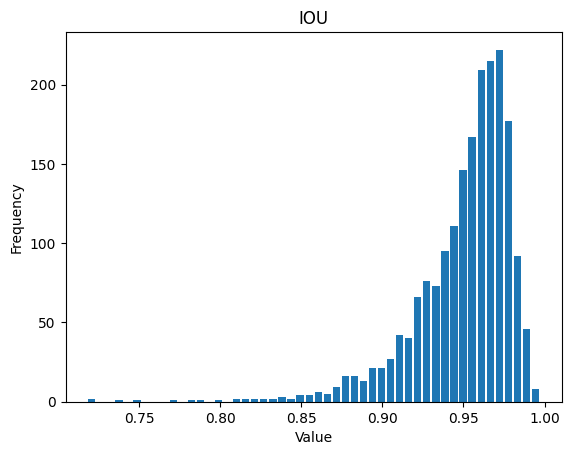

mean: 1.33445410582018e-05
median: 1.3503120231928635e-05
std_deviation: 2.2987716822649764e-06


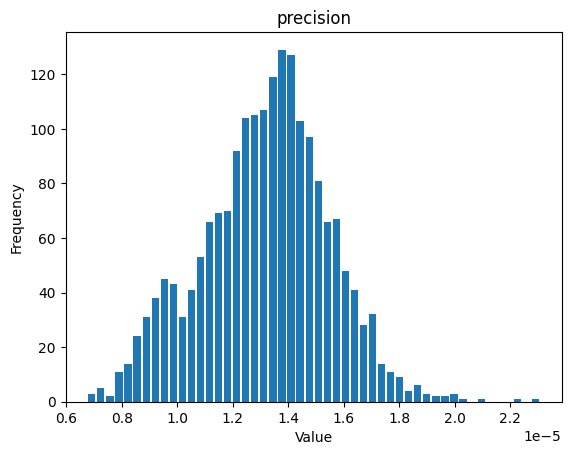

mean: 1.3247259700303397e-05
median: 1.3350741875072179e-05
std_deviation: 2.3056891144264357e-06


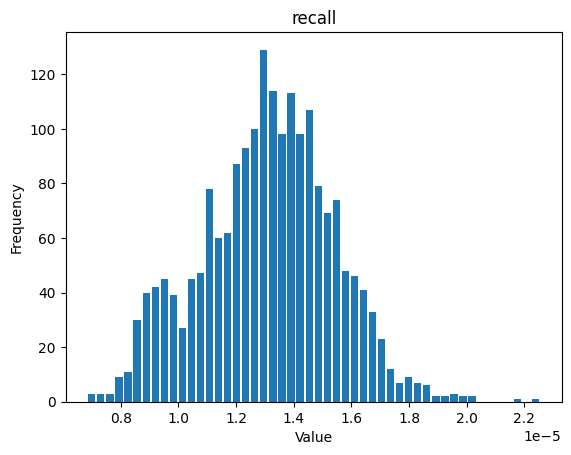

mean: 1.3292044772146525e-05
median: 1.342002292249174e-05
std_deviation: 2.2916737782245687e-06


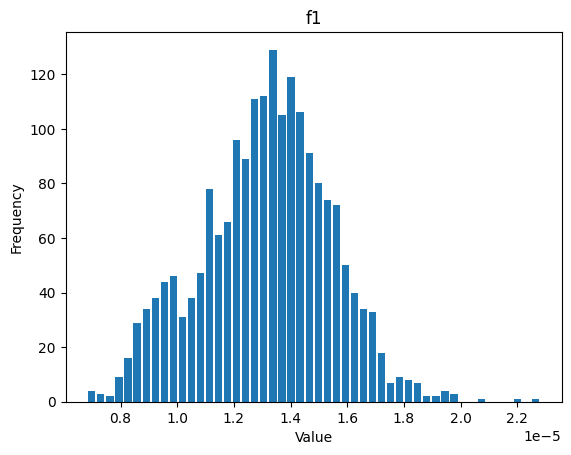

In [4]:
# FILL
shape = (256, 256)
detector = "retinaface"
ignore_poorly_illuminated = True
BUAA_pth = "data/BUAA/BUAAVISNIR"

bm_on_retina = face_detection_benchmark_on_BUAA(detector, shape, ignore_poorly_illuminated, BUAA_pth)
vl_fps, ni_fps, vl_faces, ni_faces, ious, precisions, recalls, f1s = bm_on_retina    

## Benchmark on CenterFace

[]
['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', '40.bmp', '41.bmp', '42.bmp', '43.bmp', '44.bmp']
---------- # 0 ----------
data/BUAA/BUAAVISNIR/19/1.bmp
data/BUAA/BUAAVISNIR/19/2.bmp
cpu times =  0:00:00.187149
cpu times =  0:00:00.117492
iou 0.8855416
f1 1.3285829030220423e-05
prec 1.3720181e-05
rec 1.2878134e-05
---------- # 1 ----------
data/BUAA/BUAAVISNIR/19/3.bmp
data/BUAA/BUAAVISNIR/19/4.bmp
cpu times =  0:00:00.182101
cpu times =  0:00:00.072531
iou 0.882996
f1 1.2984992320455027e-05
prec 1.2865421e-05
rec 1.3106806e-05
---------- # 2 ----------
data/BUAA/BUAAVISNIR/19/5.bmp
data/BUAA/BUAAVISNIR/19/6.bmp
cpu times =  0:00:00.208466
cpu times =  0:00:00.125988
iou 0.96409065
f1 1.378553

['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', '40.bmp', '41.bmp', '42.bmp', '43.bmp', '44.bmp']
---------- # 26 ----------
data/BUAA/BUAAVISNIR/90/1.bmp
data/BUAA/BUAAVISNIR/90/2.bmp
cpu times =  0:00:00.096863
cpu times =  0:00:00.064122
iou 0.9507052
f1 1.3183953165123614e-05
prec 1.28590045e-05
rec 1.3525752e-05
---------- # 27 ----------
data/BUAA/BUAAVISNIR/90/3.bmp
data/BUAA/BUAAVISNIR/90/4.bmp
cpu times =  0:00:00.106668
cpu times =  0:00:00.068886
iou 0.9315757
f1 1.3359603296193862e-05
prec 1.3736739e-05
rec 1.3002623e-05
---------- # 28 ----------
data/BUAA/BUAAVISNIR/90/5.bmp
data/BUAA/BUAAVISNIR/90/6.bmp
cpu times =  0:00:00.127123
cpu times =  0:00:00.114821
iou 0.958444
f1 1.272064

cpu times =  0:00:00.075258
cpu times =  0:00:00.071739
iou 0.939237
f1 1.444721843044865e-05
prec 1.4127754e-05
rec 1.47814635e-05
---------- # 54 ----------
data/BUAA/BUAAVISNIR/94/5.bmp
data/BUAA/BUAAVISNIR/94/6.bmp
cpu times =  0:00:00.100179
cpu times =  0:00:00.075829
iou 0.91520107
f1 1.3704809960857685e-05
prec 1.3638646e-05
rec 1.3771621e-05
---------- # 55 ----------
data/BUAA/BUAAVISNIR/94/7.bmp
data/BUAA/BUAAVISNIR/94/8.bmp
cpu times =  0:00:00.084142
cpu times =  0:00:00.065634
iou 0.9407197
f1 1.4330848010693016e-05
prec 1.4435154e-05
rec 1.4228038e-05
---------- # 56 ----------
data/BUAA/BUAAVISNIR/94/9.bmp
data/BUAA/BUAAVISNIR/94/10.bmp
cpu times =  0:00:00.094135
cpu times =  0:00:00.050883
iou 0.93865514
f1 1.433265750383686e-05
prec 1.4590949e-05
rec 1.4083351e-05
---------- # 57 ----------
data/BUAA/BUAAVISNIR/94/11.bmp
data/BUAA/BUAAVISNIR/94/12.bmp
cpu times =  0:00:00.074246
cpu times =  0:00:00.059955
iou 0.8578892
f1 1.3687229864619704e-05
prec 1.27146795e-05
r

cpu times =  0:00:00.066959
iou 0.94621676
f1 1.6109840004719314e-05
prec 1.5676622e-05
rec 1.6567685e-05
---------- # 80 ----------
data/BUAA/BUAAVISNIR/122/5.bmp
data/BUAA/BUAAVISNIR/122/6.bmp
cpu times =  0:00:00.080610
cpu times =  0:00:00.058566
iou 0.9726961
f1 1.679960256773693e-05
prec 1.698205e-05
rec 1.6621032e-05
---------- # 81 ----------
data/BUAA/BUAAVISNIR/122/7.bmp
data/BUAA/BUAAVISNIR/122/8.bmp
cpu times =  0:00:00.070200
cpu times =  0:00:00.039766
iou 0.9713605
f1 1.6219984210675725e-05
prec 1.5987718e-05
rec 1.6459097e-05
---------- # 82 ----------
data/BUAA/BUAAVISNIR/122/9.bmp
data/BUAA/BUAAVISNIR/122/10.bmp
cpu times =  0:00:00.091969
cpu times =  0:00:00.075837
iou 0.9714126
f1 1.7751482101044463e-05
prec 1.7929338e-05
rec 1.757712e-05
---------- # 83 ----------
data/BUAA/BUAAVISNIR/122/11.bmp
data/BUAA/BUAAVISNIR/122/12.bmp
cpu times =  0:00:00.113063
cpu times =  0:00:00.071619
iou 0.96187395
f1 1.6921803801745442e-05
prec 1.6599224e-05
rec 1.725717e-05
------

cpu times =  0:00:00.198909
cpu times =  0:00:00.138613
iou 0.9680977
f1 1.6821821402326575e-05
prec 1.7098992e-05
rec 1.6553495e-05
---------- # 106 ----------
data/BUAA/BUAAVISNIR/108/5.bmp
data/BUAA/BUAAVISNIR/108/6.bmp
cpu times =  0:00:00.146507
cpu times =  0:00:00.064166
iou 0.9724236
f1 1.6401494198269212e-05
prec 1.6181559e-05
rec 1.662749e-05
---------- # 107 ----------
data/BUAA/BUAAVISNIR/108/7.bmp
data/BUAA/BUAAVISNIR/108/8.bmp
cpu times =  0:00:00.161107
cpu times =  0:00:00.129130
iou 0.9654265
f1 1.608588332457118e-05
prec 1.580781e-05
rec 1.6373915e-05
---------- # 108 ----------
data/BUAA/BUAAVISNIR/108/9.bmp
data/BUAA/BUAAVISNIR/108/10.bmp
cpu times =  0:00:00.168850
cpu times =  0:00:00.090210
iou 0.9652362
f1 1.618417652600738e-05
prec 1.5902864e-05
rec 1.647562e-05
---------- # 109 ----------
data/BUAA/BUAAVISNIR/108/11.bmp
data/BUAA/BUAAVISNIR/108/12.bmp
cpu times =  0:00:00.134731
cpu times =  0:00:00.070992
iou 0.88281876
f1 1.563594388148304e-05
prec 1.5768463

cpu times =  0:00:00.108642
cpu times =  0:00:00.076227
iou 0.9401372
f1 1.5027912221125312e-05
prec 1.5124529e-05
rec 1.49325215e-05
---------- # 132 ----------
data/BUAA/BUAAVISNIR/72/5.bmp
data/BUAA/BUAAVISNIR/72/6.bmp
cpu times =  0:00:00.119587
cpu times =  0:00:00.084454
iou 0.8792588
f1 1.4605418177834764e-05
prec 1.4526984e-05
rec 1.4684703e-05
---------- # 133 ----------
data/BUAA/BUAAVISNIR/72/7.bmp
data/BUAA/BUAAVISNIR/72/8.bmp
cpu times =  0:00:00.138160
cpu times =  0:00:00.084268
iou 0.9358117
f1 1.6898091298384183e-05
prec 1.6854943e-05
rec 1.694146e-05
---------- # 134 ----------
data/BUAA/BUAAVISNIR/72/9.bmp
data/BUAA/BUAAVISNIR/72/10.bmp
cpu times =  0:00:00.096165
cpu times =  0:00:00.062281
iou 0.9115542
f1 1.401778604819303e-05
prec 1.4209285e-05
rec 1.3831382e-05
---------- # 135 ----------
data/BUAA/BUAAVISNIR/72/11.bmp
data/BUAA/BUAAVISNIR/72/12.bmp
cpu times =  0:00:00.126061
cpu times =  0:00:00.076063
iou 0.9762232
f1 1.6358385730931982e-05
prec 1.6524518e-05

cpu times =  0:00:00.107580
cpu times =  0:00:00.046149
iou 0.96166134
f1 9.971226883886566e-06
prec 9.788312e-06
rec 1.0161109e-05
---------- # 158 ----------
data/BUAA/BUAAVISNIR/22/5.bmp
data/BUAA/BUAAVISNIR/22/6.bmp
cpu times =  0:00:00.072514
cpu times =  0:00:00.045355
iou 0.91534895
f1 9.846034872688123e-06
prec 9.429296e-06
rec 1.03013135e-05
---------- # 159 ----------
data/BUAA/BUAAVISNIR/22/7.bmp
data/BUAA/BUAAVISNIR/22/8.bmp
cpu times =  0:00:00.070450
cpu times =  0:00:00.047196
iou 0.9171295
f1 1.0052021619804015e-05
prec 9.695727e-06
rec 1.0435501e-05
---------- # 160 ----------
data/BUAA/BUAAVISNIR/22/9.bmp
data/BUAA/BUAAVISNIR/22/10.bmp
cpu times =  0:00:00.097197
cpu times =  0:00:00.044024
iou 0.8464154
f1 9.653328507099218e-06
prec 8.912027e-06
rec 1.052914e-05
---------- # 161 ----------
data/BUAA/BUAAVISNIR/22/11.bmp
data/BUAA/BUAAVISNIR/22/12.bmp
cpu times =  0:00:00.074905
cpu times =  0:00:00.045135
iou 0.87946975
f1 9.575239918259862e-06
prec 8.998187e-06
rec 

cpu times =  0:00:00.096794
cpu times =  0:00:00.064203
iou 0.9397791
f1 1.458811018196862e-05
prec 1.4833538e-05
rec 1.435067e-05
---------- # 184 ----------
data/BUAA/BUAAVISNIR/71/5.bmp
data/BUAA/BUAAVISNIR/71/6.bmp
cpu times =  0:00:00.077408
cpu times =  0:00:00.045181
iou 0.9426976
f1 1.4977644117822545e-05
prec 1.4638985e-05
rec 1.5332344e-05
---------- # 185 ----------
data/BUAA/BUAAVISNIR/71/7.bmp
data/BUAA/BUAAVISNIR/71/8.bmp
cpu times =  0:00:00.113953
cpu times =  0:00:00.068600
iou 0.9423175
f1 1.4242227640757053e-05
prec 1.4241748e-05
rec 1.4242707e-05
---------- # 186 ----------
data/BUAA/BUAAVISNIR/71/9.bmp
data/BUAA/BUAAVISNIR/71/10.bmp
cpu times =  0:00:00.102080
cpu times =  0:00:00.061239
iou 0.9414343
f1 1.472219692740383e-05
prec 1.48063355e-05
rec 1.46390075e-05
---------- # 187 ----------
data/BUAA/BUAAVISNIR/71/11.bmp
data/BUAA/BUAAVISNIR/71/12.bmp
cpu times =  0:00:00.103727
cpu times =  0:00:00.063050
iou 0.8407643
f1 1.2761881942276029e-05
prec 1.1745808e-05

cpu times =  0:00:00.104573
cpu times =  0:00:00.070363
iou 0.9344237
f1 1.7172110954745392e-05
prec 1.6803824e-05
rec 1.7556904e-05
---------- # 210 ----------
data/BUAA/BUAAVISNIR/81/5.bmp
data/BUAA/BUAAVISNIR/81/6.bmp
cpu times =  0:00:00.087664
cpu times =  0:00:00.054820
iou 0.94850993
f1 1.7077229648937815e-05
prec 1.7053158e-05
rec 1.710137e-05
---------- # 211 ----------
data/BUAA/BUAAVISNIR/81/7.bmp
data/BUAA/BUAAVISNIR/81/8.bmp
cpu times =  0:00:00.081819
cpu times =  0:00:00.055084
iou 0.93649894
f1 1.5692353358799335e-05
prec 1.5247484e-05
rec 1.6163965e-05
---------- # 212 ----------
data/BUAA/BUAAVISNIR/81/9.bmp
data/BUAA/BUAAVISNIR/81/10.bmp
cpu times =  0:00:00.083732
cpu times =  0:00:00.062287
iou 0.93701446
f1 1.5659706043010803e-05
prec 1.6021622e-05
rec 1.531378e-05
---------- # 213 ----------
data/BUAA/BUAAVISNIR/81/11.bmp
data/BUAA/BUAAVISNIR/81/12.bmp
cpu times =  0:00:00.104523
cpu times =  0:00:00.070480
iou 0.93244475
f1 1.7094426584654973e-05
prec 1.7038206e

cpu times =  0:00:00.046990
iou 0.93584
f1 1.2462596215513402e-05
prec 1.224969e-05
rec 1.2683034e-05
---------- # 236 ----------
data/BUAA/BUAAVISNIR/34/5.bmp
data/BUAA/BUAAVISNIR/34/6.bmp
cpu times =  0:00:00.074396
cpu times =  0:00:00.045692
iou 0.921771
f1 1.1979190403345808e-05
prec 1.1813533e-05
rec 1.214956e-05
---------- # 237 ----------
data/BUAA/BUAAVISNIR/34/7.bmp
data/BUAA/BUAAVISNIR/34/8.bmp
cpu times =  0:00:00.106526
cpu times =  0:00:00.042768
iou 0.97456634
f1 1.2247404900871252e-05
prec 1.2137837e-05
rec 1.2358969e-05
---------- # 238 ----------
data/BUAA/BUAAVISNIR/34/9.bmp
data/BUAA/BUAAVISNIR/34/10.bmp
cpu times =  0:00:00.078248
cpu times =  0:00:00.046446
iou 0.9883245
f1 1.2386056907102106e-05
prec 1.231375e-05
rec 1.2459218e-05
---------- # 239 ----------
data/BUAA/BUAAVISNIR/34/11.bmp
data/BUAA/BUAAVISNIR/34/12.bmp
cpu times =  0:00:00.097800
cpu times =  0:00:00.072285
iou 0.91910976
f1 1.3051307244627697e-05
prec 1.3255134e-05
rec 1.2853654e-05
---------- #

cpu times =  0:00:00.092422
cpu times =  0:00:00.044070
iou 0.9681909
f1 1.3786926395483201e-05
prec 1.4013404e-05
rec 1.3567652e-05
---------- # 262 ----------
data/BUAA/BUAAVISNIR/40/5.bmp
data/BUAA/BUAAVISNIR/40/6.bmp
cpu times =  0:00:00.078950
cpu times =  0:00:00.050447
iou 0.9883677
f1 1.3997162634175299e-05
prec 1.4011388e-05
rec 1.3982965e-05
---------- # 263 ----------
data/BUAA/BUAAVISNIR/40/7.bmp
data/BUAA/BUAAVISNIR/40/8.bmp
cpu times =  0:00:00.076574
cpu times =  0:00:00.044418
iou 0.9363236
f1 1.3824762088075224e-05
prec 1.4178592e-05
rec 1.3488163e-05
---------- # 264 ----------
data/BUAA/BUAAVISNIR/40/9.bmp
data/BUAA/BUAAVISNIR/40/10.bmp
cpu times =  0:00:00.071551
cpu times =  0:00:00.047451
iou 0.91563326
f1 1.286279899483232e-05
prec 1.3060162e-05
rec 1.267131e-05
---------- # 265 ----------
data/BUAA/BUAAVISNIR/40/11.bmp
data/BUAA/BUAAVISNIR/40/12.bmp
cpu times =  0:00:00.072659
cpu times =  0:00:00.048367
iou 0.8889197
f1 1.2793864445592042e-05
prec 1.2633511e-05

cpu times =  0:00:00.129706
cpu times =  0:00:00.061413
iou 0.9641732
f1 1.623702654512686e-05
prec 1.5946167e-05
rec 1.6538697e-05
---------- # 288 ----------
data/BUAA/BUAAVISNIR/46/5.bmp
data/BUAA/BUAAVISNIR/46/6.bmp
cpu times =  0:00:00.107868
cpu times =  0:00:00.064286
iou 0.9926879
f1 1.6952984180468906e-05
prec 1.7015422e-05
rec 1.6891005e-05
---------- # 289 ----------
data/BUAA/BUAAVISNIR/46/7.bmp
data/BUAA/BUAAVISNIR/46/8.bmp
cpu times =  0:00:00.086019
cpu times =  0:00:00.093374
iou 0.95759696
f1 1.566517569444646e-05
prec 1.5626216e-05
rec 1.570433e-05
---------- # 290 ----------
data/BUAA/BUAAVISNIR/46/9.bmp
data/BUAA/BUAAVISNIR/46/10.bmp
cpu times =  0:00:00.132190
cpu times =  0:00:00.116803
iou 0.9595009
f1 1.684734626723069e-05
prec 1.6784817e-05
rec 1.691034e-05
---------- # 291 ----------
data/BUAA/BUAAVISNIR/46/11.bmp
data/BUAA/BUAAVISNIR/46/12.bmp
cpu times =  0:00:00.103764
cpu times =  0:00:00.106473
iou 0.90791976
f1 1.6517048490120788e-05
prec 1.5953856e-05
r

cpu times =  0:00:00.105829
cpu times =  0:00:00.044650
iou 0.95103824
f1 1.5241004845415798e-05
prec 1.5390238e-05
rec 1.5094638e-05
---------- # 314 ----------
data/BUAA/BUAAVISNIR/80/5.bmp
data/BUAA/BUAAVISNIR/80/6.bmp
cpu times =  0:00:00.073688
cpu times =  0:00:00.045536
iou 0.9447821
f1 1.447037348928551e-05
prec 1.4497313e-05
rec 1.4443534e-05
---------- # 315 ----------
data/BUAA/BUAAVISNIR/80/7.bmp
data/BUAA/BUAAVISNIR/80/8.bmp
cpu times =  0:00:00.075716
cpu times =  0:00:00.057458
iou 0.9415641
f1 1.4996769781338673e-05
prec 1.5123221e-05
rec 1.4872417e-05
---------- # 316 ----------
data/BUAA/BUAAVISNIR/80/9.bmp
data/BUAA/BUAAVISNIR/80/10.bmp
cpu times =  0:00:00.100229
cpu times =  0:00:00.048768
iou 0.98375404
f1 1.617722342919662e-05
prec 1.613171e-05
rec 1.6222995e-05
---------- # 317 ----------
data/BUAA/BUAAVISNIR/80/11.bmp
data/BUAA/BUAAVISNIR/80/12.bmp
cpu times =  0:00:00.094847
cpu times =  0:00:00.051847
iou 0.93667316
f1 1.5952351247701463e-05
prec 1.5750706e-0

cpu times =  0:00:00.103518
cpu times =  0:00:00.046184
iou 0.92317367
f1 1.4702137590970912e-05
prec 1.4315664e-05
rec 1.5110056e-05
---------- # 340 ----------
data/BUAA/BUAAVISNIR/89/5.bmp
data/BUAA/BUAAVISNIR/89/6.bmp
cpu times =  0:00:00.074063
cpu times =  0:00:00.045823
iou 0.99183273
f1 1.57736834575027e-05
prec 1.5775135e-05
rec 1.5772232e-05
---------- # 341 ----------
data/BUAA/BUAAVISNIR/89/7.bmp
data/BUAA/BUAAVISNIR/89/8.bmp
cpu times =  0:00:00.076183
cpu times =  0:00:00.045167
iou 0.8881935
f1 1.442931194533813e-05
prec 1.4545719e-05
rec 1.4314753e-05
---------- # 342 ----------
data/BUAA/BUAAVISNIR/89/9.bmp
data/BUAA/BUAAVISNIR/89/10.bmp
cpu times =  0:00:00.101198
cpu times =  0:00:00.043333
iou 0.9383169
f1 1.5197851436401473e-05
prec 1.5299554e-05
rec 1.5097492e-05
---------- # 343 ----------
data/BUAA/BUAAVISNIR/89/11.bmp
data/BUAA/BUAAVISNIR/89/12.bmp
cpu times =  0:00:00.091619
cpu times =  0:00:00.044815
iou 0.988974
f1 1.552084683316313e-05
prec 1.5560441e-05
r

cpu times =  0:00:00.091509
cpu times =  0:00:00.042733
iou 0.8489043
f1 8.81853358477642e-06
prec 8.171765e-06
rec 9.57648e-06
---------- # 367 ----------
data/BUAA/BUAAVISNIR/13/7.bmp
data/BUAA/BUAAVISNIR/13/8.bmp
cpu times =  0:00:00.079756
cpu times =  0:00:00.044992
iou 0.8549204
f1 6.6161280499928815e-06
prec 6.1361957e-06
rec 7.1775053e-06
---------- # 368 ----------
data/BUAA/BUAAVISNIR/13/9.bmp
data/BUAA/BUAAVISNIR/13/10.bmp
cpu times =  0:00:00.102442
cpu times =  0:00:00.048911
iou 0.96593106
f1 8.826107146204384e-06
prec 8.675759e-06
rec 8.981758e-06
---------- # 369 ----------
data/BUAA/BUAAVISNIR/13/11.bmp
data/BUAA/BUAAVISNIR/13/12.bmp
cpu times =  0:00:00.076937
cpu times =  0:00:00.044391
iou 0.93268764
f1 9.21560411541038e-06
prec 8.905442e-06
rec 9.548151e-06
---------- # 370 ----------
data/BUAA/BUAAVISNIR/13/13.bmp
data/BUAA/BUAAVISNIR/13/14.bmp
cpu times =  0:00:00.096287
cpu times =  0:00:00.045133
iou 0.91123843
f1 9.237500089305688e-06
prec 8.920279e-06
rec 9.5

cpu times =  0:00:00.078815
cpu times =  0:00:00.042593
iou 0.9622331
f1 1.6128610381122384e-05
prec 1.6191521e-05
rec 1.6066188e-05
---------- # 394 ----------
data/BUAA/BUAAVISNIR/139/9.bmp
data/BUAA/BUAAVISNIR/139/10.bmp
cpu times =  0:00:00.121822
cpu times =  0:00:00.043095
iou 0.93712854
f1 1.5949797492332462e-05
prec 1.5880225e-05
rec 1.6019982e-05
---------- # 395 ----------
data/BUAA/BUAAVISNIR/139/11.bmp
data/BUAA/BUAAVISNIR/139/12.bmp
cpu times =  0:00:00.099773
cpu times =  0:00:00.043683
iou 0.96460694
f1 1.793606209451388e-05
prec 1.80094e-05
rec 1.786332e-05
---------- # 396 ----------
data/BUAA/BUAAVISNIR/139/13.bmp
data/BUAA/BUAAVISNIR/139/14.bmp
cpu times =  0:00:00.092740
cpu times =  0:00:00.046547
iou 0.95672166
f1 1.583600983719854e-05
prec 1.5785967e-05
rec 1.5886371e-05
---------- # 397 ----------
data/BUAA/BUAAVISNIR/139/15.bmp
data/BUAA/BUAAVISNIR/139/16.bmp
cpu times =  0:00:00.078415
cpu times =  0:00:00.045132
iou 0.94446146
f1 1.7156377795107626e-05
prec 1

cpu times =  0:00:00.045359
iou 0.9686594
f1 1.4249903657842615e-05
prec 1.4480428e-05
rec 1.4026604e-05
---------- # 423 ----------
data/BUAA/BUAAVISNIR/2/25.bmp
data/BUAA/BUAAVISNIR/2/26.bmp
cpu times =  0:00:00.078789
cpu times =  0:00:00.045835
iou 0.8851988
f1 1.2860449612201415e-05
prec 1.3287445e-05
rec 1.2460043e-05
---------- # 424 ----------
data/BUAA/BUAAVISNIR/2/27.bmp
data/BUAA/BUAAVISNIR/2/28.bmp
cpu times =  0:00:00.080353
cpu times =  0:00:00.060185
iou 0.980314
f1 1.3842382056764816e-05
prec 1.3981369e-05
rec 1.3706131e-05
---------- # 425 ----------
data/BUAA/BUAAVISNIR/2/31.bmp
data/BUAA/BUAAVISNIR/2/32.bmp
cpu times =  0:00:00.077305
cpu times =  0:00:00.052289
iou 0.7293755
f1 7.444193574954189e-06
prec 8.685515e-06
rec 6.513319e-06
---------- # 426 ----------
data/BUAA/BUAAVISNIR/2/33.bmp
data/BUAA/BUAAVISNIR/2/34.bmp
cpu times =  0:00:00.090415
cpu times =  0:00:00.045062
iou 0.916927
f1 1.0782314738594343e-05
prec 1.0685038e-05
rec 1.0881378e-05
---------- # 427

cpu times =  0:00:00.079029
cpu times =  0:00:00.045173
iou 0.9209209
f1 1.3428951193242704e-05
prec 1.38746345e-05
rec 1.3011009e-05
---------- # 452 ----------
data/BUAA/BUAAVISNIR/106/23.bmp
data/BUAA/BUAAVISNIR/106/24.bmp
cpu times =  0:00:00.075176
cpu times =  0:00:00.059260
iou 0.95950764
f1 1.5640337714925817e-05
prec 1.5660451e-05
rec 1.5620277e-05
---------- # 453 ----------
data/BUAA/BUAAVISNIR/106/25.bmp
data/BUAA/BUAAVISNIR/106/26.bmp
cpu times =  0:00:00.082938
cpu times =  0:00:00.043783
iou 0.92632765
f1 1.47218933393938e-05
prec 1.4368856e-05
rec 1.5092715e-05
---------- # 454 ----------
data/BUAA/BUAAVISNIR/106/27.bmp
data/BUAA/BUAAVISNIR/106/28.bmp
cpu times =  0:00:00.096335
cpu times =  0:00:00.043036
iou 0.8997927
f1 1.4383101153706768e-05
prec 1.4472791e-05
rec 1.42945155e-05
---------- # 455 ----------
data/BUAA/BUAAVISNIR/106/31.bmp
data/BUAA/BUAAVISNIR/106/32.bmp
== ignoring poorly illuminated ==
---------- # 455 ----------
data/BUAA/BUAAVISNIR/106/33.bmp
data

cpu times =  0:00:00.098092
cpu times =  0:00:00.042111
iou 0.94604295
f1 1.2084307052753923e-05
prec 1.2001238e-05
rec 1.2168535e-05
---------- # 478 ----------
data/BUAA/BUAAVISNIR/33/23.bmp
data/BUAA/BUAAVISNIR/33/24.bmp
cpu times =  0:00:00.066673
cpu times =  0:00:00.049756
iou 0.9265289
f1 1.2652397222611864e-05
prec 1.2291335e-05
rec 1.3035313e-05
---------- # 479 ----------
data/BUAA/BUAAVISNIR/33/25.bmp
data/BUAA/BUAAVISNIR/33/26.bmp
cpu times =  0:00:00.093021
cpu times =  0:00:00.050469
iou 0.96806693
f1 1.2898093253723788e-05
prec 1.2795542e-05
rec 1.3002304e-05
---------- # 480 ----------
data/BUAA/BUAAVISNIR/33/27.bmp
data/BUAA/BUAAVISNIR/33/28.bmp
cpu times =  0:00:00.073958
cpu times =  0:00:00.048680
iou 0.9472358
f1 1.1737984774877686e-05
prec 1.1767923e-05
rec 1.1708198e-05
---------- # 481 ----------
data/BUAA/BUAAVISNIR/33/31.bmp
data/BUAA/BUAAVISNIR/33/32.bmp
== ignoring poorly illuminated ==
---------- # 481 ----------
data/BUAA/BUAAVISNIR/33/33.bmp
data/BUAA/BUA

cpu times =  0:00:00.051427
iou 0.9907363
f1 1.4506299463975769e-05
prec 1.4546251e-05
rec 1.44665655e-05
---------- # 504 ----------
data/BUAA/BUAAVISNIR/59/23.bmp
data/BUAA/BUAAVISNIR/59/24.bmp
cpu times =  0:00:00.072166
cpu times =  0:00:00.044241
iou 0.93884844
f1 1.4605260928410617e-05
prec 1.45160275e-05
rec 1.4695597e-05
---------- # 505 ----------
data/BUAA/BUAAVISNIR/59/25.bmp
data/BUAA/BUAAVISNIR/59/26.bmp
cpu times =  0:00:00.080666
cpu times =  0:00:00.043214
iou 0.9493453
f1 1.4722299193641044e-05
prec 1.4797842e-05
rec 1.4647525e-05
---------- # 506 ----------
data/BUAA/BUAAVISNIR/59/27.bmp
data/BUAA/BUAAVISNIR/59/28.bmp
cpu times =  0:00:00.082007
cpu times =  0:00:00.042864
iou 0.97665817
f1 1.4358037134020646e-05
prec 1.4190467e-05
rec 1.45296135e-05
---------- # 507 ----------
data/BUAA/BUAAVISNIR/59/31.bmp
data/BUAA/BUAAVISNIR/59/32.bmp
== ignoring poorly illuminated ==
---------- # 507 ----------
data/BUAA/BUAAVISNIR/59/33.bmp
data/BUAA/BUAAVISNIR/59/34.bmp
== igno

cpu times =  0:00:00.091938
cpu times =  0:00:00.055171
iou 0.9558008
f1 1.4507724943939182e-05
prec 1.4592816e-05
rec 1.4423622e-05
---------- # 530 ----------
data/BUAA/BUAAVISNIR/86/23.bmp
data/BUAA/BUAAVISNIR/86/24.bmp
cpu times =  0:00:00.095535
cpu times =  0:00:00.060078
iou 0.9725171
f1 1.447117775527709e-05
prec 1.45427375e-05
rec 1.4400317e-05
---------- # 531 ----------
data/BUAA/BUAAVISNIR/86/25.bmp
data/BUAA/BUAAVISNIR/86/26.bmp
cpu times =  0:00:00.099642
cpu times =  0:00:00.056841
iou 0.9595141
f1 1.3120870090798818e-05
prec 1.3086793e-05
rec 1.3155125e-05
---------- # 532 ----------
data/BUAA/BUAAVISNIR/86/27.bmp
data/BUAA/BUAAVISNIR/86/28.bmp
cpu times =  0:00:00.098165
cpu times =  0:00:00.052063
iou 0.9664872
f1 1.4043210071632011e-05
prec 1.3807897e-05
rec 1.4286684e-05
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/31.bmp
data/BUAA/BUAAVISNIR/86/32.bmp
== ignoring poorly illuminated ==
---------- # 533 ----------
data/BUAA/BUAAVISNIR/86/33.bmp
data/BUAA/BUAAV

cpu times =  0:00:00.079348
cpu times =  0:00:00.077445
iou 0.9648593
f1 1.50802085917692e-05
prec 1.52375105e-05
rec 1.4926121e-05
---------- # 556 ----------
data/BUAA/BUAAVISNIR/150/23.bmp
data/BUAA/BUAAVISNIR/150/24.bmp
cpu times =  0:00:00.104870
cpu times =  0:00:00.045965
iou 0.95266485
f1 1.476534678065558e-05
prec 1.4894369e-05
rec 1.4638542e-05
---------- # 557 ----------
data/BUAA/BUAAVISNIR/150/25.bmp
data/BUAA/BUAAVISNIR/150/26.bmp
cpu times =  0:00:00.082056
cpu times =  0:00:00.060818
iou 0.9463516
f1 1.4478289766450048e-05
prec 1.4881064e-05
rec 1.4096743e-05
---------- # 558 ----------
data/BUAA/BUAAVISNIR/150/27.bmp
data/BUAA/BUAAVISNIR/150/28.bmp
cpu times =  0:00:00.074789
cpu times =  0:00:00.046793
iou 0.9224828
f1 1.3842026433984786e-05
prec 1.4168156e-05
rec 1.3530574e-05
---------- # 559 ----------
data/BUAA/BUAAVISNIR/150/31.bmp
data/BUAA/BUAAVISNIR/150/32.bmp
== ignoring poorly illuminated ==
---------- # 559 ----------
data/BUAA/BUAAVISNIR/150/33.bmp
data/BU

cpu times =  0:00:00.054898
iou 0.91800284
f1 1.2656401582397189e-05
prec 1.3041469e-05
rec 1.2293422e-05
---------- # 582 ----------
data/BUAA/BUAAVISNIR/110/23.bmp
data/BUAA/BUAAVISNIR/110/24.bmp
cpu times =  0:00:00.071943
cpu times =  0:00:00.049951
iou 0.9958306
f1 1.3661851909841241e-05
prec 1.3690454e-05
rec 1.363337e-05
---------- # 583 ----------
data/BUAA/BUAAVISNIR/110/25.bmp
data/BUAA/BUAAVISNIR/110/26.bmp
cpu times =  0:00:00.072962
cpu times =  0:00:00.053507
iou 0.9337728
f1 1.3529021478252557e-05
prec 1.381853e-05
rec 1.3251397e-05
---------- # 584 ----------
data/BUAA/BUAAVISNIR/110/27.bmp
data/BUAA/BUAAVISNIR/110/28.bmp
cpu times =  0:00:00.072272
cpu times =  0:00:00.041265
iou 0.92864305
f1 1.260075545460602e-05
prec 1.30848775e-05
rec 1.2151179e-05
---------- # 585 ----------
data/BUAA/BUAAVISNIR/110/31.bmp
data/BUAA/BUAAVISNIR/110/32.bmp
== ignoring poorly illuminated ==
---------- # 585 ----------
data/BUAA/BUAAVISNIR/110/33.bmp
data/BUAA/BUAAVISNIR/110/34.bmp
==

cpu times =  0:00:00.058632
cpu times =  0:00:00.048628
iou 0.98365
f1 1.7141501570921566e-05
prec 1.700137e-05
rec 1.7283961e-05
---------- # 609 ----------
data/BUAA/BUAAVISNIR/147/25.bmp
data/BUAA/BUAAVISNIR/147/26.bmp
cpu times =  0:00:00.061681
cpu times =  0:00:00.045093
iou 0.96465534
f1 1.7036293098405542e-05
prec 1.7035312e-05
rec 1.7037275e-05
---------- # 610 ----------
data/BUAA/BUAAVISNIR/147/27.bmp
data/BUAA/BUAAVISNIR/147/28.bmp
cpu times =  0:00:00.089688
cpu times =  0:00:00.044247
iou 0.9100163
f1 1.8306120649738142e-05
prec 1.921119e-05
rec 1.7482496e-05
---------- # 611 ----------
data/BUAA/BUAAVISNIR/147/31.bmp
data/BUAA/BUAAVISNIR/147/32.bmp
== ignoring poorly illuminated ==
---------- # 611 ----------
data/BUAA/BUAAVISNIR/147/33.bmp
data/BUAA/BUAAVISNIR/147/34.bmp
== ignoring poorly illuminated ==
---------- # 611 ----------
data/BUAA/BUAAVISNIR/147/35.bmp
data/BUAA/BUAAVISNIR/147/36.bmp
== ignoring poorly illuminated ==
---------- # 611 ----------
data/BUAA/BUAA

cpu times =  0:00:00.108374
cpu times =  0:00:00.061813
iou 0.96118057
f1 1.5292523522760396e-05
prec 1.4995699e-05
rec 1.5601334e-05
---------- # 635 ----------
data/BUAA/BUAAVISNIR/62/25.bmp
data/BUAA/BUAAVISNIR/62/26.bmp
cpu times =  0:00:00.106240
cpu times =  0:00:00.065342
iou 0.9390394
f1 1.4960946529165955e-05
prec 1.4800127e-05
rec 1.5125299e-05
---------- # 636 ----------
data/BUAA/BUAAVISNIR/62/27.bmp
data/BUAA/BUAAVISNIR/62/28.bmp
cpu times =  0:00:00.125977
cpu times =  0:00:00.081193
iou 0.9778691
f1 1.603407705180512e-05
prec 1.5856653e-05
rec 1.6215516e-05
---------- # 637 ----------
data/BUAA/BUAAVISNIR/62/31.bmp
data/BUAA/BUAAVISNIR/62/32.bmp
== ignoring poorly illuminated ==
---------- # 637 ----------
data/BUAA/BUAAVISNIR/62/33.bmp
data/BUAA/BUAAVISNIR/62/34.bmp
== ignoring poorly illuminated ==
---------- # 637 ----------
data/BUAA/BUAAVISNIR/62/35.bmp
data/BUAA/BUAAVISNIR/62/36.bmp
== ignoring poorly illuminated ==
---------- # 637 ----------
data/BUAA/BUAAVISNIR/

cpu times =  0:00:00.045318
iou 0.94087887
f1 1.4018799277187279e-05
prec 1.4215449e-05
rec 1.3827516e-05
---------- # 661 ----------
data/BUAA/BUAAVISNIR/29/25.bmp
data/BUAA/BUAAVISNIR/29/26.bmp
cpu times =  0:00:00.073531
cpu times =  0:00:00.043130
iou 0.927647
f1 1.5175373760072013e-05
prec 1.4922076e-05
rec 1.543742e-05
---------- # 662 ----------
data/BUAA/BUAAVISNIR/29/27.bmp
data/BUAA/BUAAVISNIR/29/28.bmp
cpu times =  0:00:00.080950
cpu times =  0:00:00.042970
iou 0.94032496
f1 1.4372851851467878e-05
prec 1.4392095e-05
rec 1.435366e-05
---------- # 663 ----------
data/BUAA/BUAAVISNIR/29/31.bmp
data/BUAA/BUAAVISNIR/29/32.bmp
== ignoring poorly illuminated ==
---------- # 663 ----------
data/BUAA/BUAAVISNIR/29/33.bmp
data/BUAA/BUAAVISNIR/29/34.bmp
== ignoring poorly illuminated ==
---------- # 663 ----------
data/BUAA/BUAAVISNIR/29/35.bmp
data/BUAA/BUAAVISNIR/29/36.bmp
== ignoring poorly illuminated ==
---------- # 663 ----------
data/BUAA/BUAAVISNIR/29/37.bmp
data/BUAA/BUAAVISNI

cpu times =  0:00:00.072957
cpu times =  0:00:00.047929
iou 0.9038622
f1 1.4389007357280266e-05
prec 1.3938072e-05
rec 1.48700965e-05
---------- # 688 ----------
data/BUAA/BUAAVISNIR/93/27.bmp
data/BUAA/BUAAVISNIR/93/28.bmp
cpu times =  0:00:00.071662
cpu times =  0:00:00.046761
iou 0.93681437
f1 1.4623805249792494e-05
prec 1.4161798e-05
rec 1.51169725e-05
---------- # 689 ----------
data/BUAA/BUAAVISNIR/93/31.bmp
data/BUAA/BUAAVISNIR/93/32.bmp
== ignoring poorly illuminated ==
---------- # 689 ----------
data/BUAA/BUAAVISNIR/93/33.bmp
data/BUAA/BUAAVISNIR/93/34.bmp
== ignoring poorly illuminated ==
---------- # 689 ----------
data/BUAA/BUAAVISNIR/93/35.bmp
data/BUAA/BUAAVISNIR/93/36.bmp
== ignoring poorly illuminated ==
---------- # 689 ----------
data/BUAA/BUAAVISNIR/93/37.bmp
data/BUAA/BUAAVISNIR/93/38.bmp
== ignoring poorly illuminated ==
---------- # 689 ----------
data/BUAA/BUAAVISNIR/93/39.bmp
data/BUAA/BUAAVISNIR/93/40.bmp
== ignoring poorly illuminated ==
---------- # 689 ----

cpu times =  0:00:00.061232
iou 0.8827439
f1 1.5260189117216133e-05
prec 1.4994812e-05
rec 1.5535128e-05
---------- # 714 ----------
data/BUAA/BUAAVISNIR/84/27.bmp
data/BUAA/BUAAVISNIR/84/28.bmp
cpu times =  0:00:00.106769
cpu times =  0:00:00.074713
iou 0.9354867
f1 1.522052101861343e-05
prec 1.5451331e-05
rec 1.4996504e-05
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/31.bmp
data/BUAA/BUAAVISNIR/84/32.bmp
== ignoring poorly illuminated ==
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/33.bmp
data/BUAA/BUAAVISNIR/84/34.bmp
== ignoring poorly illuminated ==
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/35.bmp
data/BUAA/BUAAVISNIR/84/36.bmp
== ignoring poorly illuminated ==
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/37.bmp
data/BUAA/BUAAVISNIR/84/38.bmp
== ignoring poorly illuminated ==
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/39.bmp
data/BUAA/BUAAVISNIR/84/40.bmp
== ignoring poorly illuminated ==
---------- # 715 ----------
data/BUAA/BUAAVISNIR/84/4

cpu times =  0:00:00.091459
cpu times =  0:00:00.044663
iou 0.9612281
f1 1.6505149030501636e-05
prec 1.618518e-05
rec 1.6838023e-05
---------- # 740 ----------
data/BUAA/BUAAVISNIR/76/27.bmp
data/BUAA/BUAAVISNIR/76/28.bmp
cpu times =  0:00:00.088973
cpu times =  0:00:00.056961
iou 0.9606491
f1 1.6518763115342632e-05
prec 1.6491253e-05
rec 1.6546363e-05
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/31.bmp
data/BUAA/BUAAVISNIR/76/32.bmp
== ignoring poorly illuminated ==
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/33.bmp
data/BUAA/BUAAVISNIR/76/34.bmp
== ignoring poorly illuminated ==
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/35.bmp
data/BUAA/BUAAVISNIR/76/36.bmp
== ignoring poorly illuminated ==
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/37.bmp
data/BUAA/BUAAVISNIR/76/38.bmp
== ignoring poorly illuminated ==
---------- # 741 ----------
data/BUAA/BUAAVISNIR/76/39.bmp
data/BUAA/BUAAVISNIR/76/40.bmp
== ignoring poorly illuminated ==
---------- # 741 --------

cpu times =  0:00:00.075426
cpu times =  0:00:00.053215
iou 0.9716435
f1 1.3130189769191837e-05
prec 1.3183177e-05
rec 1.3077628e-05
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/31.bmp
data/BUAA/BUAAVISNIR/41/32.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/33.bmp
data/BUAA/BUAAVISNIR/41/34.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/35.bmp
data/BUAA/BUAAVISNIR/41/36.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/37.bmp
data/BUAA/BUAAVISNIR/41/38.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/39.bmp
data/BUAA/BUAAVISNIR/41/40.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/41.bmp
data/BUAA/BUAAVISNIR/41/42.bmp
== ignoring poorly illuminated ==
---------- # 767 ----------
data/BUAA/BUAAVISNIR/41/43.bmp
data/BUAA/BUAAVISNIR/41/44.bmp
== ignoring poorly illuminated ==

cpu times =  0:00:00.098404
cpu times =  0:00:00.061153
iou 0.8836605
f1 1.2460932379882175e-05
prec 1.2933331e-05
rec 1.20218265e-05
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/31.bmp
data/BUAA/BUAAVISNIR/65/32.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/33.bmp
data/BUAA/BUAAVISNIR/65/34.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/35.bmp
data/BUAA/BUAAVISNIR/65/36.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/37.bmp
data/BUAA/BUAAVISNIR/65/38.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/39.bmp
data/BUAA/BUAAVISNIR/65/40.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/41.bmp
data/BUAA/BUAAVISNIR/65/42.bmp
== ignoring poorly illuminated ==
---------- # 793 ----------
data/BUAA/BUAAVISNIR/65/43.bmp
data/BUAA/BUAAVISNIR/65/44.bmp
== ignoring poorly illuminated =

cpu times =  0:00:00.140696
cpu times =  0:00:00.074944
iou 0.9538782
f1 1.5132188780119616e-05
prec 1.533619e-05
rec 1.4933543e-05
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/31.bmp
data/BUAA/BUAAVISNIR/101/32.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/33.bmp
data/BUAA/BUAAVISNIR/101/34.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/35.bmp
data/BUAA/BUAAVISNIR/101/36.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/37.bmp
data/BUAA/BUAAVISNIR/101/38.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/39.bmp
data/BUAA/BUAAVISNIR/101/40.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/41.bmp
data/BUAA/BUAAVISNIR/101/42.bmp
== ignoring poorly illuminated ==
---------- # 819 ----------
data/BUAA/BUAAVISNIR/101/43.bmp
data/BUAA/BUAAVISNIR/101/44.bmp
== ignoring poorly i

cpu times =  0:00:00.056380
iou 0.97824985
f1 1.4699137949164517e-05
prec 1.4719811e-05
rec 1.4678524e-05
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/31.bmp
data/BUAA/BUAAVISNIR/98/32.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/33.bmp
data/BUAA/BUAAVISNIR/98/34.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/35.bmp
data/BUAA/BUAAVISNIR/98/36.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/37.bmp
data/BUAA/BUAAVISNIR/98/38.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/39.bmp
data/BUAA/BUAAVISNIR/98/40.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/41.bmp
data/BUAA/BUAAVISNIR/98/42.bmp
== ignoring poorly illuminated ==
---------- # 845 ----------
data/BUAA/BUAAVISNIR/98/43.bmp
data/BUAA/BUAAVISNIR/98/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.bmp', '3.bmp'

cpu times =  0:00:00.053975
iou 0.89509016
f1 1.2209114424584794e-05
prec 1.2009271e-05
rec 1.241572e-05
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/31.bmp
data/BUAA/BUAAVISNIR/104/32.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/33.bmp
data/BUAA/BUAAVISNIR/104/34.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/35.bmp
data/BUAA/BUAAVISNIR/104/36.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/37.bmp
data/BUAA/BUAAVISNIR/104/38.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/39.bmp
data/BUAA/BUAAVISNIR/104/40.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/41.bmp
data/BUAA/BUAAVISNIR/104/42.bmp
== ignoring poorly illuminated ==
---------- # 871 ----------
data/BUAA/BUAAVISNIR/104/43.bmp
data/BUAA/BUAAVISNIR/104/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.

cpu times =  0:00:00.084621
iou 0.873681
f1 1.5406999982303696e-05
prec 1.5360747e-05
rec 1.5453536e-05
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/31.bmp
data/BUAA/BUAAVISNIR/133/32.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/33.bmp
data/BUAA/BUAAVISNIR/133/34.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/35.bmp
data/BUAA/BUAAVISNIR/133/36.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/37.bmp
data/BUAA/BUAAVISNIR/133/38.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/39.bmp
data/BUAA/BUAAVISNIR/133/40.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/41.bmp
data/BUAA/BUAAVISNIR/133/42.bmp
== ignoring poorly illuminated ==
---------- # 897 ----------
data/BUAA/BUAAVISNIR/133/43.bmp
data/BUAA/BUAAVISNIR/133/44.bmp
== ignoring poorly illuminated ==
['1.bmp', '2.b

['1.bmp', '2.bmp', '3.bmp', '4.bmp', '5.bmp', '6.bmp', '7.bmp', '8.bmp', '9.bmp', '10.bmp', '11.bmp', '12.bmp', '13.bmp', '14.bmp', '15.bmp', '16.bmp', '17.bmp', '18.bmp', '21.bmp', '22.bmp', '23.bmp', '24.bmp', '25.bmp', '26.bmp', '27.bmp', '28.bmp', '31.bmp', '32.bmp', '33.bmp', '34.bmp', '35.bmp', '36.bmp', '37.bmp', '38.bmp', '39.bmp', '40.bmp', '41.bmp', '42.bmp', '43.bmp', '44.bmp']
---------- # 923 ----------
data/BUAA/BUAAVISNIR/28/1.bmp
data/BUAA/BUAAVISNIR/28/2.bmp
cpu times =  0:00:00.093805
cpu times =  0:00:00.047983
iou 0.95969254
f1 1.4472230109016556e-05
prec 1.4274446e-05
rec 1.4675573e-05
---------- # 924 ----------
data/BUAA/BUAAVISNIR/28/3.bmp
data/BUAA/BUAAVISNIR/28/4.bmp
cpu times =  0:00:00.068098
cpu times =  0:00:00.039560
iou 0.9788111
f1 1.4827192902489654e-05
prec 1.4713457e-05
rec 1.4942701e-05
---------- # 925 ----------
data/BUAA/BUAAVISNIR/28/5.bmp
data/BUAA/BUAAVISNIR/28/6.bmp
cpu times =  0:00:00.068075
cpu times =  0:00:00.039510
iou 0.9292288
f1 1.43

cpu times =  0:00:00.093951
cpu times =  0:00:00.043063
iou 0.95612043
f1 1.3646308740729393e-05
prec 1.3521245e-05
rec 1.3773707e-05
---------- # 950 ----------
data/BUAA/BUAAVISNIR/103/3.bmp
data/BUAA/BUAAVISNIR/103/4.bmp
cpu times =  0:00:00.100572
cpu times =  0:00:00.040403
iou 0.9711152
f1 1.3909981035870067e-05
prec 1.3876178e-05
rec 1.394395e-05
---------- # 951 ----------
data/BUAA/BUAAVISNIR/103/5.bmp
data/BUAA/BUAAVISNIR/103/6.bmp
cpu times =  0:00:00.095458
cpu times =  0:00:00.040867
iou 0.95965505
f1 1.4471719435960564e-05
prec 1.4663856e-05
rec 1.4284553e-05
---------- # 952 ----------
data/BUAA/BUAAVISNIR/103/7.bmp
data/BUAA/BUAAVISNIR/103/8.bmp
cpu times =  0:00:00.082102
cpu times =  0:00:00.042411
iou 0.96146774
f1 1.5460448530266647e-05
prec 1.5162585e-05
rec 1.5770249e-05
---------- # 953 ----------
data/BUAA/BUAAVISNIR/103/9.bmp
data/BUAA/BUAAVISNIR/103/10.bmp
cpu times =  0:00:00.070798
cpu times =  0:00:00.039129
iou 0.97676873
f1 1.5092569002918163e-05
prec 1.5

cpu times =  0:00:00.122984
cpu times =  0:00:00.039964
iou 0.96341217
f1 1.5870172126308685e-05
prec 1.6171525e-05
rec 1.5579844e-05
---------- # 976 ----------
data/BUAA/BUAAVISNIR/75/3.bmp
data/BUAA/BUAAVISNIR/75/4.bmp
cpu times =  0:00:00.074768
cpu times =  0:00:00.046455
iou 0.93553776
f1 1.5277942291880736e-05
prec 1.5214153e-05
rec 1.5342266e-05
---------- # 977 ----------
data/BUAA/BUAAVISNIR/75/5.bmp
data/BUAA/BUAAVISNIR/75/6.bmp
cpu times =  0:00:00.073446
cpu times =  0:00:00.053261
iou 0.8883121
f1 1.3946392977011605e-05
prec 1.36205645e-05
rec 1.4288191e-05
---------- # 978 ----------
data/BUAA/BUAAVISNIR/75/7.bmp
data/BUAA/BUAAVISNIR/75/8.bmp
cpu times =  0:00:00.069761
cpu times =  0:00:00.041707
iou 0.92768556
f1 1.4525124621726445e-05
prec 1.4211433e-05
rec 1.4852979e-05
---------- # 979 ----------
data/BUAA/BUAAVISNIR/75/9.bmp
data/BUAA/BUAAVISNIR/75/10.bmp
cpu times =  0:00:00.089885
cpu times =  0:00:00.039111
iou 0.9325204
f1 1.5082930276189593e-05
prec 1.4772014e

cpu times =  0:00:00.093887
cpu times =  0:00:00.064383
iou 0.91170675
f1 1.569121546098272e-05
prec 1.626631e-05
rec 1.5155398e-05
---------- # 1002 ----------
data/BUAA/BUAAVISNIR/50/3.bmp
data/BUAA/BUAAVISNIR/50/4.bmp
cpu times =  0:00:00.101229
cpu times =  0:00:00.044428
iou 0.88454807
f1 1.5332497076398358e-05
prec 1.49557745e-05
rec 1.5728689e-05
---------- # 1003 ----------
data/BUAA/BUAAVISNIR/50/5.bmp
data/BUAA/BUAAVISNIR/50/6.bmp
cpu times =  0:00:00.069482
cpu times =  0:00:00.045292
iou 0.9751015
f1 1.659146172352292e-05
prec 1.6667896e-05
rec 1.6515723e-05
---------- # 1004 ----------
data/BUAA/BUAAVISNIR/50/7.bmp
data/BUAA/BUAAVISNIR/50/8.bmp
cpu times =  0:00:00.080097
cpu times =  0:00:00.046357
iou 0.9887988
f1 1.618894134619105e-05
prec 1.625456e-05
rec 1.6123851e-05
---------- # 1005 ----------
data/BUAA/BUAAVISNIR/50/9.bmp
data/BUAA/BUAAVISNIR/50/10.bmp
cpu times =  0:00:00.076634
cpu times =  0:00:00.041816
iou 0.97355086
f1 1.7362366458905702e-05
prec 1.7132756e-

cpu times =  0:00:00.149674
cpu times =  0:00:00.077548
iou 0.93251073
f1 1.4695926481337023e-05
prec 1.4303514e-05
rec 1.5110477e-05
---------- # 1028 ----------
data/BUAA/BUAAVISNIR/125/3.bmp
data/BUAA/BUAAVISNIR/125/4.bmp
cpu times =  0:00:00.120556
cpu times =  0:00:00.085834
iou 0.9075789
f1 1.4656803740440856e-05
prec 1.4107659e-05
rec 1.5250433e-05
---------- # 1029 ----------
data/BUAA/BUAAVISNIR/125/5.bmp
data/BUAA/BUAAVISNIR/125/6.bmp
cpu times =  0:00:00.098506
cpu times =  0:00:00.041015
iou 0.9745558
f1 1.536819495898809e-05
prec 1.5191315e-05
rec 1.5549245e-05
---------- # 1030 ----------
data/BUAA/BUAAVISNIR/125/7.bmp
data/BUAA/BUAAVISNIR/125/8.bmp
cpu times =  0:00:00.069995
cpu times =  0:00:00.050219
iou 0.9263743
f1 1.3898860528736606e-05
prec 1.3387204e-05
rec 1.4451183e-05
---------- # 1031 ----------
data/BUAA/BUAAVISNIR/125/9.bmp
data/BUAA/BUAAVISNIR/125/10.bmp
cpu times =  0:00:00.095510
cpu times =  0:00:00.047516
iou 0.9691538
f1 1.5696852765238253e-05
prec 1.

cpu times =  0:00:00.049836
iou 0.9968485
f1 1.687331825694819e-05
prec 1.6858472e-05
rec 1.688819e-05
---------- # 1054 ----------
data/BUAA/BUAAVISNIR/87/3.bmp
data/BUAA/BUAAVISNIR/87/4.bmp
cpu times =  0:00:00.069487
cpu times =  0:00:00.040633
iou 0.87919927
f1 1.4642514092147656e-05
prec 1.4179666e-05
rec 1.5136599e-05
---------- # 1055 ----------
data/BUAA/BUAAVISNIR/87/5.bmp
data/BUAA/BUAAVISNIR/87/6.bmp
cpu times =  0:00:00.089365
cpu times =  0:00:00.040361
iou 0.9101814
f1 1.5033526037770343e-05
prec 1.4376884e-05
rec 1.5753023e-05
---------- # 1056 ----------
data/BUAA/BUAAVISNIR/87/7.bmp
data/BUAA/BUAAVISNIR/87/8.bmp
cpu times =  0:00:00.078137
cpu times =  0:00:00.049142
iou 0.8858134
f1 1.3807262925162147e-05
prec 1.31834895e-05
rec 1.4492996e-05
---------- # 1057 ----------
data/BUAA/BUAAVISNIR/87/9.bmp
data/BUAA/BUAAVISNIR/87/10.bmp
cpu times =  0:00:00.073498
cpu times =  0:00:00.043159
iou 0.9701344
f1 1.5472182019032097e-05
prec 1.5241139e-05
rec 1.5710339e-05
------

cpu times =  0:00:00.047173
iou 0.9074182
f1 1.6247806561910693e-05
prec 1.5564206e-05
rec 1.6994218e-05
---------- # 1080 ----------
data/BUAA/BUAAVISNIR/107/3.bmp
data/BUAA/BUAAVISNIR/107/4.bmp
cpu times =  0:00:00.067567
cpu times =  0:00:00.039258
iou 0.9186181
f1 1.600900313387414e-05
prec 1.65975e-05
rec 1.546081e-05
---------- # 1081 ----------
data/BUAA/BUAAVISNIR/107/5.bmp
data/BUAA/BUAAVISNIR/107/6.bmp
cpu times =  0:00:00.067723
cpu times =  0:00:00.039547
iou 0.9843059
f1 1.7869510606537257e-05
prec 1.7729288e-05
rec 1.801197e-05
---------- # 1082 ----------
data/BUAA/BUAAVISNIR/107/7.bmp
data/BUAA/BUAAVISNIR/107/8.bmp
cpu times =  0:00:00.098396
cpu times =  0:00:00.039438
iou 0.98281753
f1 1.652729405718485e-05
prec 1.6399574e-05
rec 1.665702e-05
---------- # 1083 ----------
data/BUAA/BUAAVISNIR/107/9.bmp
data/BUAA/BUAAVISNIR/107/10.bmp
cpu times =  0:00:00.076652
cpu times =  0:00:00.047041
iou 0.983817
f1 1.752694153685602e-05
prec 1.7671093e-05
rec 1.7385122e-05
------

cpu times =  0:00:00.067623
cpu times =  0:00:00.040169
iou 0.9909915
f1 1.5396526406105537e-05
prec 1.5466509e-05
rec 1.5327176e-05
---------- # 1106 ----------
data/BUAA/BUAAVISNIR/142/3.bmp
data/BUAA/BUAAVISNIR/142/4.bmp
cpu times =  0:00:00.072053
cpu times =  0:00:00.066487
iou 0.937684
f1 1.4356178307976256e-05
prec 1.48332165e-05
rec 1.3908868e-05
---------- # 1107 ----------
data/BUAA/BUAAVISNIR/142/5.bmp
data/BUAA/BUAAVISNIR/142/6.bmp
cpu times =  0:00:00.079018
cpu times =  0:00:00.042968
iou 0.9739911
f1 1.45627920989031e-05
prec 1.4757229e-05
rec 1.4373411e-05
---------- # 1108 ----------
data/BUAA/BUAAVISNIR/142/7.bmp
data/BUAA/BUAAVISNIR/142/8.bmp
cpu times =  0:00:00.087592
cpu times =  0:00:00.042895
iou 0.9252007
f1 1.418035828715995e-05
prec 1.4279144e-05
rec 1.408293e-05
---------- # 1109 ----------
data/BUAA/BUAAVISNIR/142/9.bmp
data/BUAA/BUAAVISNIR/142/10.bmp
cpu times =  0:00:00.117878
cpu times =  0:00:00.061764
iou 0.9072359
f1 1.4379781539666614e-05
prec 1.4476

cpu times =  0:00:00.068201
cpu times =  0:00:00.039714
iou 0.88450974
f1 1.5015780692707647e-05
prec 1.558034e-05
rec 1.4490706e-05
---------- # 1133 ----------
data/BUAA/BUAAVISNIR/56/5.bmp
data/BUAA/BUAAVISNIR/56/6.bmp
cpu times =  0:00:00.098317
cpu times =  0:00:00.066526
iou 0.9675155
f1 1.6269065663020658e-05
prec 1.6542182e-05
rec 1.600482e-05
---------- # 1134 ----------
data/BUAA/BUAAVISNIR/56/7.bmp
data/BUAA/BUAAVISNIR/56/8.bmp
cpu times =  0:00:00.068072
cpu times =  0:00:00.040211
iou 0.9321251
f1 1.4888879555622419e-05
prec 1.483082e-05
rec 1.4947394e-05
---------- # 1135 ----------
data/BUAA/BUAAVISNIR/56/9.bmp
data/BUAA/BUAAVISNIR/56/10.bmp
cpu times =  0:00:00.067973
cpu times =  0:00:00.039470
iou 0.933586
f1 1.5445927958521502e-05
prec 1.5324333e-05
rec 1.5569465e-05
---------- # 1136 ----------
data/BUAA/BUAAVISNIR/56/11.bmp
data/BUAA/BUAAVISNIR/56/12.bmp
cpu times =  0:00:00.067460
cpu times =  0:00:00.044995
iou 0.9238495
f1 1.540024601962197e-05
prec 1.5156615e-0

cpu times =  0:00:00.078657
cpu times =  0:00:00.054741
iou 0.93978125
f1 1.4654421036552105e-05
prec 1.4613037e-05
rec 1.4696041e-05
---------- # 1160 ----------
data/BUAA/BUAAVISNIR/64/7.bmp
data/BUAA/BUAAVISNIR/64/8.bmp
cpu times =  0:00:00.096089
cpu times =  0:00:00.039350
iou 0.9375801
f1 1.3933883249958422e-05
prec 1.3989079e-05
rec 1.3879122e-05
---------- # 1161 ----------
data/BUAA/BUAAVISNIR/64/9.bmp
data/BUAA/BUAAVISNIR/64/10.bmp
cpu times =  0:00:00.068139
cpu times =  0:00:00.045885
iou 0.9487345
f1 1.55051651594033e-05
prec 1.51077265e-05
rec 1.5924079e-05
---------- # 1162 ----------
data/BUAA/BUAAVISNIR/64/11.bmp
data/BUAA/BUAAVISNIR/64/12.bmp
cpu times =  0:00:00.067685
cpu times =  0:00:00.039192
iou 0.9376107
f1 1.558022755137637e-05
prec 1.5460884e-05
rec 1.5701426e-05
---------- # 1163 ----------
data/BUAA/BUAAVISNIR/64/13.bmp
data/BUAA/BUAAVISNIR/64/14.bmp
cpu times =  0:00:00.068349
cpu times =  0:00:00.041931
iou 0.9261417
f1 1.5701058682219797e-05
prec 1.51212

cpu times =  0:00:00.050604
iou 0.9567636
f1 1.5067247817623673e-05
prec 1.4981365e-05
rec 1.5154121e-05
---------- # 1186 ----------
data/BUAA/BUAAVISNIR/61/7.bmp
data/BUAA/BUAAVISNIR/61/8.bmp
cpu times =  0:00:00.067712
cpu times =  0:00:00.042978
iou 0.9345888
f1 1.4968742834531884e-05
prec 1.45224185e-05
rec 1.5443371e-05
---------- # 1187 ----------
data/BUAA/BUAAVISNIR/61/9.bmp
data/BUAA/BUAAVISNIR/61/10.bmp
cpu times =  0:00:00.086243
cpu times =  0:00:00.039246
iou 0.9362223
f1 1.599066973582104e-05
prec 1.5972195e-05
rec 1.6009186e-05
---------- # 1188 ----------
data/BUAA/BUAAVISNIR/61/11.bmp
data/BUAA/BUAAVISNIR/61/12.bmp
cpu times =  0:00:00.073496
cpu times =  0:00:00.044877
iou 0.99587953
f1 1.6470612591828684e-05
prec 1.643668e-05
rec 1.6504688e-05
---------- # 1189 ----------
data/BUAA/BUAAVISNIR/61/13.bmp
data/BUAA/BUAAVISNIR/61/14.bmp
cpu times =  0:00:00.067830
cpu times =  0:00:00.039097
iou 0.93811476
f1 1.4921234161094357e-05
prec 1.4469597e-05
rec 1.5401974e-05
-

cpu times =  0:00:00.073217
cpu times =  0:00:00.039548
iou 0.95607966
f1 1.4912695853804698e-05
prec 1.458521e-05
rec 1.5255226e-05
---------- # 1213 ----------
data/BUAA/BUAAVISNIR/74/9.bmp
data/BUAA/BUAAVISNIR/74/10.bmp
cpu times =  0:00:00.110914
cpu times =  0:00:00.039358
iou 0.9340108
f1 1.4916751539259306e-05
prec 1.461977e-05
rec 1.5226048e-05
---------- # 1214 ----------
data/BUAA/BUAAVISNIR/74/11.bmp
data/BUAA/BUAAVISNIR/74/12.bmp
cpu times =  0:00:00.093803
cpu times =  0:00:00.039618
iou 0.98432124
f1 1.540636053546122e-05
prec 1.5285585e-05
rec 1.552906e-05
---------- # 1215 ----------
data/BUAA/BUAAVISNIR/74/13.bmp
data/BUAA/BUAAVISNIR/74/14.bmp
cpu times =  0:00:00.068336
cpu times =  0:00:00.045027
iou 0.96743304
f1 1.5074219146602081e-05
prec 1.5327943e-05
rec 1.4828758e-05
---------- # 1216 ----------
data/BUAA/BUAAVISNIR/74/15.bmp
data/BUAA/BUAAVISNIR/74/16.bmp
cpu times =  0:00:00.067693
cpu times =  0:00:00.039430
iou 0.9241931
f1 1.7152808329392036e-05
prec 1.650

cpu times =  0:00:00.067632
cpu times =  0:00:00.040280
iou 0.9427366
f1 1.6412066418783516e-05
prec 1.5942162e-05
rec 1.6910515e-05
---------- # 1239 ----------
data/BUAA/BUAAVISNIR/119/9.bmp
data/BUAA/BUAAVISNIR/119/10.bmp
cpu times =  0:00:00.067947
cpu times =  0:00:00.046826
iou 0.9825394
f1 1.8341653023816316e-05
prec 1.8504628e-05
rec 1.8181525e-05
---------- # 1240 ----------
data/BUAA/BUAAVISNIR/119/11.bmp
data/BUAA/BUAAVISNIR/119/12.bmp
cpu times =  0:00:00.083984
cpu times =  0:00:00.039843
iou 0.94644463
f1 1.794638838370772e-05
prec 1.7539296e-05
rec 1.8372828e-05
---------- # 1241 ----------
data/BUAA/BUAAVISNIR/119/13.bmp
data/BUAA/BUAAVISNIR/119/14.bmp
cpu times =  0:00:00.068338
cpu times =  0:00:00.039344
iou 0.98681086
f1 1.8549101922725666e-05
prec 1.842678e-05
rec 1.867306e-05
---------- # 1242 ----------
data/BUAA/BUAAVISNIR/119/15.bmp
data/BUAA/BUAAVISNIR/119/16.bmp
cpu times =  0:00:00.068192
cpu times =  0:00:00.039319
iou 0.95659596
f1 1.5125156948867333e-05
p

cpu times =  0:00:00.040063
iou 0.93581426
f1 1.4248482300493913e-05
prec 1.385493e-05
rec 1.46650455e-05
---------- # 1265 ----------
data/BUAA/BUAAVISNIR/109/9.bmp
data/BUAA/BUAAVISNIR/109/10.bmp
cpu times =  0:00:00.068039
cpu times =  0:00:00.049626
iou 0.94121164
f1 1.474141767276857e-05
prec 1.5022927e-05
rec 1.44702635e-05
---------- # 1266 ----------
data/BUAA/BUAAVISNIR/109/11.bmp
data/BUAA/BUAAVISNIR/109/12.bmp
cpu times =  0:00:00.068167
cpu times =  0:00:00.039324
iou 0.9708998
f1 1.5578108412348345e-05
prec 1.5530943e-05
rec 1.5625563e-05
---------- # 1267 ----------
data/BUAA/BUAAVISNIR/109/13.bmp
data/BUAA/BUAAVISNIR/109/14.bmp
cpu times =  0:00:00.071991
cpu times =  0:00:00.044857
iou 0.9349369
f1 1.3782404232115242e-05
prec 1.3894562e-05
rec 1.3672043e-05
---------- # 1268 ----------
data/BUAA/BUAAVISNIR/109/15.bmp
data/BUAA/BUAAVISNIR/109/16.bmp
cpu times =  0:00:00.070846
cpu times =  0:00:00.039307
iou 0.957098
f1 1.5374443848495537e-05
prec 1.5202693e-05
rec 1.555

cpu times =  0:00:00.067648
cpu times =  0:00:00.039370
iou 0.9031572
f1 1.2091811760849232e-05
prec 1.171099e-05
rec 1.24982325e-05
---------- # 1291 ----------
data/BUAA/BUAAVISNIR/37/9.bmp
data/BUAA/BUAAVISNIR/37/10.bmp
cpu times =  0:00:00.068540
cpu times =  0:00:00.048218
iou 0.94427955
f1 1.2775347440508291e-05
prec 1.2419424e-05
rec 1.3152272e-05
---------- # 1292 ----------
data/BUAA/BUAAVISNIR/37/11.bmp
data/BUAA/BUAAVISNIR/37/12.bmp
cpu times =  0:00:00.067534
cpu times =  0:00:00.039204
iou 0.9533099
f1 1.3392692505088753e-05
prec 1.3080038e-05
rec 1.3720659e-05
---------- # 1293 ----------
data/BUAA/BUAAVISNIR/37/13.bmp
data/BUAA/BUAAVISNIR/37/14.bmp
cpu times =  0:00:00.077740
cpu times =  0:00:00.040400
iou 0.941304
f1 1.273891598762127e-05
prec 1.312602e-05
rec 1.2373991e-05
---------- # 1294 ----------
data/BUAA/BUAAVISNIR/37/15.bmp
data/BUAA/BUAAVISNIR/37/16.bmp
cpu times =  0:00:00.083438
cpu times =  0:00:00.045622
iou 0.95965314
f1 1.5727629599209763e-05
prec 1.541

cpu times =  0:00:00.067964
cpu times =  0:00:00.039162
iou 0.9479293
f1 1.7829733350803283e-05
prec 1.784877e-05
rec 1.7810738e-05
---------- # 1318 ----------
data/BUAA/BUAAVISNIR/134/11.bmp
data/BUAA/BUAAVISNIR/134/12.bmp
cpu times =  0:00:00.067904
cpu times =  0:00:00.046805
iou 0.97725683
f1 1.5454308534267828e-05
prec 1.5532072e-05
rec 1.537732e-05
---------- # 1319 ----------
data/BUAA/BUAAVISNIR/134/13.bmp
data/BUAA/BUAAVISNIR/134/14.bmp
cpu times =  0:00:00.068170
cpu times =  0:00:00.039921
iou 0.9233173
f1 1.5790879117705403e-05
prec 1.5185435e-05
rec 1.6446604e-05
---------- # 1320 ----------
data/BUAA/BUAAVISNIR/134/15.bmp
data/BUAA/BUAAVISNIR/134/16.bmp
cpu times =  0:00:00.068609
cpu times =  0:00:00.042644
iou 0.90983427
f1 1.4941383469861921e-05
prec 1.42677845e-05
rec 1.5681737e-05
---------- # 1321 ----------
data/BUAA/BUAAVISNIR/134/17.bmp
data/BUAA/BUAAVISNIR/134/18.bmp
cpu times =  0:00:00.067528
cpu times =  0:00:00.046500
iou 0.9137429
f1 1.6081908543646265e-05

cpu times =  0:00:00.046217
iou 0.95713615
f1 1.1428781514169649e-05
prec 1.1327125e-05
rec 1.1532278e-05
---------- # 1344 ----------
data/BUAA/BUAAVISNIR/5/21.bmp
data/BUAA/BUAAVISNIR/5/22.bmp
cpu times =  0:00:00.067842
cpu times =  0:00:00.039334
iou 0.9336125
f1 9.785917927990202e-06
prec 9.461087e-06
rec 1.0133847e-05
---------- # 1345 ----------
data/BUAA/BUAAVISNIR/5/23.bmp
data/BUAA/BUAAVISNIR/5/24.bmp
cpu times =  0:00:00.068060
cpu times =  0:00:00.041515
iou 0.8586131
f1 8.661358703072452e-06
prec 8.111221e-06
rec 9.291551e-06
---------- # 1346 ----------
data/BUAA/BUAAVISNIR/5/25.bmp
data/BUAA/BUAAVISNIR/5/26.bmp
cpu times =  0:00:00.068360
cpu times =  0:00:00.044789
iou 0.95700115
f1 1.0896517548313325e-05
prec 1.0685377e-05
rec 1.1116169e-05
---------- # 1347 ----------
data/BUAA/BUAAVISNIR/5/27.bmp
data/BUAA/BUAAVISNIR/5/28.bmp
cpu times =  0:00:00.067538
cpu times =  0:00:00.039124
iou 0.84328234
f1 7.636230736525731e-06
prec 7.037864e-06
rec 8.345799e-06
---------- #

cpu times =  0:00:00.078717
iou 0.93864346
f1 1.8317174993954753e-05
prec 1.8018729e-05
rec 1.8625677e-05
---------- # 1372 ----------
data/BUAA/BUAAVISNIR/140/15.bmp
data/BUAA/BUAAVISNIR/140/16.bmp
cpu times =  0:00:00.094576
cpu times =  0:00:00.062766
iou 0.9333857
f1 1.8277992383147315e-05
prec 1.8371655e-05
rec 1.8185281e-05
---------- # 1373 ----------
data/BUAA/BUAAVISNIR/140/17.bmp
data/BUAA/BUAAVISNIR/140/18.bmp
cpu times =  0:00:00.090839
cpu times =  0:00:00.066310
iou 0.95457053
f1 1.7208010449185617e-05
prec 1.703065e-05
rec 1.7389104e-05
---------- # 1374 ----------
data/BUAA/BUAAVISNIR/140/21.bmp
data/BUAA/BUAAVISNIR/140/22.bmp
cpu times =  0:00:00.092324
cpu times =  0:00:00.070407
iou 0.9592282
f1 1.656138676334699e-05
prec 1.6748503e-05
rec 1.6378406e-05
---------- # 1375 ----------
data/BUAA/BUAAVISNIR/140/23.bmp
data/BUAA/BUAAVISNIR/140/24.bmp
cpu times =  0:00:00.108039
cpu times =  0:00:00.106500
iou 0.9145886
f1 1.58892602418624e-05
prec 1.627957e-05
rec 1.551722

cpu times =  0:00:00.050532
iou 0.9302667
f1 1.3218852248322374e-05
prec 1.2757954e-05
rec 1.3714298e-05
---------- # 1398 ----------
data/BUAA/BUAAVISNIR/49/15.bmp
data/BUAA/BUAAVISNIR/49/16.bmp
cpu times =  0:00:00.068177
cpu times =  0:00:00.040345
iou 0.8702173
f1 1.3840390804718124e-05
prec 1.294227e-05
rec 1.4872456e-05
---------- # 1399 ----------
data/BUAA/BUAAVISNIR/49/17.bmp
data/BUAA/BUAAVISNIR/49/18.bmp
cpu times =  0:00:00.097842
cpu times =  0:00:00.039306
iou 0.95991653
f1 1.5720899111178168e-05
prec 1.6049129e-05
rec 1.5405825e-05
---------- # 1400 ----------
data/BUAA/BUAAVISNIR/49/21.bmp
data/BUAA/BUAAVISNIR/49/22.bmp
cpu times =  0:00:00.074505
cpu times =  0:00:00.045395
iou 0.91557527
f1 1.3587375133536663e-05
prec 1.3753202e-05
rec 1.3425498e-05
---------- # 1401 ----------
data/BUAA/BUAAVISNIR/49/23.bmp
data/BUAA/BUAAVISNIR/49/24.bmp
cpu times =  0:00:00.070104
cpu times =  0:00:00.039282
iou 0.9367828
f1 1.4084689537214347e-05
prec 1.402871e-05
rec 1.4141118e-05

cpu times =  0:00:00.067928
cpu times =  0:00:00.039421
iou 0.9002467
f1 1.6198075557814376e-05
prec 1.5540536e-05
rec 1.6913715e-05
---------- # 1425 ----------
data/BUAA/BUAAVISNIR/58/17.bmp
data/BUAA/BUAAVISNIR/58/18.bmp
cpu times =  0:00:00.067566
cpu times =  0:00:00.042865
iou 0.9884145
f1 1.7478976743888774e-05
prec 1.7377726e-05
rec 1.7581415e-05
---------- # 1426 ----------
data/BUAA/BUAAVISNIR/58/21.bmp
data/BUAA/BUAAVISNIR/58/22.bmp
cpu times =  0:00:00.067897
cpu times =  0:00:00.039567
iou 0.93927085
f1 1.4622422582582064e-05
prec 1.4613393e-05
rec 1.4631463e-05
---------- # 1427 ----------
data/BUAA/BUAAVISNIR/58/23.bmp
data/BUAA/BUAAVISNIR/58/24.bmp
cpu times =  0:00:00.068300
cpu times =  0:00:00.039675
iou 0.91996825
f1 1.5892596754877287e-05
prec 1.5360336e-05
rec 1.6463071e-05
---------- # 1428 ----------
data/BUAA/BUAAVISNIR/58/25.bmp
data/BUAA/BUAAVISNIR/58/26.bmp
cpu times =  0:00:00.075539
cpu times =  0:00:00.046629
iou 0.9105783
f1 1.588297049659118e-05
prec 1.

cpu times =  0:00:00.092058
cpu times =  0:00:00.040198
iou 0.97382075
f1 1.5407021899814556e-05
prec 1.5205351e-05
rec 1.5614114e-05
---------- # 1451 ----------
data/BUAA/BUAAVISNIR/67/17.bmp
data/BUAA/BUAAVISNIR/67/18.bmp
cpu times =  0:00:00.068305
cpu times =  0:00:00.045013
iou 0.99502516
f1 1.5410111668763686e-05
prec 1.537178e-05
rec 1.5448633e-05
---------- # 1452 ----------
data/BUAA/BUAAVISNIR/67/21.bmp
data/BUAA/BUAAVISNIR/67/22.bmp
cpu times =  0:00:00.067944
cpu times =  0:00:00.039231
iou 0.94334996
f1 1.405144039590396e-05
prec 1.4311859e-05
rec 1.3800329e-05
---------- # 1453 ----------
data/BUAA/BUAAVISNIR/67/23.bmp
data/BUAA/BUAAVISNIR/67/24.bmp
cpu times =  0:00:00.086168
cpu times =  0:00:00.039719
iou 0.9431903
f1 1.3255701704958634e-05
prec 1.3509787e-05
rec 1.30109975e-05
---------- # 1454 ----------
data/BUAA/BUAAVISNIR/67/25.bmp
data/BUAA/BUAAVISNIR/67/26.bmp
cpu times =  0:00:00.067800
cpu times =  0:00:00.046614
iou 0.9454468
f1 1.2889765735523454e-05
prec 1

cpu times =  0:00:00.046896
iou 0.9665779
f1 1.654922694958432e-05
prec 1.6530534e-05
rec 1.6567963e-05
---------- # 1476 ----------
data/BUAA/BUAAVISNIR/135/15.bmp
data/BUAA/BUAAVISNIR/135/16.bmp
cpu times =  0:00:00.088971
cpu times =  0:00:00.039766
iou 0.96808416
f1 1.4633384655167895e-05
prec 1.4604859e-05
rec 1.4662022e-05
---------- # 1477 ----------
data/BUAA/BUAAVISNIR/135/17.bmp
data/BUAA/BUAAVISNIR/135/18.bmp
cpu times =  0:00:00.068669
cpu times =  0:00:00.039148
iou 0.952708
f1 1.7597055438640523e-05
prec 1.7431797e-05
rec 1.7765478e-05
---------- # 1478 ----------
data/BUAA/BUAAVISNIR/135/21.bmp
data/BUAA/BUAAVISNIR/135/22.bmp
cpu times =  0:00:00.068172
cpu times =  0:00:00.047618
iou 0.98278224
f1 1.5315893187527783e-05
prec 1.5353795e-05
rec 1.5278178e-05
---------- # 1479 ----------
data/BUAA/BUAAVISNIR/135/23.bmp
data/BUAA/BUAAVISNIR/135/24.bmp
cpu times =  0:00:00.067934
cpu times =  0:00:00.039372
iou 0.9396678
f1 1.4883306015800085e-05
prec 1.4895412e-05
rec 1.487

cpu times =  0:00:00.047363
iou 0.90705115
f1 1.483268761125618e-05
prec 1.4143347e-05
rec 1.5592668e-05
---------- # 1502 ----------
data/BUAA/BUAAVISNIR/68/15.bmp
data/BUAA/BUAAVISNIR/68/16.bmp
cpu times =  0:00:00.084956
cpu times =  0:00:00.050869
iou 0.89924914
f1 1.6410387637686104e-05
prec 1.5583706e-05
rec 1.7329687e-05
---------- # 1503 ----------
data/BUAA/BUAAVISNIR/68/17.bmp
data/BUAA/BUAAVISNIR/68/18.bmp
cpu times =  0:00:00.072095
cpu times =  0:00:00.039349
iou 0.9431167
f1 1.4315629092329278e-05
prec 1.47473465e-05
rec 1.390847e-05
---------- # 1504 ----------
data/BUAA/BUAAVISNIR/68/21.bmp
data/BUAA/BUAAVISNIR/68/22.bmp
cpu times =  0:00:00.068463
cpu times =  0:00:00.038967
iou 0.9440939
f1 1.4506784035439575e-05
prec 1.4117813e-05
rec 1.4917795e-05
---------- # 1505 ----------
data/BUAA/BUAAVISNIR/68/23.bmp
data/BUAA/BUAAVISNIR/68/24.bmp
cpu times =  0:00:00.067969
cpu times =  0:00:00.046244
iou 0.9421193
f1 1.4155155127628481e-05
prec 1.4017682e-05
rec 1.4295353e-0

cpu times =  0:00:00.090446
cpu times =  0:00:00.040667
iou 0.9472304
f1 1.385156539009252e-05
prec 1.3993448e-05
rec 1.371253e-05
---------- # 1528 ----------
data/BUAA/BUAAVISNIR/6/15.bmp
data/BUAA/BUAAVISNIR/6/16.bmp
cpu times =  0:00:00.082291
cpu times =  0:00:00.056064
iou 0.97717273
f1 1.3533995109389051e-05
prec 1.3379523e-05
rec 1.3692075e-05
---------- # 1529 ----------
data/BUAA/BUAAVISNIR/6/17.bmp
data/BUAA/BUAAVISNIR/6/18.bmp
cpu times =  0:00:00.087549
cpu times =  0:00:00.050254
iou 0.9640786
f1 1.4087456740046984e-05
prec 1.4349905e-05
rec 1.3834437e-05
---------- # 1530 ----------
data/BUAA/BUAAVISNIR/6/21.bmp
data/BUAA/BUAAVISNIR/6/22.bmp
cpu times =  0:00:00.103088
cpu times =  0:00:00.054466
iou 0.7745907
f1 7.255197063464003e-06
prec 6.437502e-06
rec 8.310844e-06
---------- # 1531 ----------
data/BUAA/BUAAVISNIR/6/23.bmp
data/BUAA/BUAAVISNIR/6/24.bmp
cpu times =  0:00:00.068397
cpu times =  0:00:00.049352
iou 0.8673819
f1 8.273927371579853e-06
prec 7.725292e-06
rec

cpu times =  0:00:00.073288
cpu times =  0:00:00.041044
iou 0.9064719
f1 1.707376074692405e-05
prec 1.6275322e-05
rec 1.795458e-05
---------- # 1555 ----------
data/BUAA/BUAAVISNIR/77/17.bmp
data/BUAA/BUAAVISNIR/77/18.bmp
cpu times =  0:00:00.068717
cpu times =  0:00:00.055698
iou 0.9793942
f1 1.7322489579701786e-05
prec 1.7461816e-05
rec 1.718537e-05
---------- # 1556 ----------
data/BUAA/BUAAVISNIR/77/21.bmp
data/BUAA/BUAAVISNIR/77/22.bmp
cpu times =  0:00:00.082463
cpu times =  0:00:00.040328
iou 0.93151176
f1 1.4422529694735565e-05
prec 1.4019953e-05
rec 1.4848909e-05
---------- # 1557 ----------
data/BUAA/BUAAVISNIR/77/23.bmp
data/BUAA/BUAAVISNIR/77/24.bmp
cpu times =  0:00:00.069838
cpu times =  0:00:00.044731
iou 0.92855155
f1 1.5056798061950263e-05
prec 1.5080225e-05
rec 1.5033443e-05
---------- # 1558 ----------
data/BUAA/BUAAVISNIR/77/25.bmp
data/BUAA/BUAAVISNIR/77/26.bmp
cpu times =  0:00:00.087996
cpu times =  0:00:00.057334
iou 0.99042684
f1 1.6182342911012684e-05
prec 1.6

cpu times =  0:00:00.060836
cpu times =  0:00:00.039455
iou 0.91583186
f1 1.352504930805592e-05
prec 1.295586e-05
rec 1.4146549e-05
---------- # 1581 ----------
data/BUAA/BUAAVISNIR/26/17.bmp
data/BUAA/BUAAVISNIR/26/18.bmp
cpu times =  0:00:00.061158
cpu times =  0:00:00.049075
iou 0.97282255
f1 1.45335533570256e-05
prec 1.4680258e-05
rec 1.4389751e-05
---------- # 1582 ----------
data/BUAA/BUAAVISNIR/26/21.bmp
data/BUAA/BUAAVISNIR/26/22.bmp
cpu times =  0:00:00.065104
cpu times =  0:00:00.039448
iou 0.9600585
f1 1.3813259435977522e-05
prec 1.3537398e-05
rec 1.4100598e-05
---------- # 1583 ----------
data/BUAA/BUAAVISNIR/26/23.bmp
data/BUAA/BUAAVISNIR/26/24.bmp
cpu times =  0:00:00.056248
cpu times =  0:00:00.040792
iou 0.9283587
f1 1.2171682299308377e-05
prec 1.1800093e-05
rec 1.2567436e-05
---------- # 1584 ----------
data/BUAA/BUAAVISNIR/26/25.bmp
data/BUAA/BUAAVISNIR/26/26.bmp
cpu times =  0:00:00.102538
cpu times =  0:00:00.053086
iou 0.91362405
f1 1.2525160168513932e-05
prec 1.19

cpu times =  0:00:00.052911
iou 0.93919206
f1 1.5461692516661613e-05
prec 1.5784652e-05
rec 1.5151685e-05
---------- # 1610 ----------
data/BUAA/BUAAVISNIR/24/25.bmp
data/BUAA/BUAAVISNIR/24/26.bmp
cpu times =  0:00:00.073335
cpu times =  0:00:00.041948
iou 0.97782123
f1 1.6427691209189613e-05
prec 1.642757e-05
rec 1.6427812e-05
---------- # 1611 ----------
data/BUAA/BUAAVISNIR/24/27.bmp
data/BUAA/BUAAVISNIR/24/28.bmp
cpu times =  0:00:00.068256
cpu times =  0:00:00.041072
iou 0.93645024
f1 1.4187658032564144e-05
prec 1.4502769e-05
rec 1.388595e-05
---------- # 1612 ----------
data/BUAA/BUAAVISNIR/24/31.bmp
data/BUAA/BUAAVISNIR/24/32.bmp
== ignoring poorly illuminated ==
---------- # 1612 ----------
data/BUAA/BUAAVISNIR/24/33.bmp
data/BUAA/BUAAVISNIR/24/34.bmp
== ignoring poorly illuminated ==
---------- # 1612 ----------
data/BUAA/BUAAVISNIR/24/35.bmp
data/BUAA/BUAAVISNIR/24/36.bmp
== ignoring poorly illuminated ==
---------- # 1612 ----------
data/BUAA/BUAAVISNIR/24/37.bmp
data/BUAA/B

cpu times =  0:00:00.046037
iou 0.927547
f1 1.3769322632347618e-05
prec 1.3270507e-05
rec 1.4307101e-05
---------- # 1636 ----------
data/BUAA/BUAAVISNIR/99/25.bmp
data/BUAA/BUAAVISNIR/99/26.bmp
cpu times =  0:00:00.071652
cpu times =  0:00:00.038927
iou 0.9590517
f1 1.4416553715745168e-05
prec 1.4207636e-05
rec 1.4631708e-05
---------- # 1637 ----------
data/BUAA/BUAAVISNIR/99/27.bmp
data/BUAA/BUAAVISNIR/99/28.bmp
cpu times =  0:00:00.067682
cpu times =  0:00:00.042328
iou 0.9626798
f1 1.2485814955715712e-05
prec 1.2727833e-05
rec 1.2252829e-05
---------- # 1638 ----------
data/BUAA/BUAAVISNIR/99/31.bmp
data/BUAA/BUAAVISNIR/99/32.bmp
== ignoring poorly illuminated ==
---------- # 1638 ----------
data/BUAA/BUAAVISNIR/99/33.bmp
data/BUAA/BUAAVISNIR/99/34.bmp
== ignoring poorly illuminated ==
---------- # 1638 ----------
data/BUAA/BUAAVISNIR/99/35.bmp
data/BUAA/BUAAVISNIR/99/36.bmp
== ignoring poorly illuminated ==
---------- # 1638 ----------
data/BUAA/BUAAVISNIR/99/37.bmp
data/BUAA/BUA

cpu times =  0:00:00.053090
iou 0.9625235
f1 1.407963696904214e-05
prec 1.381581e-05
rec 1.4353736e-05
---------- # 1662 ----------
data/BUAA/BUAAVISNIR/7/25.bmp
data/BUAA/BUAAVISNIR/7/26.bmp
cpu times =  0:00:00.097483
cpu times =  0:00:00.048540
iou 0.93910944
f1 1.3727602600130633e-05
prec 1.3309661e-05
rec 1.4172644e-05
---------- # 1663 ----------
data/BUAA/BUAAVISNIR/7/27.bmp
data/BUAA/BUAAVISNIR/7/28.bmp
cpu times =  0:00:00.068643
cpu times =  0:00:00.039441
iou 0.8512895
f1 1.1562055360343275e-05
prec 1.1303848e-05
rec 1.1832335e-05
---------- # 1664 ----------
data/BUAA/BUAAVISNIR/7/31.bmp
data/BUAA/BUAAVISNIR/7/32.bmp
== ignoring poorly illuminated ==
---------- # 1664 ----------
data/BUAA/BUAAVISNIR/7/33.bmp
data/BUAA/BUAAVISNIR/7/34.bmp
== ignoring poorly illuminated ==
---------- # 1664 ----------
data/BUAA/BUAAVISNIR/7/35.bmp
data/BUAA/BUAAVISNIR/7/36.bmp
== ignoring poorly illuminated ==
---------- # 1664 ----------
data/BUAA/BUAAVISNIR/7/37.bmp
data/BUAA/BUAAVISNIR/7/3

cpu times =  0:00:00.072476
cpu times =  0:00:00.042078
iou 0.9390528
f1 1.2615766293610643e-05
prec 1.28378315e-05
rec 1.2401252e-05
---------- # 1689 ----------
data/BUAA/BUAAVISNIR/20/27.bmp
data/BUAA/BUAAVISNIR/20/28.bmp
cpu times =  0:00:00.090196
cpu times =  0:00:00.054098
iou 0.9408271
f1 1.2908505707178354e-05
prec 1.2676412e-05
rec 1.3149257e-05
---------- # 1690 ----------
data/BUAA/BUAAVISNIR/20/31.bmp
data/BUAA/BUAAVISNIR/20/32.bmp
== ignoring poorly illuminated ==
---------- # 1690 ----------
data/BUAA/BUAAVISNIR/20/33.bmp
data/BUAA/BUAAVISNIR/20/34.bmp
== ignoring poorly illuminated ==
---------- # 1690 ----------
data/BUAA/BUAAVISNIR/20/35.bmp
data/BUAA/BUAAVISNIR/20/36.bmp
== ignoring poorly illuminated ==
---------- # 1690 ----------
data/BUAA/BUAAVISNIR/20/37.bmp
data/BUAA/BUAAVISNIR/20/38.bmp
== ignoring poorly illuminated ==
---------- # 1690 ----------
data/BUAA/BUAAVISNIR/20/39.bmp
data/BUAA/BUAAVISNIR/20/40.bmp
== ignoring poorly illuminated ==
---------- # 1690

cpu times =  0:00:00.072369
cpu times =  0:00:00.042584
iou 0.93055487
f1 1.4344886480019701e-05
prec 1.4140081e-05
rec 1.4555713e-05
---------- # 1715 ----------
data/BUAA/BUAAVISNIR/116/27.bmp
data/BUAA/BUAAVISNIR/116/28.bmp
cpu times =  0:00:00.068344
cpu times =  0:00:00.049021
iou 0.97172654
f1 1.5608669868088252e-05
prec 1.5388014e-05
rec 1.5835747e-05
---------- # 1716 ----------
data/BUAA/BUAAVISNIR/116/31.bmp
data/BUAA/BUAAVISNIR/116/32.bmp
== ignoring poorly illuminated ==
---------- # 1716 ----------
data/BUAA/BUAAVISNIR/116/33.bmp
data/BUAA/BUAAVISNIR/116/34.bmp
== ignoring poorly illuminated ==
---------- # 1716 ----------
data/BUAA/BUAAVISNIR/116/35.bmp
data/BUAA/BUAAVISNIR/116/36.bmp
== ignoring poorly illuminated ==
---------- # 1716 ----------
data/BUAA/BUAAVISNIR/116/37.bmp
data/BUAA/BUAAVISNIR/116/38.bmp
== ignoring poorly illuminated ==
---------- # 1716 ----------
data/BUAA/BUAAVISNIR/116/39.bmp
data/BUAA/BUAAVISNIR/116/40.bmp
== ignoring poorly illuminated ==
----

cpu times =  0:00:00.073039
cpu times =  0:00:00.044700
iou 0.9306645
f1 1.4077470186548232e-05
prec 1.4023784e-05
rec 1.4131569e-05
---------- # 1741 ----------
data/BUAA/BUAAVISNIR/127/27.bmp
data/BUAA/BUAAVISNIR/127/28.bmp
cpu times =  0:00:00.114036
cpu times =  0:00:00.054902
iou 0.9394103
f1 1.415012877058804e-05
prec 1.416987e-05
rec 1.4130441e-05
---------- # 1742 ----------
data/BUAA/BUAAVISNIR/127/31.bmp
data/BUAA/BUAAVISNIR/127/32.bmp
== ignoring poorly illuminated ==
---------- # 1742 ----------
data/BUAA/BUAAVISNIR/127/33.bmp
data/BUAA/BUAAVISNIR/127/34.bmp
== ignoring poorly illuminated ==
---------- # 1742 ----------
data/BUAA/BUAAVISNIR/127/35.bmp
data/BUAA/BUAAVISNIR/127/36.bmp
== ignoring poorly illuminated ==
---------- # 1742 ----------
data/BUAA/BUAAVISNIR/127/37.bmp
data/BUAA/BUAAVISNIR/127/38.bmp
== ignoring poorly illuminated ==
---------- # 1742 ----------
data/BUAA/BUAAVISNIR/127/39.bmp
data/BUAA/BUAAVISNIR/127/40.bmp
== ignoring poorly illuminated ==
--------

cpu times =  0:00:00.089794
cpu times =  0:00:00.043765
iou 0.8912922
f1 1.4427924490631578e-05
prec 1.39053445e-05
rec 1.4991316e-05
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/31.bmp
data/BUAA/BUAAVISNIR/96/32.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/33.bmp
data/BUAA/BUAAVISNIR/96/34.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/35.bmp
data/BUAA/BUAAVISNIR/96/36.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/37.bmp
data/BUAA/BUAAVISNIR/96/38.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/39.bmp
data/BUAA/BUAAVISNIR/96/40.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/41.bmp
data/BUAA/BUAAVISNIR/96/42.bmp
== ignoring poorly illuminated ==
---------- # 1768 ----------
data/BUAA/BUAAVISNIR/96/43.bmp
data/BUAA/BUAAVISNIR/96/44.bmp
== ignoring poorly illumi

cpu times =  0:00:00.089272
cpu times =  0:00:00.040006
iou 0.90964943
f1 1.2064734746414757e-05
prec 1.2283708e-05
rec 1.1853431e-05
---------- # 1795 ----------
data/BUAA/BUAAVISNIR/30/3.bmp
data/BUAA/BUAAVISNIR/30/4.bmp
cpu times =  0:00:00.096048
cpu times =  0:00:00.039642
iou 0.98200995
f1 1.256344504805308e-05
prec 1.261503e-05
rec 1.251228e-05
---------- # 1796 ----------
data/BUAA/BUAAVISNIR/30/5.bmp
data/BUAA/BUAAVISNIR/30/6.bmp
cpu times =  0:00:00.074361
cpu times =  0:00:00.045342
iou 0.9326662
f1 1.2765524927629652e-05
prec 1.24130665e-05
rec 1.3138583e-05
---------- # 1797 ----------
data/BUAA/BUAAVISNIR/30/7.bmp
data/BUAA/BUAAVISNIR/30/8.bmp
cpu times =  0:00:00.069915
cpu times =  0:00:00.039500
iou 0.8742473
f1 1.0848985033644643e-05
prec 1.0166839e-05
rec 1.16292495e-05
---------- # 1798 ----------
data/BUAA/BUAAVISNIR/30/9.bmp
data/BUAA/BUAAVISNIR/30/10.bmp
cpu times =  0:00:00.068810
cpu times =  0:00:00.041237
iou 0.9432366
f1 1.3001475232095043e-05
prec 1.2958657

cpu times =  0:00:00.091993
cpu times =  0:00:00.050118
iou 0.9734745
f1 1.1676050744392093e-05
prec 1.1521194e-05
rec 1.1835127e-05
---------- # 1822 ----------
data/BUAA/BUAAVISNIR/10/5.bmp
data/BUAA/BUAAVISNIR/10/6.bmp
cpu times =  0:00:00.086662
cpu times =  0:00:00.058355
iou 0.94542295
f1 1.1696486160358023e-05
prec 1.1673739e-05
rec 1.1719322e-05
---------- # 1823 ----------
data/BUAA/BUAAVISNIR/10/7.bmp
data/BUAA/BUAAVISNIR/10/8.bmp
cpu times =  0:00:00.079138
cpu times =  0:00:00.051593
iou 0.9217927
f1 1.1414665427597499e-05
prec 1.117467e-05
rec 1.1665195e-05
---------- # 1824 ----------
data/BUAA/BUAAVISNIR/10/9.bmp
data/BUAA/BUAAVISNIR/10/10.bmp
cpu times =  0:00:00.081803
cpu times =  0:00:00.051465
iou 0.9154772
f1 1.179415534673516e-05
prec 1.1813426e-05
rec 1.1774947e-05
---------- # 1825 ----------
data/BUAA/BUAAVISNIR/10/21.bmp
data/BUAA/BUAAVISNIR/10/22.bmp
cpu times =  0:00:00.084389
cpu times =  0:00:00.060022
iou 0.94062465
f1 1.1404296194456323e-05
prec 1.151121

cpu times =  0:00:00.068421
cpu times =  0:00:00.043664
iou 0.88959426
f1 9.60630507854514e-06
prec 9.147184e-06
rec 1.0113951e-05
---------- # 1850 ----------
data/BUAA/BUAAVISNIR/128/9.bmp
data/BUAA/BUAAVISNIR/128/10.bmp
cpu times =  0:00:00.103274
cpu times =  0:00:00.041150
iou 0.9455228
f1 1.1474306369370668e-05
prec 1.1538053e-05
rec 1.1411261e-05
---------- # 1851 ----------
data/BUAA/BUAAVISNIR/128/11.bmp
data/BUAA/BUAAVISNIR/128/12.bmp
cpu times =  0:00:00.071220
cpu times =  0:00:00.046723
iou 0.9094262
f1 1.0833529920194447e-05
prec 1.0505e-05
rec 1.1183272e-05
---------- # 1852 ----------
data/BUAA/BUAAVISNIR/128/13.bmp
data/BUAA/BUAAVISNIR/128/14.bmp
cpu times =  0:00:00.078624
cpu times =  0:00:00.059669
iou 0.9045009
f1 1.131987428077099e-05
prec 1.0779354e-05
rec 1.1917462e-05
---------- # 1853 ----------
data/BUAA/BUAAVISNIR/128/15.bmp
data/BUAA/BUAAVISNIR/128/16.bmp
cpu times =  0:00:00.092439
cpu times =  0:00:00.049844
iou 0.82430875
f1 1.0118805250406769e-05
prec 9

cpu times =  0:00:00.068322
cpu times =  0:00:00.039492
iou 0.9222487
f1 1.3272098606542828e-05
prec 1.3359633e-05
rec 1.3185704e-05
---------- # 1876 ----------
data/BUAA/BUAAVISNIR/85/9.bmp
data/BUAA/BUAAVISNIR/85/10.bmp
cpu times =  0:00:00.068400
cpu times =  0:00:00.046311
iou 0.9399513
f1 1.3889885587601046e-05
prec 1.3808057e-05
rec 1.3972691e-05
---------- # 1877 ----------
data/BUAA/BUAAVISNIR/85/11.bmp
data/BUAA/BUAAVISNIR/85/12.bmp
cpu times =  0:00:00.069577
cpu times =  0:00:00.043440
iou 0.9410591
f1 1.3901475484232575e-05
prec 1.375198e-05
rec 1.4054256e-05
---------- # 1878 ----------
data/BUAA/BUAAVISNIR/85/13.bmp
data/BUAA/BUAAVISNIR/85/14.bmp
cpu times =  0:00:00.075581
cpu times =  0:00:00.039358
iou 0.94087
f1 1.364342029384904e-05
prec 1.340503e-05
rec 1.3890444e-05
---------- # 1879 ----------
data/BUAA/BUAAVISNIR/85/15.bmp
data/BUAA/BUAAVISNIR/85/16.bmp
cpu times =  0:00:00.068134
cpu times =  0:00:00.047298
iou 0.96275926
f1 1.5964506281754745e-05
prec 1.566724

cpu times =  0:00:00.100308
cpu times =  0:00:00.044289
iou 0.97261417
f1 1.6896522427477647e-05
prec 1.6665159e-05
rec 1.71344e-05
---------- # 1902 ----------
data/BUAA/BUAAVISNIR/52/9.bmp
data/BUAA/BUAAVISNIR/52/10.bmp
cpu times =  0:00:00.072773
cpu times =  0:00:00.057719
iou 0.97059315
f1 1.6868155503406164e-05
prec 1.6775648e-05
rec 1.6961689e-05
---------- # 1903 ----------
data/BUAA/BUAAVISNIR/52/11.bmp
data/BUAA/BUAAVISNIR/52/12.bmp
cpu times =  0:00:00.072205
cpu times =  0:00:00.044042
iou 0.8989357
f1 1.6634927984661486e-05
prec 1.6463091e-05
rec 1.6810389e-05
---------- # 1904 ----------
data/BUAA/BUAAVISNIR/52/13.bmp
data/BUAA/BUAAVISNIR/52/14.bmp
cpu times =  0:00:00.068762
cpu times =  0:00:00.039861
iou 0.9309181
f1 1.6258215226668477e-05
prec 1.569664e-05
rec 1.686146e-05
---------- # 1905 ----------
data/BUAA/BUAAVISNIR/52/15.bmp
data/BUAA/BUAAVISNIR/52/16.bmp
cpu times =  0:00:00.074225
cpu times =  0:00:00.051381
iou 0.9193378
f1 1.527141823204226e-05
prec 1.46555

cpu times =  0:00:00.068337
cpu times =  0:00:00.039226
iou 0.9628688
f1 1.4862019628548203e-05
prec 1.4586098e-05
rec 1.5148583e-05
---------- # 1931 ----------
data/BUAA/BUAAVISNIR/95/15.bmp
data/BUAA/BUAAVISNIR/95/16.bmp
cpu times =  0:00:00.067929
cpu times =  0:00:00.051672
iou 0.87781525
f1 1.352595583282626e-05
prec 1.2699623e-05
rec 1.4467308e-05
---------- # 1932 ----------
data/BUAA/BUAAVISNIR/95/17.bmp
data/BUAA/BUAAVISNIR/95/18.bmp
cpu times =  0:00:00.068084
cpu times =  0:00:00.039468
iou 0.9143553
f1 1.469328786707888e-05
prec 1.4622012e-05
rec 1.4765264e-05
---------- # 1933 ----------
data/BUAA/BUAAVISNIR/95/21.bmp
data/BUAA/BUAAVISNIR/95/22.bmp
cpu times =  0:00:00.070925
cpu times =  0:00:00.039634
iou 0.9246316
f1 1.4126625540084043e-05
prec 1.470237e-05
rec 1.3594275e-05
---------- # 1934 ----------
data/BUAA/BUAAVISNIR/95/23.bmp
data/BUAA/BUAAVISNIR/95/24.bmp
cpu times =  0:00:00.067830
cpu times =  0:00:00.043986
iou 0.9712425
f1 1.55784095404026e-05
prec 1.58090

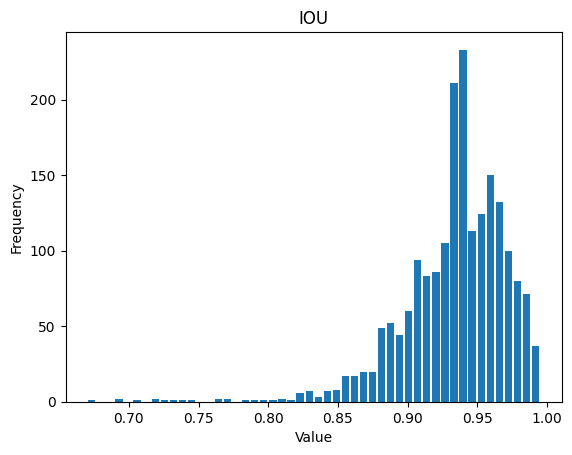

mean: 1.4194422e-05
median: 1.4562107e-05
std_deviation: 2.3799726e-06


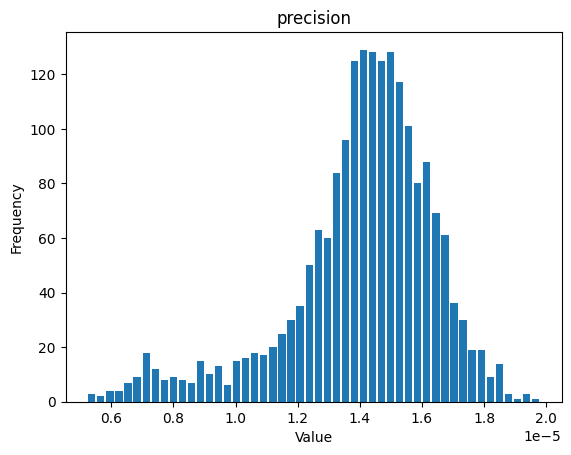

mean: 1.442816e-05
median: 1.4757776e-05
std_deviation: 2.267176e-06


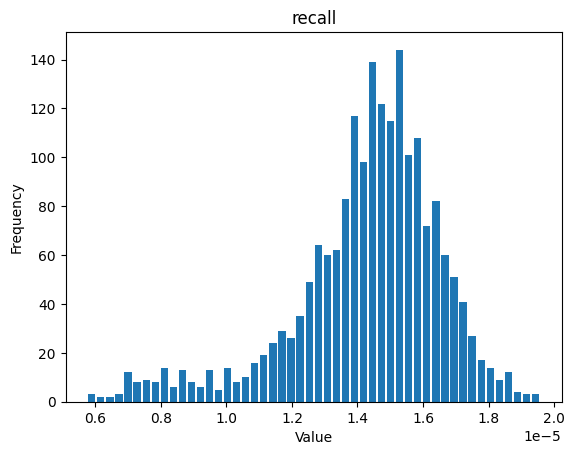

mean: 1.4301502751782531e-05
median: 1.4649842229724857e-05
std_deviation: 2.3059282650982297e-06


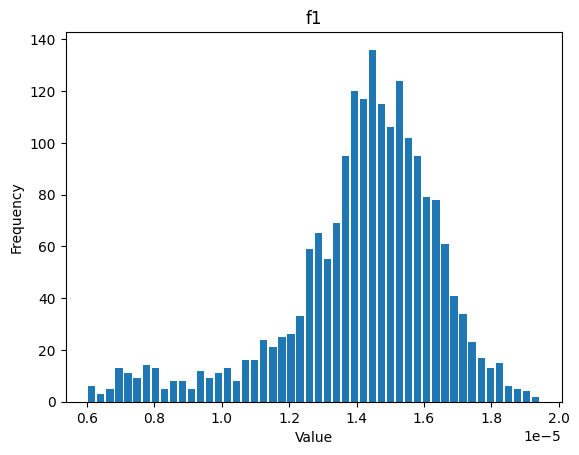

In [4]:
# FILL
shape = (224, 224)
detector = "centerface"
ignore_poorly_illuminated = True
BUAA_pth = "data/BUAA/BUAAVISNIR"

bm_on_center = face_detection_benchmark_on_BUAA(detector, shape, ignore_poorly_illuminated, BUAA_pth)
vl_fps, ni_fps, vl_faces, ni_faces, ious, precisions, recalls, f1s = bm_on_center

In [5]:
import cv2
from PIL import Image
import numpy as np
from pathlib import Path

In [6]:
def extract_square_roi(image, x, y, w, h):
    # Calculate the side length of the square ROI
    side_length = max(w, h)

    # Create a black image with the same number of channels as the original image
    black_image = np.zeros((side_length, side_length, image.shape[2]), dtype=np.uint8)

    # Calculate bounding points
    x_start = (side_length - w) // 2
    y_start = (side_length - h) // 2
    x_end = x_start + w
    y_end = y_start + h
    
    # insert the ROI
    black_image[y_start:y_end, x_start:x_end] = image[y:y + h, x:x + w]

    return black_image

In [9]:
def preprocess_retina(save_folder, vl_faces):
    save_folder = Path(save_folder)
    
    for i in range(len(vl_faces)):
        vl_face_np = (vl_faces[i][0]['face'])
        print(vl_face_np.shape)
        vl = Image.fromarray(extract_square_roi(vl_face_np, 0, 0, vl_face_np.shape[1], vl_face_np.shape[0]).astype(np.uint8))
        vl_fp = Path(vl_fps[i])
        vl_new_pth = save_folder / vl_fp.parent.parent.name / vl_fp.parent.name / vl_fp.name

        vl_new_pth.parent.mkdir(parents=True, exist_ok=True)
        vl.save(str(vl_new_pth))

        print(vl_new_pth)

        x = int(vl_faces[i][0]['facial_area']['x'])
        y = int(vl_faces[i][0]['facial_area']['y'])
        w = int(vl_faces[i][0]['facial_area']['w'])
        h = int(vl_faces[i][0]['facial_area']['h'])
        ni = cv2.imread(ni_fps[i])
        ni = cv2.cvtColor(cv2.cvtColor(ni, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
        print(ni.shape)
        ni = extract_square_roi(np.array(ni), x, y, w, h)
        print(">>", ni.shape)
        # Extract the region of interest (ROI)
        ni = Image.fromarray(ni.astype(np.uint8))
    #     ni = Image.fromarray((255*ni_faces[i][0]['face']).astype(np.uint8))
        ni_fp = Path(ni_fps[i])
        ni_new_pth = save_folder / ni_fp.parent.parent.name / ni_fp.parent.name / ni_fp.name

        ni.save(ni_new_pth)
        print(ni_new_pth)

In [ ]:
# FILL
save_folder = Path('data/Z_PreprocImg-centerface-gray-averaged')

preprocess_retina(save_folder, vl_faces)

## Visualize detection


define visualization

In [14]:
def draw_rectangle(image, coordinates, color=(255, 0, 0), thickness=2):
    draw = ImageDraw.Draw(image)
    x, y, w, h = coordinates
    draw.rectangle([x, y, x + w, y + h], outline=color, width=thickness)

def visualize(fps, detector, output_shape):
    assert detector in ["retinaface", "mtcnn", "opencv", "ssv", "dlib", "centerface"], "Invalid detector"

    for (vl_fp, ni_fp) in fps:
        print(vl_fp)
        print(ni_fp)
        
        # ------------
        vl = cv2.imread(vl_fp)
        vl = cv2.cvtColor(cv2.cvtColor(vl, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB) # convert to grayscale (as RGB)
        ni = cv2.imread(ni_fp)
        ni = cv2.cvtColor(cv2.cvtColor(ni, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB) # convert to grayscale (as RGB)
        
        img_vl = Image.fromarray(vl)
        img_ni = Image.fromarray(ni)

        if detector == "centerface":
            centerface = CenterFace()
            vl_dets, vl_lms = centerface(vl, threshold=0.35)
            ni_dets, ni_lms = centerface(ni, threshold=0.35)

            vl_face_objs = (vl_dets, vl_lms)
            ni_face_objs = (ni_dets, ni_lms)

            # bounding box points - x, y, w, h
            vl_box = [vl_dets[0][0], vl_dets[0][1], vl_dets[0][2] - vl_dets[0][0], vl_dets[0][3] - vl_dets[0][1]]
            ni_box = [ni_dets[0][0], ni_dets[0][1], ni_dets[0][2] - ni_dets[0][0], ni_dets[0][3] - ni_dets[0][1]]

        else:
            vl_face_objs = DeepFace.extract_faces(
                                        img_path=vl_fp,
                                        target_size=output_shape,
                                        detector_backend=detector,
                                        enforce_detection=False,
                                    )

            ni_face_objs = DeepFace.extract_faces(
                            img_path=ni_fp,
                            target_size=output_shape,
                            detector_backend=detector,
                            enforce_detection=False,
                        )
            
            # bounding box points - x, y, w, h
            vl_box = list(vl_face_objs[0]['facial_area'].values())
            ni_box = list(ni_face_objs[0]['facial_area'].values())

        # calculate metrics
        iou = calculate_iou(vl_box, ni_box)
        precision, recall, f1_score = calculate_precision_recall_f1(vl_box, ni_box)

        # Draw the rectangle on the image
        image_with_rectangle = img_vl.copy()
        draw_rectangle(image_with_rectangle, vl_box, color=(255,0,0))
        draw_rectangle(image_with_rectangle, ni_box, color=(0,0,255))
        
        # display
        print("ORIGINAL VL IMAGE")
        display(img_vl)
        print("ORIGINAL NI IMAGE")
        display(img_ni)
        print("ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL")
        display(image_with_rectangle)

        print("iou", iou)
        print("f1", f1_score)
        print("prec", precision)
        print("rec", recall)

        print("="*30)
        print("="*30)
        
def _display_multiple_preprocessing_types(fps):
    for (vl_fp, ni_fp) in fps:
        print(vl_fp)
        print(ni_fp)
        
        vl = cv2.cvtColor(cv2.imread(vl_fp), cv2.COLOR_BGR2RGB)
        vl_gray = cv2.cvtColor(vl, cv2.COLOR_RGB2GRAY)
        ni = cv2.imread(ni_fp)
        
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        c_img = c.apply(vl_gray)
        eq_img = cv2.equalizeHist(vl_gray)
        
        # display
        print("ORIGINAL VL RGB image")
        display(Image.fromarray(vl))
        print("VL GRAYSCALE")
        display(Image.fromarray(vl_gray))
        print("NI GRAYSCALE")
        display(Image.fromarray(ni))
        print("VL GRAYSCALE + 50 BRIGHTNESS")
        display(Image.fromarray(vl_gray + 80))
        print("VL GRAYSCALE image with CLAHE")
        display(Image.fromarray(c_img))
        print("VL GRAYSCALE image with HISTOGRAM EQUALIZATION")
        display(Image.fromarray(eq_img))
        
        print("="*60)


show face detection on sample images

data/BUAA/BUAAVISNIR/29/3.bmp
data/BUAA/BUAAVISNIR/29/4.bmp
cpu times =  0:00:00.057003
cpu times =  0:00:00.040711
ORIGINAL VL IMAGE


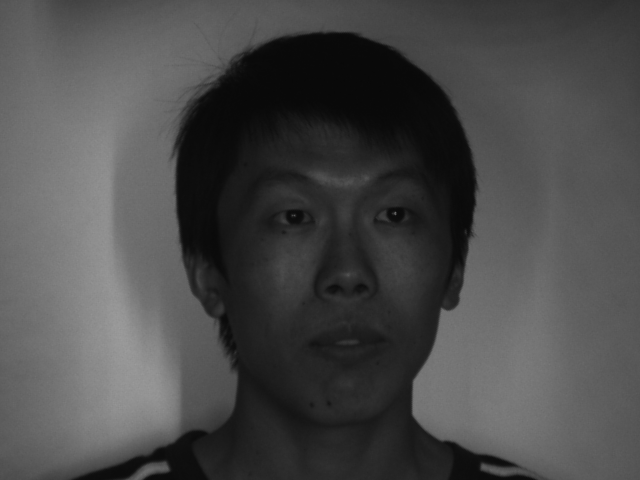

ORIGINAL NI IMAGE


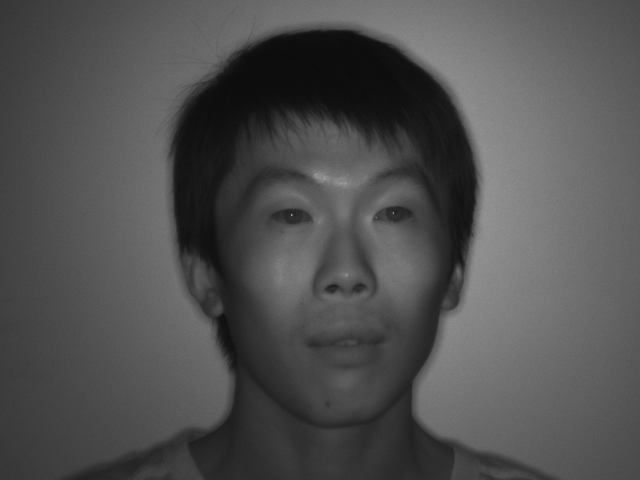

ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL


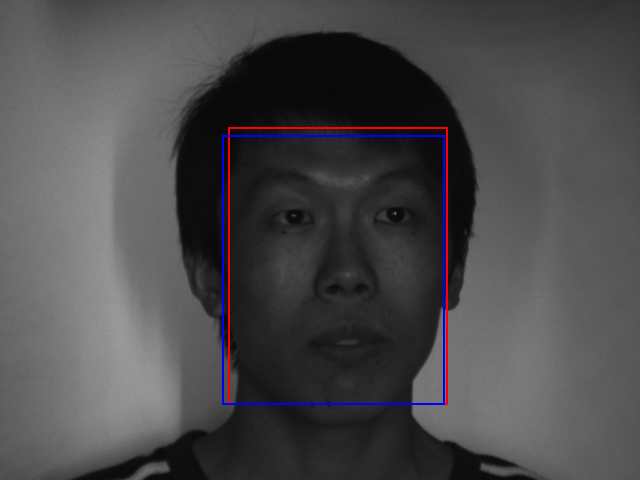

iou 0.9370204
f1 1.5580794648004184e-05
prec 1.572784e-05
rec 1.5436475e-05
data/BUAA/BUAAVISNIR/30/3.bmp
data/BUAA/BUAAVISNIR/30/4.bmp
cpu times =  0:00:00.063785
cpu times =  0:00:00.041963
ORIGINAL VL IMAGE


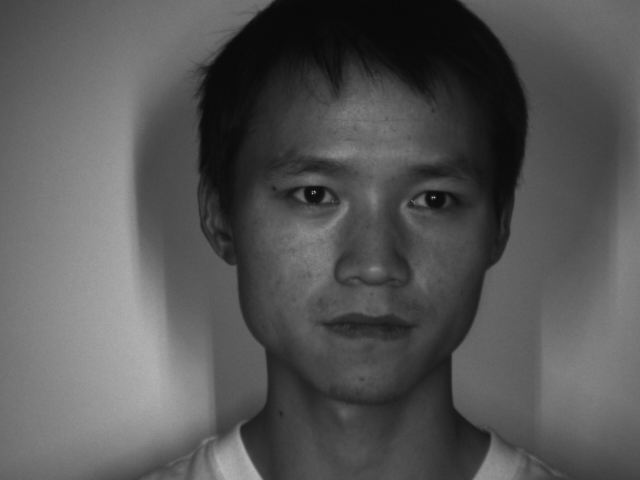

ORIGINAL NI IMAGE


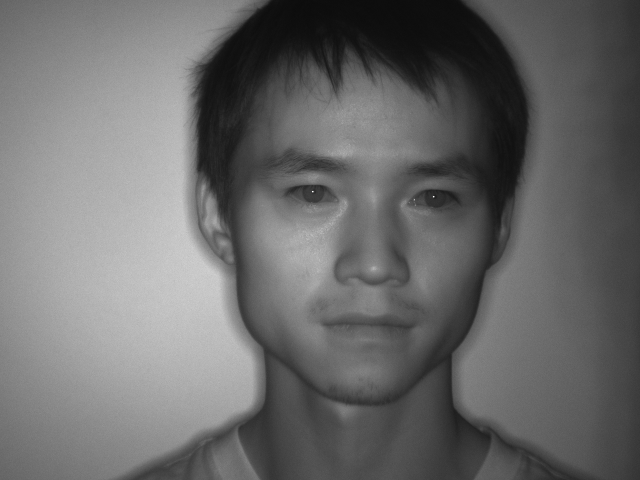

ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL


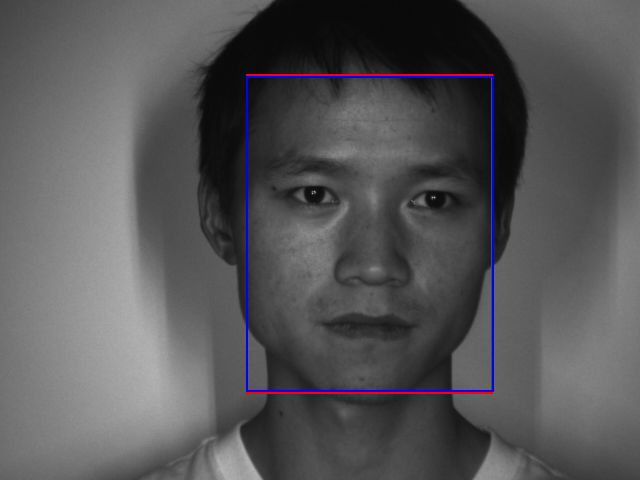

iou 0.98200995
f1 1.256344504805308e-05
prec 1.261503e-05
rec 1.251228e-05
data/BUAA/BUAAVISNIR/14/3.bmp
data/BUAA/BUAAVISNIR/14/4.bmp
cpu times =  0:00:00.057800
cpu times =  0:00:00.043366
ORIGINAL VL IMAGE


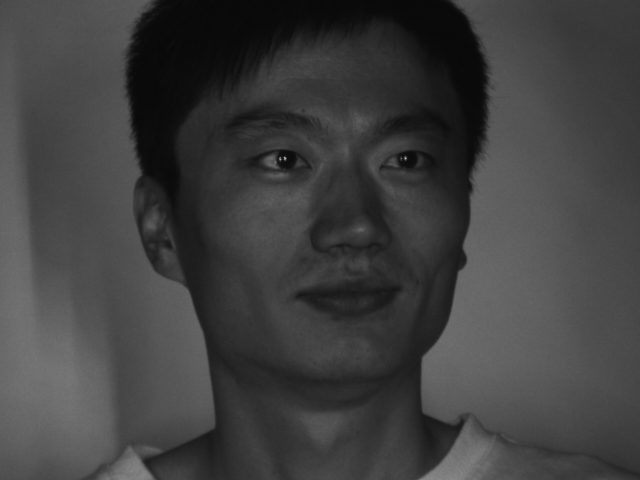

ORIGINAL NI IMAGE


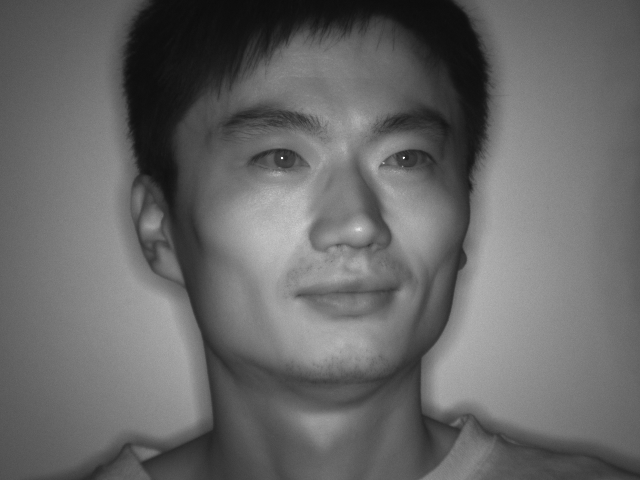

ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL


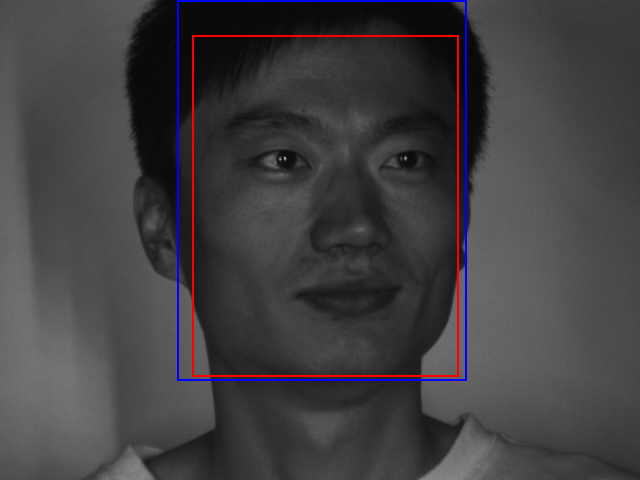

iou 0.82613224
f1 8.246092147196576e-06
prec 7.5292282e-06
rec 9.113829e-06
data/BUAA/BUAAVISNIR/66/3.bmp
data/BUAA/BUAAVISNIR/66/4.bmp
cpu times =  0:00:00.063745
cpu times =  0:00:00.043399
ORIGINAL VL IMAGE


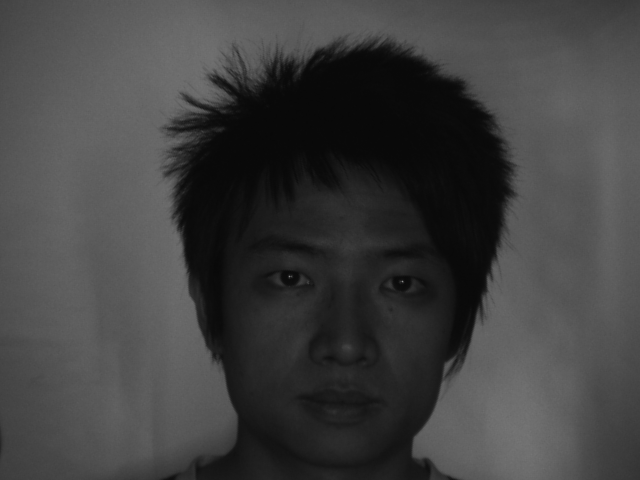

ORIGINAL NI IMAGE


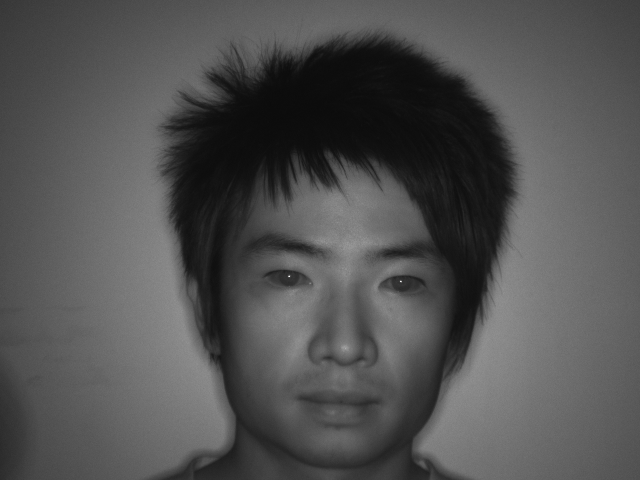

ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL


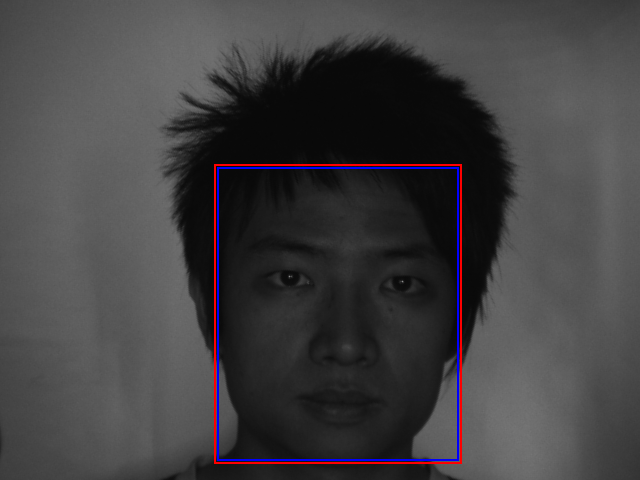

iou 0.95784414
f1 1.3297543135999807e-05
prec 1.3590165e-05
rec 1.3017258e-05
data/BUAA/BUAAVISNIR/8/3.bmp
data/BUAA/BUAAVISNIR/8/4.bmp
cpu times =  0:00:00.059094
cpu times =  0:00:00.042355
ORIGINAL VL IMAGE


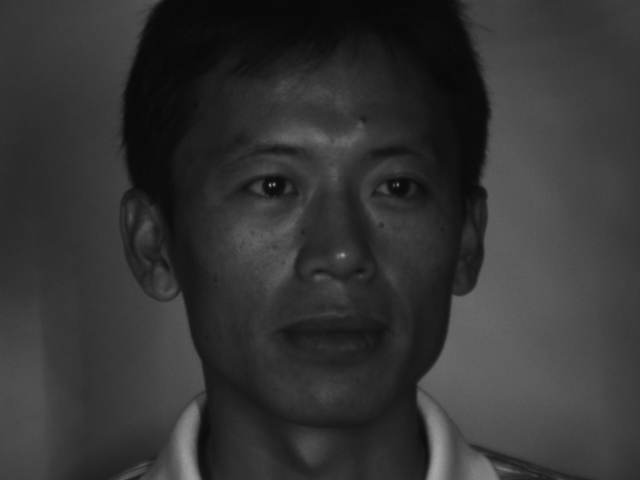

ORIGINAL NI IMAGE


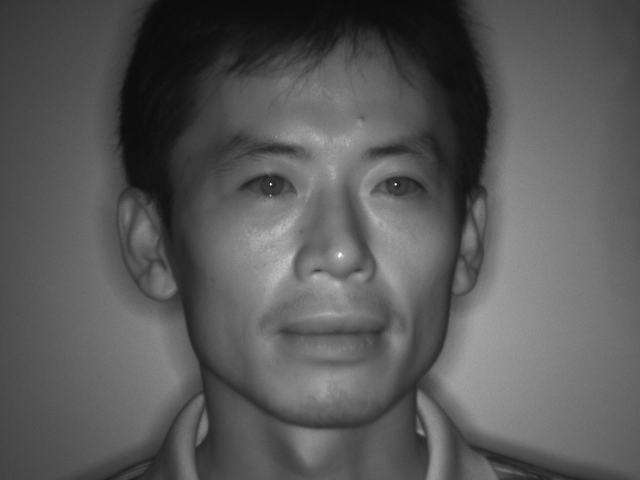

ORIGINAL VL IMAGE WITH HIGHLIGHTED DETECTION - blue is NI, red is VL


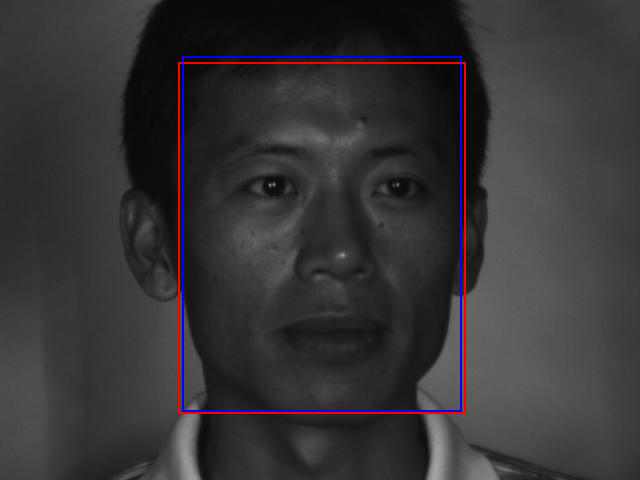

iou 0.9532916
f1 9.566640270297785e-06
prec 9.627848e-06
rec 9.506205e-06


In [7]:
fps = [
    ('data/BUAA/BUAAVISNIR/29/3.bmp', 'data/BUAA/BUAAVISNIR/29/4.bmp'),
    ('data/BUAA/BUAAVISNIR/30/3.bmp', 'data/BUAA/BUAAVISNIR/30/4.bmp'),
    ('data/BUAA/BUAAVISNIR/14/3.bmp', 'data/BUAA/BUAAVISNIR/14/4.bmp'),
    ('data/BUAA/BUAAVISNIR/66/3.bmp', 'data/BUAA/BUAAVISNIR/66/4.bmp'),
    ('data/BUAA/BUAAVISNIR/8/3.bmp', 'data/BUAA/BUAAVISNIR/8/4.bmp'),
]
detector = "centerface"
output_shape = (224,224)

visualize(fps, detector, output_shape)

show several preprocessing options

In [ ]:
fps = [
    ('data/BUAA/BUAAVISNIR/29/3.bmp', 'data/BUAA/BUAAVISNIR/29/4.bmp'),
    ('data/BUAA/BUAAVISNIR/30/3.bmp', 'data/BUAA/BUAAVISNIR/30/4.bmp'),
    ('data/BUAA/BUAAVISNIR/14/3.bmp', 'data/BUAA/BUAAVISNIR/14/4.bmp'),
    ('data/BUAA/BUAAVISNIR/66/3.bmp', 'data/BUAA/BUAAVISNIR/66/4.bmp'),
    ('data/BUAA/BUAAVISNIR/8/3.bmp', 'data/BUAA/BUAAVISNIR/8/4.bmp'),
]

_display_multiple_preprocessing_types(fps)

attempt for brightness balancing according to sample image

In [9]:
# original_image = cv2.imread('../data/BUAA/BUAAVISNIR/9/3.bmp')
# sample_image = cv2.imread('../data/C_PreProcessImg/VL_Acropped/Strong/P002/Disgust/FirstF_001.jpeg')


# original_grayscale = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# sample_grayscale = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)


# sample_mean = np.mean(sample_grayscale)
# sample_std = np.std(sample_grayscale)

# alpha = 1
# beta = 1

# adjusted_brightness = original_grayscale - sample_mean + sample_mean * alpha
# adjusted_contrast = original_grayscale * beta
# adjusted_image = cv2.addWeighted(adjusted_grayscale, 0, np.ones_like(adjusted_grayscale), 1, 0.5)

# display(Image.fromarray(adjusted_image))

Some attempts for repairing the colors of the VL image

In [ ]:
# c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# # c = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
# o = c.apply((255*vl_faces[2][0]['face']).astype(np.uint8))
# display(Image.fromarray((255*vl_faces[2][0]['face']).astype(np.uint8)))

In [ ]:
# plot_histogram(img[:,:,0], "s")
# plot_histogram(img[:,:,1], "s")
# plot_histogram(img[:,:,2], "s")

In [ ]:
# print(vl_faces[0][0]['face'].shape)
# display(Image.fromarray(255 * vl_faces[0][0]['face'][...,1]).convert('RGB'))

In [ ]:
# img = cv2.imread('../data/BUAA/BUAAVISNIR/42/3.bmp')
# # img[:, :, 1] = np.clip(img[:, :, 1] - 10, 0, 255)
# # img = img[:,:,2]
# # img[:, :, 0] = np.clip(img[:, :, 0] - 100, 0, 255)
# img[:, :, 1] = np.clip(img[:, :, 1] / 1.5, 0, 255)
# # img[:, :, 2] = np.clip(img[:, :, 2] * 10, 0, 255)
# display(Image.fromarray(img))